In [1]:
import h5py
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, butter, filtfilt
import glob
import os
import matplotlib.pyplot as plt
from datetime import datetime

print("Libraries loaded")
print(f"Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries loaded
Started: 2025-10-28 16:44:37


In [2]:
RESP_H5_PATH = r"C:\Users\Padilla-Coreano\Documents\tanish\Resp_h5"
EXCEL_PATH = r"C:\Users\Padilla-Coreano\Documents\tanish\Keypoint RI1+RI2\Excel_Results"
PROCESSED_DATA_PATH = r"C:\Users\Padilla-Coreano\Documents\tanish\Keypoint RI1+RI2\Excel_Results\processed_respiration_data_0.5Hz.pkl"

ORIGINAL_SAMPLING_RATE = 20000
TARGET_SAMPLING_RATE = 100
MIN_SYLLABLE_DURATION = 500

PEAK_MIN_DISTANCE = 0.08
PEAK_PROMINENCE_FACTOR = 0.2

FPS_MAPPING = {
    "RI1_s1_1": 15,
    "RI1_s2_3": 15,
    "RI1_s3_6": 29,
    "RI2_s1_1": 15,
    "RI2_s2_4": 15
}
DEFAULT_FPS = 30

print("Configuration loaded")

Configuration loaded


In [3]:
def detect_breathing_peaks(signal, fs=TARGET_SAMPLING_RATE):
    signal_std = np.std(signal)
    signal_mean = np.mean(signal)
    
    peaks, properties = find_peaks(
        signal,
        distance=int(fs * PEAK_MIN_DISTANCE),
        prominence=signal_std * PEAK_PROMINENCE_FACTOR,
        height=signal_mean
    )
    
    return peaks

def get_video_fps(filename):
    for pattern, fps in FPS_MAPPING.items():
        if pattern in filename:
            return fps
    return DEFAULT_FPS

print("Peak detection functions defined")

Peak detection functions defined


In [4]:
def calculate_respiratory_metrics(peaks, fs=TARGET_SAMPLING_RATE):
    if len(peaks) < 2:
        return np.array([]), np.array([]), np.array([])
    
    peak_times = peaks / fs
    ibi_seconds = np.diff(peak_times)
    breathing_rate_1_over_ibi = 1 / ibi_seconds
    breath_times = peak_times[1:]
    
    return breathing_rate_1_over_ibi, breath_times, ibi_seconds

def create_syllable_bouts(behavior_df, video_fps, min_duration_ms=MIN_SYLLABLE_DURATION):
    behavior_df = behavior_df.copy()
    behavior_df['time_seconds'] = behavior_df['frame_number'] / video_fps
    behavior_df['transition'] = (behavior_df['syllable'] != behavior_df['syllable'].shift()).astype(int)
    behavior_df['bout_group'] = behavior_df['transition'].cumsum()
    
    bouts_list = []
    
    for group_id, group in behavior_df.groupby('bout_group'):
        syllable_id = group['syllable'].iloc[0]
        start_time = group['time_seconds'].min()
        end_time = group['time_seconds'].max()
        duration_ms = (end_time - start_time) * 1000
        
        if duration_ms >= min_duration_ms:
            bout_info = {
                'syllable_id': syllable_id,
                'start_frame': group['frame_number'].min(),
                'end_frame': group['frame_number'].max(),
                'start_time_sec': start_time,
                'end_time_sec': end_time,
                'duration_ms': duration_ms,
                'frame_count': len(group),
                'fps_used': video_fps
            }
            bouts_list.append(bout_info)
    
    return bouts_list

print("Data processing functions defined")

Data processing functions defined


In [5]:
def process_single_session(session_id, respiratory_signal, excel_files):
    print(f"Processing: {session_id}")
    
    signal = respiratory_signal['respiration']
    fs = TARGET_SAMPLING_RATE
    time_vector = np.arange(len(signal)) / fs
    
    peaks = detect_breathing_peaks(signal, fs)
    print(f"  Peaks detected: {len(peaks)}")
    
    if len(peaks) < 2:
        print("  Insufficient peaks - skipping")
        return None
    
    breathing_rates, breath_times, ibi_values = calculate_respiratory_metrics(peaks, fs)
    breathing_rates_bpm = breathing_rates * 60
    
    matching_excel = None
    for excel_file in excel_files:
        session_patterns = ['RI1_s1_1', 'RI1_s1_2', 'RI1_s2_3', 'RI1_s2_4', 
                           'RI1_s3_5', 'RI1_s3_6', 'RI1_s4_7', 'RI1_s4_8', 'RI1_s5_13',
                           'RI2_s1_1', 'RI2_s1_2', 'RI2_s2_3', 'RI2_s2_4', 
                           'RI2_s3_5', 'RI2_s3_6', 'RI2_s4_7', 'RI2_s4_8', 'RI2_s5_13']
        
        if any(pattern in session_id and pattern in excel_file for pattern in session_patterns):
            matching_excel = excel_file
            break
    
    if not matching_excel:
        print("  No matching behavioral file")
        return None
    
    behavior_df = pd.read_excel(matching_excel)
    video_fps = get_video_fps(os.path.basename(matching_excel))
    
    bouts_list = create_syllable_bouts(behavior_df, video_fps)
    
    if not bouts_list:
        print("  No valid syllable bouts")
        return None
    
    processed_bouts = []
    
    for bout in bouts_list:
        bout_start = bout['start_time_sec']
        bout_end = bout['end_time_sec']
        
        time_mask = (time_vector >= bout_start) & (time_vector <= bout_end)
        bout_signal = signal[time_mask]
        
        if len(bout_signal) > 0:
            resp_stats = {
                'mean_resp_signal': np.mean(bout_signal),
                'min_resp_signal': np.min(bout_signal),
                'max_resp_signal': np.max(bout_signal),
                'resp_signal_range': np.max(bout_signal) - np.min(bout_signal)
            }
        else:
            resp_stats = {k: np.nan for k in ['mean_resp_signal', 'min_resp_signal', 
                                            'max_resp_signal', 'resp_signal_range']}
        
        peak_times = peaks / fs
        syllable_peaks = peak_times[(peak_times >= bout_start) & (peak_times <= bout_end)]
        breath_count = len(syllable_peaks)
        
        if len(syllable_peaks) > 1:
            syllable_ibis = np.diff(syllable_peaks)
            mean_ibi = np.mean(syllable_ibis)
            mean_breathing_rate = 1 / mean_ibi
            mean_bpm = mean_breathing_rate * 60
        else:
            mid_time = (bout_start + bout_end) / 2
            if len(breath_times) > 0:
                mean_breathing_rate = np.interp(mid_time, breath_times, breathing_rates)
                mean_bpm = mean_breathing_rate * 60
                mean_ibi = 1 / mean_breathing_rate if mean_breathing_rate > 0 else np.nan
            else:
                mean_breathing_rate = mean_bpm = mean_ibi = np.nan
        
        bout_data = {
            **bout,
            **resp_stats,
            'breath_count': breath_count,
            'mean_1_over_IBI': mean_breathing_rate,
            'mean_breathing_rate_BPM': mean_bpm,
            'mean_IBI_seconds': mean_ibi,
            'video_name': behavior_df['video_name'].iloc[0] if 'video_name' in behavior_df.columns else 'unknown',
            'track_name': behavior_df['track_name'].iloc[0] if 'track_name' in behavior_df.columns else 'track0'
        }
        
        processed_bouts.append(bout_data)
    
    results_df = pd.DataFrame(processed_bouts)
    results_df = results_df.sort_values('start_time_sec').reset_index(drop=True)
    
    print(f"  Processed {len(results_df)} syllable bouts")
    
    return results_df

print("Main analysis function defined")

Main analysis function defined


In [6]:
def run_complete_analysis():
    print("Starting analysis...")
    
    respiratory_data = pd.read_pickle(PROCESSED_DATA_PATH)
    excel_files = glob.glob(os.path.join(EXCEL_PATH, "*track0*.xlsx"))
    
    print(f"Found {len(respiratory_data)} respiratory sessions")
    print(f"Found {len(excel_files)} behavioral files")
    
    all_results = {}
    successful_sessions = 0
    
    for session_id, resp_data in respiratory_data.items():
        try:
            result = process_single_session(session_id, resp_data, excel_files)
            
            if result is not None:
                session_name = session_id.replace('.h5', '')
                output_file = f"CORRECTED_PEAK_COUNT_{session_name}_analysis.xlsx"
                result.to_excel(output_file, index=False)
                print(f"  Saved: {output_file}")
                
                all_results[session_id] = result
                successful_sessions += 1
            
        except Exception as e:
            print(f"  Error processing {session_id}: {str(e)}")
    
    print(f"Analysis complete: {successful_sessions}/{len(respiratory_data)} sessions processed")
    
    return all_results

analysis_results = run_complete_analysis()

Starting analysis...
Found 18 respiratory sessions
Found 17 behavioral files
Processing: RI1_s1_1_p5_2_nRB6_20250622_143958_merged.h5
  Peaks detected: 4566
  Processed 303 syllable bouts
  Saved: CORRECTED_PEAK_COUNT_RI1_s1_1_p5_2_nRB6_20250622_143958_merged_analysis.xlsx
Processing: RI1_s1_2_p5_1_nRB6_20250622_170742_merged.h5
  Peaks detected: 4495
  Processed 266 syllable bouts
  Saved: CORRECTED_PEAK_COUNT_RI1_s1_2_p5_1_nRB6_20250622_170742_merged_analysis.xlsx
Processing: RI1_s2_3_p5_3_nRB3_20250622_104059_merged.h5
  Peaks detected: 4091
  Processed 504 syllable bouts
  Saved: CORRECTED_PEAK_COUNT_RI1_s2_3_p5_3_nRB3_20250622_104059_merged_analysis.xlsx
Processing: RI1_s2_4_p5_4_nRB3_20250622_123424_merged.h5
  Peaks detected: 5100
  Processed 132 syllable bouts
  Saved: CORRECTED_PEAK_COUNT_RI1_s2_4_p5_4_nRB3_20250622_123424_merged_analysis.xlsx
Processing: RI1_s3_5_p5_4_nRB3_20250621_105014_merged.h5
  Peaks detected: 4163
  No matching behavioral file
Processing: RI1_s3_6_p5_3

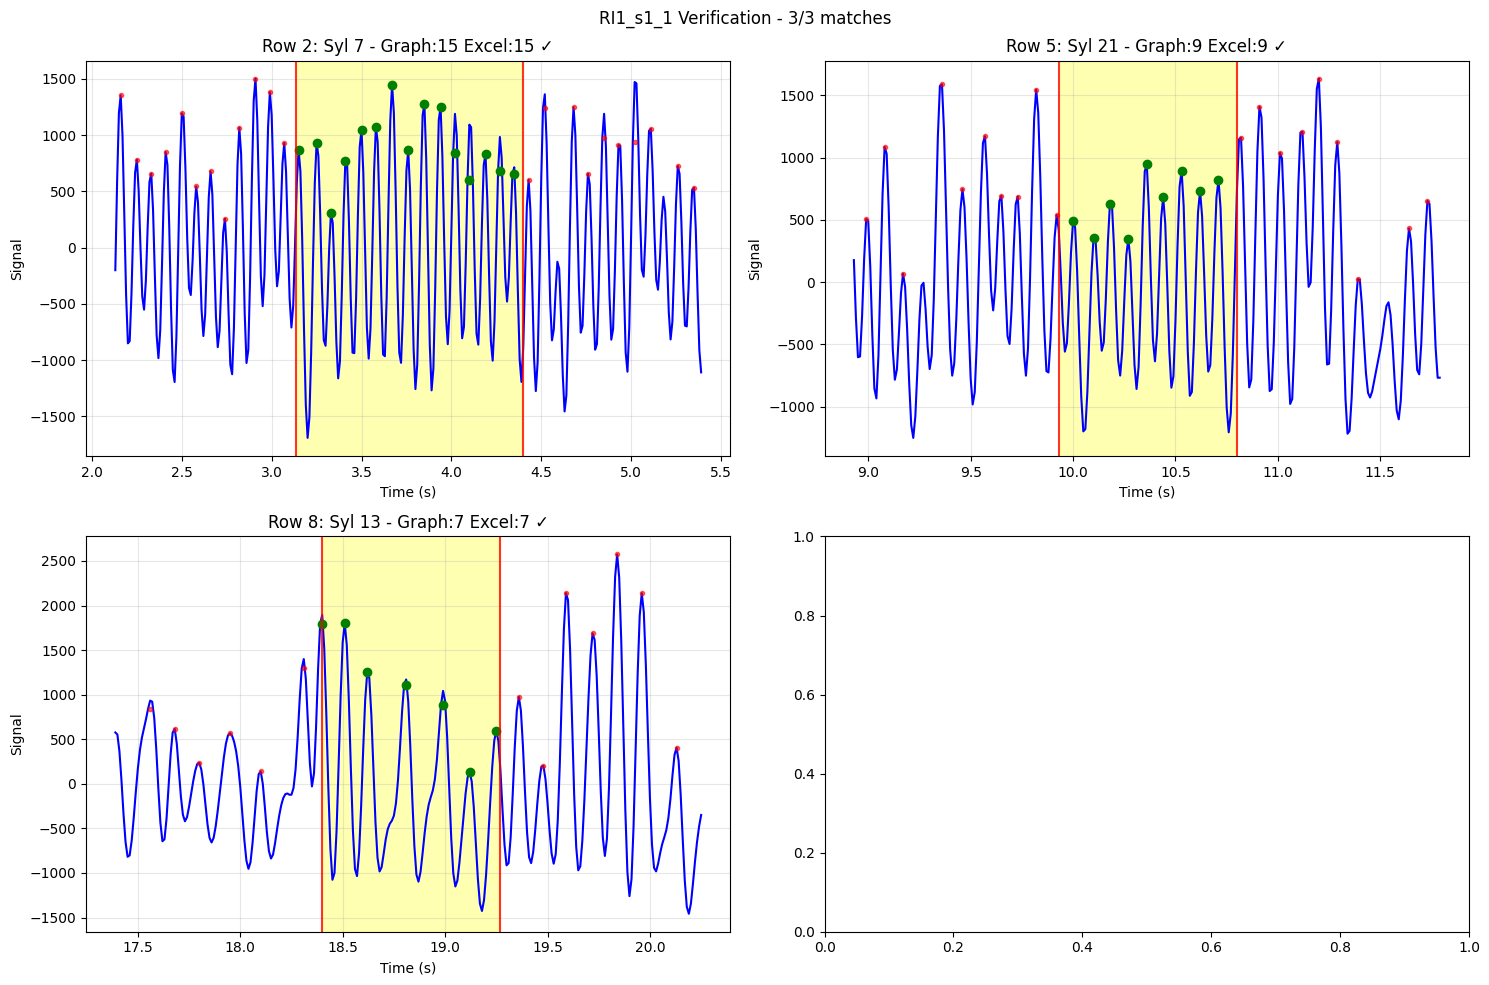

Verification: 3/3 syllables match


In [7]:
def verify_peak_detection(session_id="RI1_s1_1", test_rows=[2, 5, 8]):
    excel_pattern = f"CORRECTED_PEAK_COUNT_*{session_id}*_analysis.xlsx"
    excel_files = glob.glob(excel_pattern)
    
    if not excel_files:
        print(f"No Excel file found for {session_id}")
        return
    
    excel_file = excel_files[0]
    df = pd.read_excel(excel_file)
    
    respiratory_data = pd.read_pickle(PROCESSED_DATA_PATH)
    resp_key = [k for k in respiratory_data.keys() if session_id in k][0]
    signal = respiratory_data[resp_key]['respiration']
    fs = TARGET_SAMPLING_RATE
    
    peaks = detect_breathing_peaks(signal, fs)
    peak_times = peaks / fs
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    matches = 0
    total_tests = 0
    
    for i, row_idx in enumerate(test_rows[:4]):
        if row_idx >= len(df):
            continue
            
        bout = df.iloc[row_idx]
        start_time = bout['start_time_sec']
        end_time = bout['end_time_sec']
        
        syllable_peaks = peak_times[(peak_times >= start_time) & (peak_times <= end_time)]
        graph_count = len(syllable_peaks)
        excel_count = bout['breath_count']
        
        match = (graph_count == excel_count)
        matches += match
        total_tests += 1
        
        context = 1.0
        plot_start = max(0, start_time - context)
        plot_end = min(len(signal)/fs, end_time + context)
        
        i0 = int(plot_start * fs)
        i1 = int(plot_end * fs)
        t_plot = np.arange(i0, i1) / fs
        
        window_peaks = peak_times[(peak_times >= plot_start) & (peak_times <= plot_end)]
        
        ax = axes[i]
        ax.plot(t_plot, signal[i0:i1], 'b-', lw=1.5)
        ax.plot(window_peaks, signal[(window_peaks * fs).astype(int)], 'ro', ms=3, alpha=0.6)
        ax.plot(syllable_peaks, signal[(syllable_peaks * fs).astype(int)], 'go', ms=6)
        
        ax.axvline(start_time, color='red', linestyle='-', alpha=0.8)
        ax.axvline(end_time, color='red', linestyle='-', alpha=0.8)
        ax.axvspan(start_time, end_time, alpha=0.3, color='yellow')
        
        ax.set_title(f"Row {row_idx}: Syl {bout['syllable_id']} - Graph:{graph_count} Excel:{excel_count} {'✓' if match else '✗'}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Signal")
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f"{session_id} Verification - {matches}/{total_tests} matches")
    plt.tight_layout()
    plt.show()
    
    print(f"Verification: {matches}/{total_tests} syllables match")
    return matches == total_tests

verification_success = verify_peak_detection()

In [8]:
print("Analysis Summary")
print("="*40)

if analysis_results:
    total_sessions = len(analysis_results)
    total_syllables = sum(len(df) for df in analysis_results.values())
    
    all_bouts = pd.concat(analysis_results.values(), ignore_index=True)
    
    print(f"Sessions processed: {total_sessions}")
    print(f"Total syllable bouts: {total_syllables}")
    print(f"Duration range: {all_bouts['duration_ms'].min():.0f} - {all_bouts['duration_ms'].max():.0f} ms")
    print(f"Breathing rate range: {all_bouts['mean_breathing_rate_BPM'].min():.0f} - {all_bouts['mean_breathing_rate_BPM'].max():.0f} BPM")
    print(f"Unique syllables: {all_bouts['syllable_id'].nunique()}")

print("Output files: CORRECTED_PEAK_COUNT_*_analysis.xlsx")
print(f"Completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Analysis Summary
Sessions processed: 17
Total syllable bouts: 4143
Duration range: 500 - 55767 ms
Breathing rate range: 1 - 750 BPM
Unique syllables: 52
Output files: CORRECTED_PEAK_COUNT_*_analysis.xlsx
Completed: 2025-10-28 16:44:57


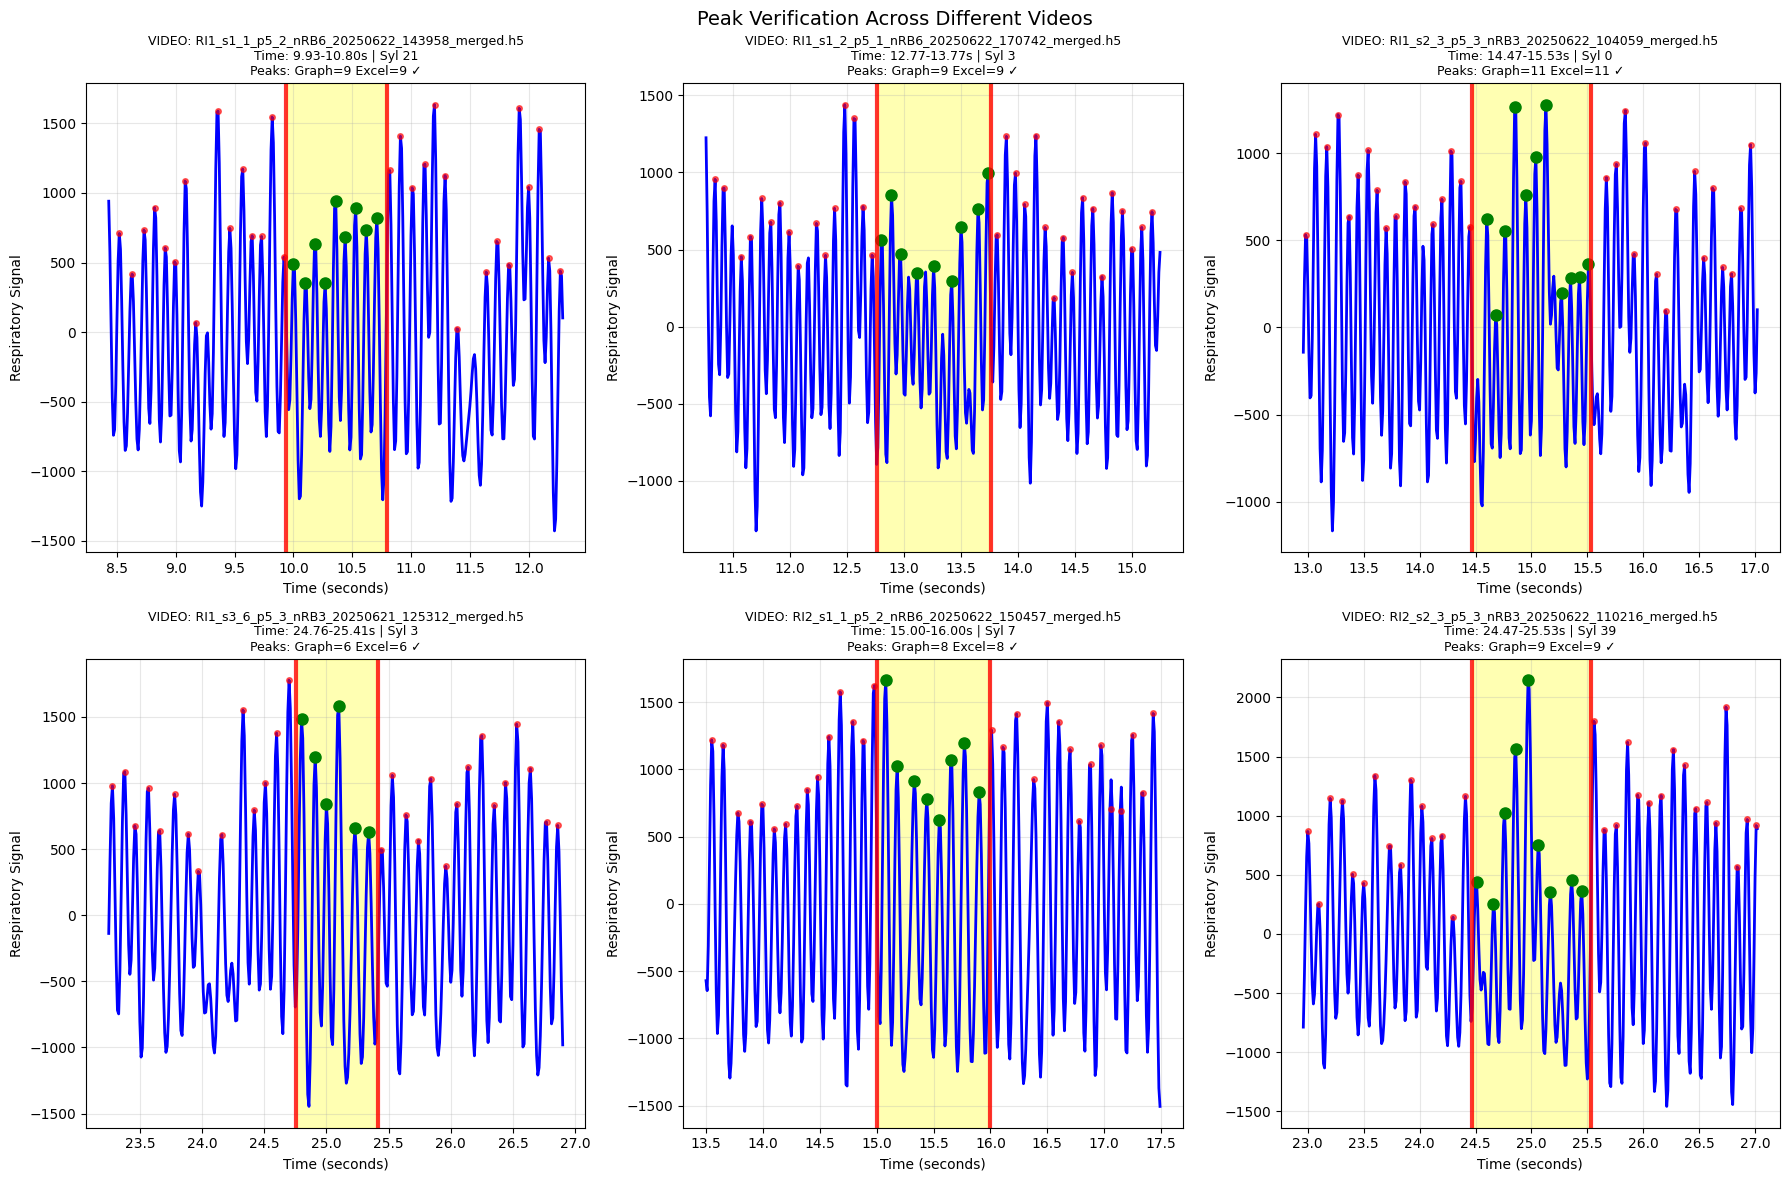

In [9]:
def plot_with_clear_video_info():
    """Plot with clear video names and timing information"""
    
    plot_tests = [
        ("RI1_s1_1", 5),   ("RI1_s1_2", 8),   ("RI1_s2_3", 6),
        ("RI1_s3_6", 10),  ("RI2_s1_1", 7),   ("RI2_s2_3", 9)
    ]
    
    respiratory_data = pd.read_pickle(PROCESSED_DATA_PATH)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, (session_pattern, row_idx) in enumerate(plot_tests):
        
        # Find Excel file
        excel_pattern = f"CORRECTED_PEAK_COUNT_*{session_pattern}*_analysis.xlsx"
        excel_files = glob.glob(excel_pattern)
        
        if not excel_files:
            continue
            
        df = pd.read_excel(excel_files[0])
        
        if row_idx >= len(df):
            continue
            
        # Get respiratory data and find original video name
        resp_key = None
        for key in respiratory_data.keys():
            if session_pattern in key:
                resp_key = key
                break
                
        if resp_key is None:
            continue
            
        signal = respiratory_data[resp_key]['respiration']
        fs = TARGET_SAMPLING_RATE
        
        # Get bout info
        bout = df.iloc[row_idx]
        start_time = bout['start_time_sec']
        end_time = bout['end_time_sec']
        
        # Extract original video filename from resp_key
        original_video_name = resp_key  # This is your original h5 filename
        
        # Detect peaks
        peaks = detect_breathing_peaks(signal, fs)
        peak_times = peaks / fs
        
        syllable_peaks = peak_times[(peak_times >= start_time) & (peak_times <= end_time)]
        graph_count = len(syllable_peaks)
        excel_count = bout['breath_count']
        
        # Plot
        context = 1.5
        plot_start = max(0, start_time - context)
        plot_end = min(len(signal)/fs, end_time + context)
        
        i0 = int(plot_start * fs)
        i1 = int(plot_end * fs)
        t_plot = np.arange(i0, i1) / fs
        
        window_peaks = peak_times[(peak_times >= plot_start) & (peak_times <= plot_end)]
        
        ax = axes[i]
        ax.plot(t_plot, signal[i0:i1], 'b-', lw=2)
        ax.plot(window_peaks, signal[(window_peaks * fs).astype(int)], 'ro', ms=4, alpha=0.6)
        ax.plot(syllable_peaks, signal[(syllable_peaks * fs).astype(int)], 'go', ms=8)
        
        ax.axvline(start_time, color='red', linestyle='-', linewidth=3, alpha=0.8)
        ax.axvline(end_time, color='red', linestyle='-', linewidth=3, alpha=0.8)
        ax.axvspan(start_time, end_time, alpha=0.3, color='yellow')
        
        # Clear title with video name and timing
        match_status = "✓" if graph_count == excel_count else "✗"
        ax.set_title(f"VIDEO: {original_video_name}\n"
                    f"Time: {start_time:.2f}-{end_time:.2f}s | Syl {bout['syllable_id']:.0f}\n"
                    f"Peaks: Graph={graph_count} Excel={excel_count} {match_status}", 
                    fontsize=9)
        
        ax.set_xlabel("Time (seconds)", fontsize=10)
        ax.set_ylabel("Respiratory Signal", fontsize=10)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle("Peak Verification Across Different Videos", fontsize=14)
    plt.tight_layout()
    plt.show()

# Run with clear video information
plot_with_clear_video_info()

In [10]:
import glob
import os
import pandas as pd

In [11]:
def analyze_syllable_distribution():
    excel_files = glob.glob("CORRECTED_PEAK_COUNT_*_analysis.xlsx")
    
    if not excel_files:
        print("No analysis files found. Run the main analysis first.")
        return None, None, None
    
    all_data = []
    video_info = {}
    
    for excel_file in excel_files:
        df = pd.read_excel(excel_file)
        
        filename = os.path.basename(excel_file)
        session_parts = filename.replace('CORRECTED_PEAK_COUNT_', '').replace('_analysis.xlsx', '')
        
        if 'RI1' in session_parts:
            ri_group = 'RI1'
        elif 'RI2' in session_parts:
            ri_group = 'RI2'
        else:
            ri_group = 'Unknown'
        
        df['ri_group'] = ri_group
        df['session_id'] = session_parts
        df['video_file'] = excel_file
        
        all_data.append(df)
        video_info[session_parts] = {
            'ri_group': ri_group,
            'syllable_count': len(df),
            'unique_syllables': df['syllable_id'].nunique(),
            'file': excel_file
        }
    
    return all_data, video_info

In [12]:
all_data, video_info = analyze_syllable_distribution()
combined_df = pd.concat(all_data, ignore_index=True)

In [13]:
ri1_syllables = set(combined_df[combined_df['ri_group'] == 'RI1']['syllable_id'].unique())
ri2_syllables = set(combined_df[combined_df['ri_group'] == 'RI2']['syllable_id'].unique())

shared_syllables = ri1_syllables.intersection(ri2_syllables)
ri1_only = ri1_syllables - ri2_syllables  
ri2_only = ri2_syllables - ri1_syllables

print("SYLLABLE DISTRIBUTION")
print("=" * 40)
print(f"Shared syllables: {sorted(list(shared_syllables))}")
print(f"RI1 only: {sorted(list(ri1_only))}")
print(f"RI2 only: {sorted(list(ri2_only))}")

SYLLABLE DISTRIBUTION
Shared syllables: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 39, 41, 42, 43, 44, 45]
RI1 only: [8, 57, 78, 82, 85]
RI2 only: [12, 22, 40, 46, 51, 52, 58, 87]


In [14]:
for syllable in sorted(combined_df['syllable_id'].unique()):
    syllable_data = combined_df[combined_df['syllable_id'] == syllable]
    videos_with_syllable = syllable_data['session_id'].unique()
    ri_groups = syllable_data['ri_group'].unique()
    
    if len(ri_groups) > 1:
        status = " [SHARED]"
    elif 'RI1' in ri_groups:
        status = " [RI1 ONLY]"
    elif 'RI2' in ri_groups:
        status = " [RI2 ONLY]"
    
    print(f"Syllable {syllable}{status}:")
    for video in sorted(videos_with_syllable):
        count = len(syllable_data[syllable_data['session_id'] == video])
        print(f"  {video}: {count} instances")

Syllable 0 [SHARED]:
  RI1_s1_1_p5_2_nRB6_20250622_143958_merged: 30 instances
  RI1_s1_2_p5_1_nRB6_20250622_170742_merged: 45 instances
  RI1_s2_3_p5_3_nRB3_20250622_104059_merged: 100 instances
  RI1_s2_4_p5_4_nRB3_20250622_123424_merged: 17 instances
  RI1_s3_6_p5_3_nRB3_20250621_125312_merged: 34 instances
  RI1_s4_7_p5_2_nRB3_20250621_150707_merged: 48 instances
  RI1_s4_8_p5_1_nRB3_20250621_165214_merged: 37 instances
  RI1_s5_13_p5_4_nRB3_20250622_181801_merged: 43 instances
  RI2_s1_1_p5_2_nRB6_20250622_150457_merged: 17 instances
  RI2_s1_2_p5_1_nRB6_20250622_173049_merged: 8 instances
  RI2_s2_3_p5_3_nRB3_20250622_110216_merged: 9 instances
  RI2_s2_4_p5_4_nRB3_20250622_125648_merged: 16 instances
  RI2_s3_5_p5_4_nRB3_20250621_112618_merged: 4 instances
  RI2_s3_6_p5_3_nRB3_20250621_131158_merged: 11 instances
  RI2_s4_7_p5_2_nRB3_20250621_152519_merged: 7 instances
  RI2_s4_8_p5_1_nRB3_20250621_171318_merged: 2 instances
  RI2_s5_13_p5_4_nRB3_20250622_184136_merged: 7 instan

In [15]:
excel_files = glob.glob("CORRECTED_PEAK_COUNT_*_analysis.xlsx")
print(f"Found {len(excel_files)} Excel files:")
for file in excel_files:
    print(f"  {file}")

all_data = []
for excel_file in excel_files:
    df = pd.read_excel(excel_file)
    
    if 'RI1' in excel_file:
        ri_group = 'RI1'
    elif 'RI2' in excel_file:
        ri_group = 'RI2'
    else:
        ri_group = 'Unknown'
    
    df['ri_group'] = ri_group
    df['file_name'] = excel_file
    all_data.append(df)

combined_df = pd.concat(all_data, ignore_index=True)

ri1_syllables = set(combined_df[combined_df['ri_group'] == 'RI1']['syllable_id'].unique())
ri2_syllables = set(combined_df[combined_df['ri_group'] == 'RI2']['syllable_id'].unique())

shared_syllables = ri1_syllables.intersection(ri2_syllables)
ri1_only = ri1_syllables - ri2_syllables  
ri2_only = ri2_syllables - ri1_syllables

print("\nSYLLABLE ANALYSIS FROM YOUR EXCEL FILES:")
print("=" * 50)
print(f"Shared syllables (in both RI1 and RI2): {sorted(list(shared_syllables))}")
print(f"RI1 only syllables: {sorted(list(ri1_only))}")
print(f"RI2 only syllables: {sorted(list(ri2_only))}")

Found 17 Excel files:
  CORRECTED_PEAK_COUNT_RI1_s1_1_p5_2_nRB6_20250622_143958_merged_analysis.xlsx
  CORRECTED_PEAK_COUNT_RI1_s1_2_p5_1_nRB6_20250622_170742_merged_analysis.xlsx
  CORRECTED_PEAK_COUNT_RI1_s2_3_p5_3_nRB3_20250622_104059_merged_analysis.xlsx
  CORRECTED_PEAK_COUNT_RI1_s2_4_p5_4_nRB3_20250622_123424_merged_analysis.xlsx
  CORRECTED_PEAK_COUNT_RI1_s3_6_p5_3_nRB3_20250621_125312_merged_analysis.xlsx
  CORRECTED_PEAK_COUNT_RI1_s4_7_p5_2_nRB3_20250621_150707_merged_analysis.xlsx
  CORRECTED_PEAK_COUNT_RI1_s4_8_p5_1_nRB3_20250621_165214_merged_analysis.xlsx
  CORRECTED_PEAK_COUNT_RI1_s5_13_p5_4_nRB3_20250622_181801_merged_analysis.xlsx
  CORRECTED_PEAK_COUNT_RI2_s1_1_p5_2_nRB6_20250622_150457_merged_analysis.xlsx
  CORRECTED_PEAK_COUNT_RI2_s1_2_p5_1_nRB6_20250622_173049_merged_analysis.xlsx
  CORRECTED_PEAK_COUNT_RI2_s2_3_p5_3_nRB3_20250622_110216_merged_analysis.xlsx
  CORRECTED_PEAK_COUNT_RI2_s2_4_p5_4_nRB3_20250622_125648_merged_analysis.xlsx
  CORRECTED_PEAK_COUNT_RI2_s3

In [16]:
comparison_results = []

for syllable in sorted(shared_syllables):
    syllable_data = combined_df[combined_df['syllable_id'] == syllable]
    
    ri1_data = syllable_data[syllable_data['ri_group'] == 'RI1']
    ri2_data = syllable_data[syllable_data['ri_group'] == 'RI2']
    
    ri1_bpm = ri1_data['mean_breathing_rate_BPM'].dropna()
    ri2_bpm = ri2_data['mean_breathing_rate_BPM'].dropna()
    
    if len(ri1_bpm) > 0 and len(ri2_bpm) > 0:
        ri1_mean = ri1_bpm.mean()
        ri2_mean = ri2_bpm.mean()
        difference = ri2_mean - ri1_mean
        percent_change = (difference / ri1_mean) * 100
        
        print(f"Syllable {syllable}:")
        print(f"  RI1: {ri1_mean:.1f} BPM ({len(ri1_bpm)} instances)")
        print(f"  RI2: {ri2_mean:.1f} BPM ({len(ri2_bpm)} instances)")
        print(f"  Change: {difference:.1f} BPM ({percent_change:+.1f}%)")
        print()
        
        comparison_results.append({
            'syllable': syllable,
            'ri1_bpm': ri1_mean,
            'ri2_bpm': ri2_mean, 
            'difference': difference,
            'percent_change': percent_change
        })

comparison_df = pd.DataFrame(comparison_results)
comparison_df.to_excel("respiration_comparison.xlsx", index=False)
print(f"Saved comparison to respiration_comparison.xlsx")

Syllable 0:
  RI1: 398.6 BPM (354 instances)
  RI2: 417.6 BPM (81 instances)
  Change: 19.0 BPM (+4.8%)

Syllable 1:
  RI1: 360.1 BPM (16 instances)
  RI2: 410.0 BPM (5 instances)
  Change: 49.9 BPM (+13.9%)

Syllable 2:
  RI1: 548.9 BPM (19 instances)
  RI2: 355.8 BPM (12 instances)
  Change: -193.1 BPM (-35.2%)

Syllable 3:
  RI1: 401.8 BPM (651 instances)
  RI2: 394.6 BPM (368 instances)
  Change: -7.2 BPM (-1.8%)

Syllable 4:
  RI1: 411.2 BPM (4 instances)
  RI2: 430.5 BPM (8 instances)
  Change: 19.3 BPM (+4.7%)

Syllable 5:
  RI1: 419.7 BPM (41 instances)
  RI2: 366.3 BPM (43 instances)
  Change: -53.5 BPM (-12.7%)

Syllable 6:
  RI1: 401.4 BPM (5 instances)
  RI2: 403.5 BPM (7 instances)
  Change: 2.1 BPM (+0.5%)

Syllable 7:
  RI1: 463.3 BPM (130 instances)
  RI2: 482.5 BPM (31 instances)
  Change: 19.2 BPM (+4.1%)

Syllable 9:
  RI1: 421.2 BPM (137 instances)
  RI2: 365.3 BPM (52 instances)
  Change: -55.9 BPM (-13.3%)

Syllable 10:
  RI1: 348.7 BPM (385 instances)
  RI2: 364.

In [17]:
# Verification checks
print("VERIFICATION CHECKS:")
print("=" * 30)

# Check 1: Do the numbers add up?
total_unique = len(shared_syllables) + len(ri1_only) + len(ri2_only)
actual_unique = len(combined_df['syllable_id'].unique())
print(f"Math check: {len(shared_syllables)} shared + {len(ri1_only)} RI1-only + {len(ri2_only)} RI2-only = {total_unique}")
print(f"Actual unique syllables: {actual_unique}")
print(f"Numbers match: {total_unique == actual_unique}")

# Check 2: Verify a few shared syllables actually appear in both groups
print("\nSpot check - shared syllables verification:")
for syllable in list(shared_syllables)[:3]:  # Check first 3
    ri1_files = combined_df[(combined_df['syllable_id'] == syllable) & (combined_df['ri_group'] == 'RI1')]['file_name'].unique()
    ri2_files = combined_df[(combined_df['syllable_id'] == syllable) & (combined_df['ri_group'] == 'RI2')]['file_name'].unique()
    print(f"Syllable {syllable}: RI1 files={len(ri1_files)}, RI2 files={len(ri2_files)}")

# Check 3: Verify RI1-only syllables don't appear in RI2
print(f"\nRI1-only check: Checking if any RI1-only syllables appear in RI2...")
ri1_only_in_ri2 = []
for syllable in ri1_only:
    if syllable in ri2_syllables:
        ri1_only_in_ri2.append(syllable)
print(f"RI1-only syllables found in RI2: {ri1_only_in_ri2} (should be empty)")

print(f"\nVerification complete. Results saved to syllable_analysis_complete.xlsx")

VERIFICATION CHECKS:
Math check: 39 shared + 5 RI1-only + 8 RI2-only = 52
Actual unique syllables: 52
Numbers match: True

Spot check - shared syllables verification:
Syllable 0: RI1 files=8, RI2 files=9
Syllable 1: RI1 files=5, RI2 files=3
Syllable 2: RI1 files=6, RI2 files=7

RI1-only check: Checking if any RI1-only syllables appear in RI2...
RI1-only syllables found in RI2: [] (should be empty)

Verification complete. Results saved to syllable_analysis_complete.xlsx


In [ ]:
# Recreate the all_syllables_df
all_syllables_data = []
for syllable in sorted(combined_df['syllable_id'].unique()):
    syllable_data = combined_df[combined_df['syllable_id'] == syllable]
    ri_groups = set(syllable_data['ri_group'].unique())
    
    if 'RI1' in ri_groups and 'RI2' in ri_groups:
        category = "SHARED"
        status = "Found in both RI1 and RI2"
    elif 'RI1' in ri_groups:
        category = "RI1_ONLY"
        status = "Found only in RI1"
    elif 'RI2' in ri_groups:
        category = "RI2_ONLY" 
        status = "Found only in RI2"
    else:
        category = "UNKNOWN"
        status = "Unknown group"
    
    total_instances = len(syllable_data)
    ri1_instances = len(syllable_data[syllable_data['ri_group'] == 'RI1'])
    ri2_instances = len(syllable_data[syllable_data['ri_group'] == 'RI2'])
    
    all_syllables_data.append({
        'syllable_id': syllable,
        'category': category,
        'status': status,
        'total_instances': total_instances,
        'ri1_instances': ri1_instances,
        'ri2_instances': ri2_instances,
        'mean_bpm_overall': syllable_data['mean_breathing_rate_BPM'].mean(),
        'mean_duration_ms': syllable_data['duration_ms'].mean()
    })

all_syllables_df = pd.DataFrame(all_syllables_data)

# Now create separate files
shared_data = all_syllables_df[all_syllables_df['category'] == 'SHARED']
ri1_only_data = all_syllables_df[all_syllables_df['category'] == 'RI1_ONLY'] 
ri2_only_data = all_syllables_df[all_syllables_df['category'] == 'RI2_ONLY']

shared_data.to_excel('shared_syllables.xlsx', index=False)
ri1_only_data.to_excel('ri1_only_syllables.xlsx', index=False)
ri2_only_data.to_excel('ri2_only_syllables.xlsx', index=False)

print("Created separate files:")
print("- shared_syllables.xlsx")
print("- ri1_only_syllables.xlsx") 
print("- ri2_only_syllables.xlsx")

Created separate files:
- shared_syllables.xlsx
- ri1_only_syllables.xlsx
- ri2_only_syllables.xlsx


In [ ]:
# Check what columns are available in the original analysis files
sample_file = glob.glob("CORRECTED_PEAK_COUNT_*_analysis.xlsx")[0]
sample_df = pd.read_excel(sample_file)
print("Available columns in original files:")
print(sample_df.columns.tolist())
print("\nSample of data:")
print(sample_df[['syllable_id', 'mean_breathing_rate_BPM', 'mean_1_over_IBI']].head())

Available columns in original files:
['syllable_id', 'start_frame', 'end_frame', 'start_time_sec', 'end_time_sec', 'duration_ms', 'frame_count', 'fps_used', 'mean_resp_signal', 'min_resp_signal', 'max_resp_signal', 'resp_signal_range', 'breath_count', 'mean_1_over_IBI', 'mean_breathing_rate_BPM', 'mean_IBI_seconds', 'video_name', 'track_name']

Sample of data:
   syllable_id  mean_breathing_rate_BPM  mean_1_over_IBI
0           21               580.645161         9.677419
1           28               720.000000        12.000000
2            7               700.000000        11.666667
3           16               613.636364        10.227273
4            5               638.297872        10.638298


In [ ]:
comparison_results_bps = []

for syllable in sorted(shared_syllables):
    syllable_data = combined_df[combined_df['syllable_id'] == syllable]
    
    ri1_data = syllable_data[syllable_data['ri_group'] == 'RI1']
    ri2_data = syllable_data[syllable_data['ri_group'] == 'RI2']
    
    ri1_bps = ri1_data['mean_1_over_IBI'].dropna()
    ri2_bps = ri2_data['mean_1_over_IBI'].dropna()
    
    if len(ri1_bps) > 0 and len(ri2_bps) > 0:
        ri1_mean = ri1_bps.mean()
        ri2_mean = ri2_bps.mean()
        difference = ri2_mean - ri1_mean
        percent_change = (difference / ri1_mean) * 100
        
        comparison_results_bps.append({
            'syllable': syllable,
            'ri1_bps': ri1_mean,
            'ri2_bps': ri2_mean, 
            'difference': difference,
            'percent_change': percent_change
        })

comparison_bps_df = pd.DataFrame(comparison_results_bps)
comparison_bps_df.to_excel("respiration_comparison_BPS.xlsx", index=False)
print("Created respiration_comparison_BPS.xlsx using the original BPS values")
print(f"Comparison complete for {len(comparison_bps_df)} shared syllables")

Created respiration_comparison_BPS.xlsx using the original BPS values
Comparison complete for 39 shared syllables


In [ ]:
# Check all Excel files in the tanish directory
all_excel = glob.glob("*.xlsx")
print("All Excel files found:")
for file in all_excel:
    print(f"  {file}")

# Also check with different patterns
patterns = ["*analysis*.xlsx", "*CORRECTED*.xlsx", "*PEAK*.xlsx", "*COUNT*.xlsx"]
for pattern in patterns:
    files = glob.glob(pattern)
    if files:
        print(f"\nFiles matching '{pattern}':")
        for file in files:
            print(f"  {file}")

All Excel files found:
  CORRECTED_PEAKS_top-RI1_s1_1_p5_2_nRB6_20250622_143958_track0_syllables.xlsx
  CORRECTED_PEAKS_top-RI1_s1_2_p5_1_nRB6_20250622_170742_track0_syllables.xlsx
  CORRECTED_PEAKS_top-RI1_s2_3_p5_3_nRB3_20250622_104059_track0_syllables.xlsx
  CORRECTED_PEAKS_top-RI1_s2_4_p5_4_nRB3_20250622_123424_track0_syllables.xlsx
  CORRECTED_PEAKS_top-RI1_s3_6_p5_3_nRB3_20250621_125312_track0_syllables.xlsx
  CORRECTED_PEAKS_top-RI1_s4_7_p5_2_nRB3_20250621_150707_track0_syllables.xlsx
  CORRECTED_PEAKS_top-RI1_s4_8_p5_1_nRB3_20250621_165214_track0_syllables.xlsx
  CORRECTED_PEAKS_top-RI1_s5_13_p5_4_nRB3_20250622_181801_track0_syllables.xlsx
  CORRECTED_PEAKS_top-RI2_s1_1_p5_2_nRB6_20250622_150457_track0_syllables.xlsx
  CORRECTED_PEAKS_top-RI2_s1_2_p5_1_nRB6_20250622_173049_track0_syllables.xlsx
  CORRECTED_PEAKS_top-RI2_s2_3_p5_3_nRB3_20250622_110216_track0_syllables.xlsx
  CORRECTED_PEAKS_top-RI2_s2_4_p5_4_nRB3_20250622_125648_track0_syllables.xlsx
  CORRECTED_PEAKS_top-RI2_s3

In [ ]:
# Load libraries and data files using CORRECTED_PEAK_COUNT pattern
from scipy import stats
import numpy as np
from scipy.stats import chi2_contingency

excel_files = glob.glob("CORRECTED_PEAK_COUNT_*.xlsx")

all_data = []
for excel_file in excel_files:
    df = pd.read_excel(excel_file)
    
    if 'RI1' in excel_file:
        ri_group = 'RI1'
    elif 'RI2' in excel_file:
        ri_group = 'RI2'
    else:
        ri_group = 'Unknown'
    
    df['ri_group'] = ri_group
    df['file_name'] = excel_file
    all_data.append(df)

combined_df = pd.concat(all_data, ignore_index=True)
print(f"Loaded {len(excel_files)} files with {len(combined_df)} total rows")

Loaded 17 files with 4143 total rows


In [ ]:
# Find syllables that appear in both RI1 and RI2 conditions
ri1_syllables = set(combined_df[combined_df['ri_group'] == 'RI1']['syllable_id'].unique())
ri2_syllables = set(combined_df[combined_df['ri_group'] == 'RI2']['syllable_id'].unique())
shared_syllables = ri1_syllables.intersection(ri2_syllables)

print(f"Found {len(shared_syllables)} shared syllables")

Found 39 shared syllables


In [ ]:
# Create contingency table for chi-square test of syllable frequency distribution
contingency_data = []
for syllable in sorted(shared_syllables):
    ri1_count = len(combined_df[(combined_df['syllable_id'] == syllable) & (combined_df['ri_group'] == 'RI1')])
    ri2_count = len(combined_df[(combined_df['syllable_id'] == syllable) & (combined_df['ri_group'] == 'RI2')])
    contingency_data.append([ri1_count, ri2_count])

contingency_table = np.array(contingency_data)
chi2_stat, chi2_p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square test for syllable distribution:")
print(f"Chi-square statistic: {chi2_stat:.4f}")
print(f"p-value: {chi2_p_value:.6f}")
print(f"Degrees of freedom: {dof}")

Chi-square test for syllable distribution:
Chi-square statistic: 605.0173
p-value: 0.000000
Degrees of freedom: 38


In [ ]:
# Filter syllables to only include those with more than 5 instances in both groups
valid_syllables = []
ttest_results = []

for syllable in sorted(shared_syllables):
    syllable_data = combined_df[combined_df['syllable_id'] == syllable]
    
    ri1_instances = syllable_data[syllable_data['ri_group'] == 'RI1']['mean_1_over_IBI'].dropna()
    ri2_instances = syllable_data[syllable_data['ri_group'] == 'RI2']['mean_1_over_IBI'].dropna()
    
    if len(ri1_instances) > 5 and len(ri2_instances) > 5:
        valid_syllables.append(syllable)
        print(f"Syllable {syllable}: RI1 n={len(ri1_instances)}, RI2 n={len(ri2_instances)} - INCLUDED")
    else:
        print(f"Syllable {syllable}: RI1 n={len(ri1_instances)}, RI2 n={len(ri2_instances)} - EXCLUDED")

print(f"\n{len(valid_syllables)} syllables meet criteria for t-test")

Syllable 0: RI1 n=354, RI2 n=81 - INCLUDED
Syllable 1: RI1 n=16, RI2 n=5 - EXCLUDED
Syllable 2: RI1 n=19, RI2 n=12 - INCLUDED
Syllable 3: RI1 n=651, RI2 n=368 - INCLUDED
Syllable 4: RI1 n=4, RI2 n=8 - EXCLUDED
Syllable 5: RI1 n=41, RI2 n=43 - INCLUDED
Syllable 6: RI1 n=5, RI2 n=7 - EXCLUDED
Syllable 7: RI1 n=130, RI2 n=31 - INCLUDED
Syllable 9: RI1 n=137, RI2 n=52 - INCLUDED
Syllable 10: RI1 n=385, RI2 n=456 - INCLUDED
Syllable 11: RI1 n=116, RI2 n=41 - INCLUDED
Syllable 13: RI1 n=23, RI2 n=7 - INCLUDED
Syllable 14: RI1 n=1, RI2 n=3 - EXCLUDED
Syllable 15: RI1 n=11, RI2 n=7 - INCLUDED
Syllable 16: RI1 n=52, RI2 n=18 - INCLUDED
Syllable 17: RI1 n=2, RI2 n=1 - EXCLUDED
Syllable 18: RI1 n=40, RI2 n=14 - INCLUDED
Syllable 19: RI1 n=36, RI2 n=17 - INCLUDED
Syllable 20: RI1 n=14, RI2 n=7 - INCLUDED
Syllable 21: RI1 n=12, RI2 n=34 - INCLUDED
Syllable 23: RI1 n=11, RI2 n=23 - INCLUDED
Syllable 24: RI1 n=164, RI2 n=25 - INCLUDED
Syllable 25: RI1 n=9, RI2 n=10 - INCLUDED
Syllable 26: RI1 n=10, R

In [ ]:
# Save all results to Excel files and display summary statistics
ttest_df = pd.DataFrame(ttest_results)
ttest_df = ttest_df.sort_values('p_value')
ttest_df.to_excel('syllable_ttest_results.xlsx', index=False)

chi_square_results = pd.DataFrame({
    'Test': ['Chi-square test for syllable distribution'],
    'Chi_square_statistic': [chi2_stat],
    'p_value': [chi2_p_value],
    'degrees_of_freedom': [dof]
})
chi_square_results.to_excel('chi_square_results.xlsx', index=False)

print(f"\nT-TEST SUMMARY:")
print(f"Syllables tested: {len(ttest_df)}")
print(f"Significant (p<0.05): {len(ttest_df[ttest_df['p_value'] < 0.05])}")
print(f"Highly significant (p<0.01): {len(ttest_df[ttest_df['p_value'] < 0.01])}")

print(f"\nCHI-SQUARE SUMMARY:")
print(f"Chi-square statistic: {chi2_stat:.4f}")
print(f"p-value: {chi2_p_value:.6f}")

print("\nTop 5 most significant t-test results:")
for i in range(min(5, len(ttest_df))):
    row = ttest_df.iloc[i]
    print(f"Syllable {row['syllable_id']}: difference={row['difference_bps']:.3f} BPS, p={row['p_value']:.6f}")


T-TEST SUMMARY:
Syllables tested: 26
Significant (p<0.05): 5
Highly significant (p<0.01): 3

CHI-SQUARE SUMMARY:
Chi-square statistic: 605.0173
p-value: 0.000000

Top 5 most significant t-test results:
Syllable 31: difference=1.850 BPS, p=0.000001
Syllable 2: difference=-3.218 BPS, p=0.000379
Syllable 43: difference=0.993 BPS, p=0.004196
Syllable 9: difference=-0.932 BPS, p=0.023133
Syllable 32: difference=2.327 BPS, p=0.025166


In [19]:
from scipy import stats
import numpy as np
from scipy.stats import chi2_contingency
import glob
import pandas as pd
import os

excel_files = glob.glob("CORRECTED_PEAK_COUNT_*.xlsx")

all_data = []
for excel_file in excel_files:
    df = pd.read_excel(excel_file)
    
    if 'RI1' in excel_file:
        ri_group = 'RI1'
    elif 'RI2' in excel_file:
        ri_group = 'RI2'
    else:
        ri_group = 'Unknown'
    
    df['ri_group'] = ri_group
    df['file_name'] = excel_file
    all_data.append(df)

combined_df = pd.concat(all_data, ignore_index=True)
print(f"Loaded {len(excel_files)} files with {len(combined_df)} total rows")

Loaded 17 files with 4143 total rows


In [20]:
ri1_syllables = set(combined_df[combined_df['ri_group'] == 'RI1']['syllable_id'].unique())
ri2_syllables = set(combined_df[combined_df['ri_group'] == 'RI2']['syllable_id'].unique())
shared_syllables = ri1_syllables.intersection(ri2_syllables)

print(f"Found {len(shared_syllables)} shared syllables")

Found 39 shared syllables


In [21]:
contingency_data = []
for syllable in sorted(shared_syllables):
    ri1_count = len(combined_df[(combined_df['syllable_id'] == syllable) & (combined_df['ri_group'] == 'RI1')])
    ri2_count = len(combined_df[(combined_df['syllable_id'] == syllable) & (combined_df['ri_group'] == 'RI2')])
    contingency_data.append([ri1_count, ri2_count])

contingency_table = np.array(contingency_data)
chi2_stat, chi2_p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square test for syllable distribution:")
print(f"Chi-square statistic: {chi2_stat:.4f}")
print(f"p-value: {chi2_p_value:.6f}")
print(f"Degrees of freedom: {dof}")

Chi-square test for syllable distribution:
Chi-square statistic: 605.0173
p-value: 0.000000
Degrees of freedom: 38


In [22]:
valid_syllables = []
ttest_results = []

for syllable in sorted(shared_syllables):
    syllable_data = combined_df[combined_df['syllable_id'] == syllable]
    
    ri1_instances = syllable_data[syllable_data['ri_group'] == 'RI1']['mean_1_over_IBI'].dropna()
    ri2_instances = syllable_data[syllable_data['ri_group'] == 'RI2']['mean_1_over_IBI'].dropna()
    
    if len(ri1_instances) > 5 and len(ri2_instances) > 5:
        valid_syllables.append(syllable)
        print(f"Syllable {syllable}: RI1 n={len(ri1_instances)}, RI2 n={len(ri2_instances)} - INCLUDED")
    else:
        print(f"Syllable {syllable}: RI1 n={len(ri1_instances)}, RI2 n={len(ri2_instances)} - EXCLUDED")

print(f"\n{len(valid_syllables)} syllables meet criteria for t-test")

Syllable 0: RI1 n=354, RI2 n=81 - INCLUDED
Syllable 1: RI1 n=16, RI2 n=5 - EXCLUDED
Syllable 2: RI1 n=19, RI2 n=12 - INCLUDED
Syllable 3: RI1 n=651, RI2 n=368 - INCLUDED
Syllable 4: RI1 n=4, RI2 n=8 - EXCLUDED
Syllable 5: RI1 n=41, RI2 n=43 - INCLUDED
Syllable 6: RI1 n=5, RI2 n=7 - EXCLUDED
Syllable 7: RI1 n=130, RI2 n=31 - INCLUDED
Syllable 9: RI1 n=137, RI2 n=52 - INCLUDED
Syllable 10: RI1 n=385, RI2 n=456 - INCLUDED
Syllable 11: RI1 n=116, RI2 n=41 - INCLUDED
Syllable 13: RI1 n=23, RI2 n=7 - INCLUDED
Syllable 14: RI1 n=1, RI2 n=3 - EXCLUDED
Syllable 15: RI1 n=11, RI2 n=7 - INCLUDED
Syllable 16: RI1 n=52, RI2 n=18 - INCLUDED
Syllable 17: RI1 n=2, RI2 n=1 - EXCLUDED
Syllable 18: RI1 n=40, RI2 n=14 - INCLUDED
Syllable 19: RI1 n=36, RI2 n=17 - INCLUDED
Syllable 20: RI1 n=14, RI2 n=7 - INCLUDED
Syllable 21: RI1 n=12, RI2 n=34 - INCLUDED
Syllable 23: RI1 n=11, RI2 n=23 - INCLUDED
Syllable 24: RI1 n=164, RI2 n=25 - INCLUDED
Syllable 25: RI1 n=9, RI2 n=10 - INCLUDED
Syllable 26: RI1 n=10, R

In [23]:
for syllable in valid_syllables:
    syllable_data = combined_df[combined_df['syllable_id'] == syllable]
    
    ri1_instances = syllable_data[syllable_data['ri_group'] == 'RI1']['mean_1_over_IBI'].dropna()
    ri2_instances = syllable_data[syllable_data['ri_group'] == 'RI2']['mean_1_over_IBI'].dropna()
    
    t_stat, p_value = stats.ttest_ind(ri1_instances, ri2_instances)
    
    ri1_mean = ri1_instances.mean()
    ri1_std = ri1_instances.std()
    ri2_mean = ri2_instances.mean()
    ri2_std = ri2_instances.std()
    
    pooled_std = np.sqrt(((len(ri1_instances) - 1) * ri1_std**2 + 
                         (len(ri2_instances) - 1) * ri2_std**2) / 
                        (len(ri1_instances) + len(ri2_instances) - 2))
    cohens_d = (ri2_mean - ri1_mean) / pooled_std
    
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    
    print(f"Syllable {syllable}: t={t_stat:.3f}, p={p_value:.6f} {significance}")
    
    result = {
        'syllable_id': syllable,
        'ri1_n': len(ri1_instances),
        'ri1_mean_bps': ri1_mean,
        'ri1_std_bps': ri1_std,
        'ri2_n': len(ri2_instances),
        'ri2_mean_bps': ri2_mean,
        'ri2_std_bps': ri2_std,
        'difference_bps': ri2_mean - ri1_mean,
        'percent_change': ((ri2_mean - ri1_mean) / ri1_mean) * 100,
        't_statistic': t_stat,
        'p_value': p_value,
        'cohens_d': cohens_d,
        'significance': significance
    }
    
    ttest_results.append(result)

Syllable 0: t=-0.917, p=0.359815 ns
Syllable 2: t=4.019, p=0.000379 ***
Syllable 3: t=0.717, p=0.473466 ns
Syllable 5: t=1.749, p=0.084088 ns
Syllable 7: t=-0.634, p=0.526798 ns
Syllable 9: t=2.290, p=0.023133 *
Syllable 10: t=-1.688, p=0.091701 ns
Syllable 11: t=-1.286, p=0.200204 ns
Syllable 13: t=0.890, p=0.381153 ns
Syllable 15: t=-0.453, p=0.656576 ns
Syllable 16: t=-1.489, p=0.141113 ns
Syllable 18: t=0.666, p=0.508209 ns
Syllable 19: t=-0.390, p=0.698275 ns
Syllable 20: t=0.707, p=0.487857 ns
Syllable 21: t=1.727, p=0.091262 ns
Syllable 23: t=-0.479, p=0.634940 ns
Syllable 24: t=-0.935, p=0.351053 ns
Syllable 25: t=-1.172, p=0.257324 ns
Syllable 26: t=-1.894, p=0.068667 ns
Syllable 31: t=-5.436, p=0.000001 ***
Syllable 32: t=-2.349, p=0.025166 *
Syllable 35: t=0.277, p=0.783877 ns
Syllable 36: t=0.771, p=0.442772 ns
Syllable 39: t=0.305, p=0.760699 ns
Syllable 41: t=-1.990, p=0.051922 ns
Syllable 43: t=-3.099, p=0.004196 **


In [24]:
ttest_df = pd.DataFrame(ttest_results)
ttest_df = ttest_df.sort_values('p_value')
ttest_df.to_excel('syllable_ttest_results.xlsx', index=False)

chi_square_results = pd.DataFrame({
    'Test': ['Chi-square test for syllable distribution'],
    'Chi_square_statistic': [chi2_stat],
    'p_value': [chi2_p_value],
    'degrees_of_freedom': [dof]
})
chi_square_results.to_excel('chi_square_results.xlsx', index=False)

print(f"\nT-TEST SUMMARY:")
print(f"Syllables tested: {len(ttest_df)}")
print(f"Significant (p<0.05): {len(ttest_df[ttest_df['p_value'] < 0.05])}")
print(f"Highly significant (p<0.01): {len(ttest_df[ttest_df['p_value'] < 0.01])}")

print(f"\nCHI-SQUARE SUMMARY:")
print(f"Chi-square statistic: {chi2_stat:.4f}")
print(f"p-value: {chi2_p_value:.6f}")

print("\nTop 5 most significant t-test results:")
for i in range(min(5, len(ttest_df))):
    row = ttest_df.iloc[i]
    print(f"Syllable {row['syllable_id']}: difference={row['difference_bps']:.3f} BPS, p={row['p_value']:.6f}")


T-TEST SUMMARY:
Syllables tested: 26
Significant (p<0.05): 5
Highly significant (p<0.01): 3

CHI-SQUARE SUMMARY:
Chi-square statistic: 605.0173
p-value: 0.000000

Top 5 most significant t-test results:
Syllable 31: difference=1.850 BPS, p=0.000001
Syllable 2: difference=-3.218 BPS, p=0.000379
Syllable 43: difference=0.993 BPS, p=0.004196
Syllable 9: difference=-0.932 BPS, p=0.023133
Syllable 32: difference=2.327 BPS, p=0.025166


In [25]:
bonferroni_alpha = 0.05 / 26
ttest_df['bonferroni_significant'] = ttest_df['p_value'] < bonferroni_alpha
ttest_df['bonferroni_corrected_alpha'] = bonferroni_alpha

print(f"Bonferroni corrected alpha: {bonferroni_alpha:.6f}")
print(f"Significant after Bonferroni: {sum(ttest_df['bonferroni_significant'])}")

Bonferroni corrected alpha: 0.001923
Significant after Bonferroni: 2


In [26]:
from statsmodels.stats.multitest import multipletests

rejected, p_corrected, alpha_sidak, alpha_bonf = multipletests(ttest_df['p_value'], method='fdr_bh')
ttest_df['fdr_corrected_p'] = p_corrected
ttest_df['fdr_significant'] = rejected

print(f"Significant after FDR correction: {sum(ttest_df['fdr_significant'])}")

Significant after FDR correction: 3


In [27]:
ttest_df.to_excel('syllable_ttest_results_with_corrections.xlsx', index=False)

print("Results with corrections saved!")
print("\nComparison:")
print(f"Original significant (p<0.05): {sum(ttest_df['p_value'] < 0.05)}")
print(f"Bonferroni significant: {sum(ttest_df['bonferroni_significant'])}")
print(f"FDR significant: {sum(ttest_df['fdr_significant'])}")

Results with corrections saved!

Comparison:
Original significant (p<0.05): 5
Bonferroni significant: 2
FDR significant: 3


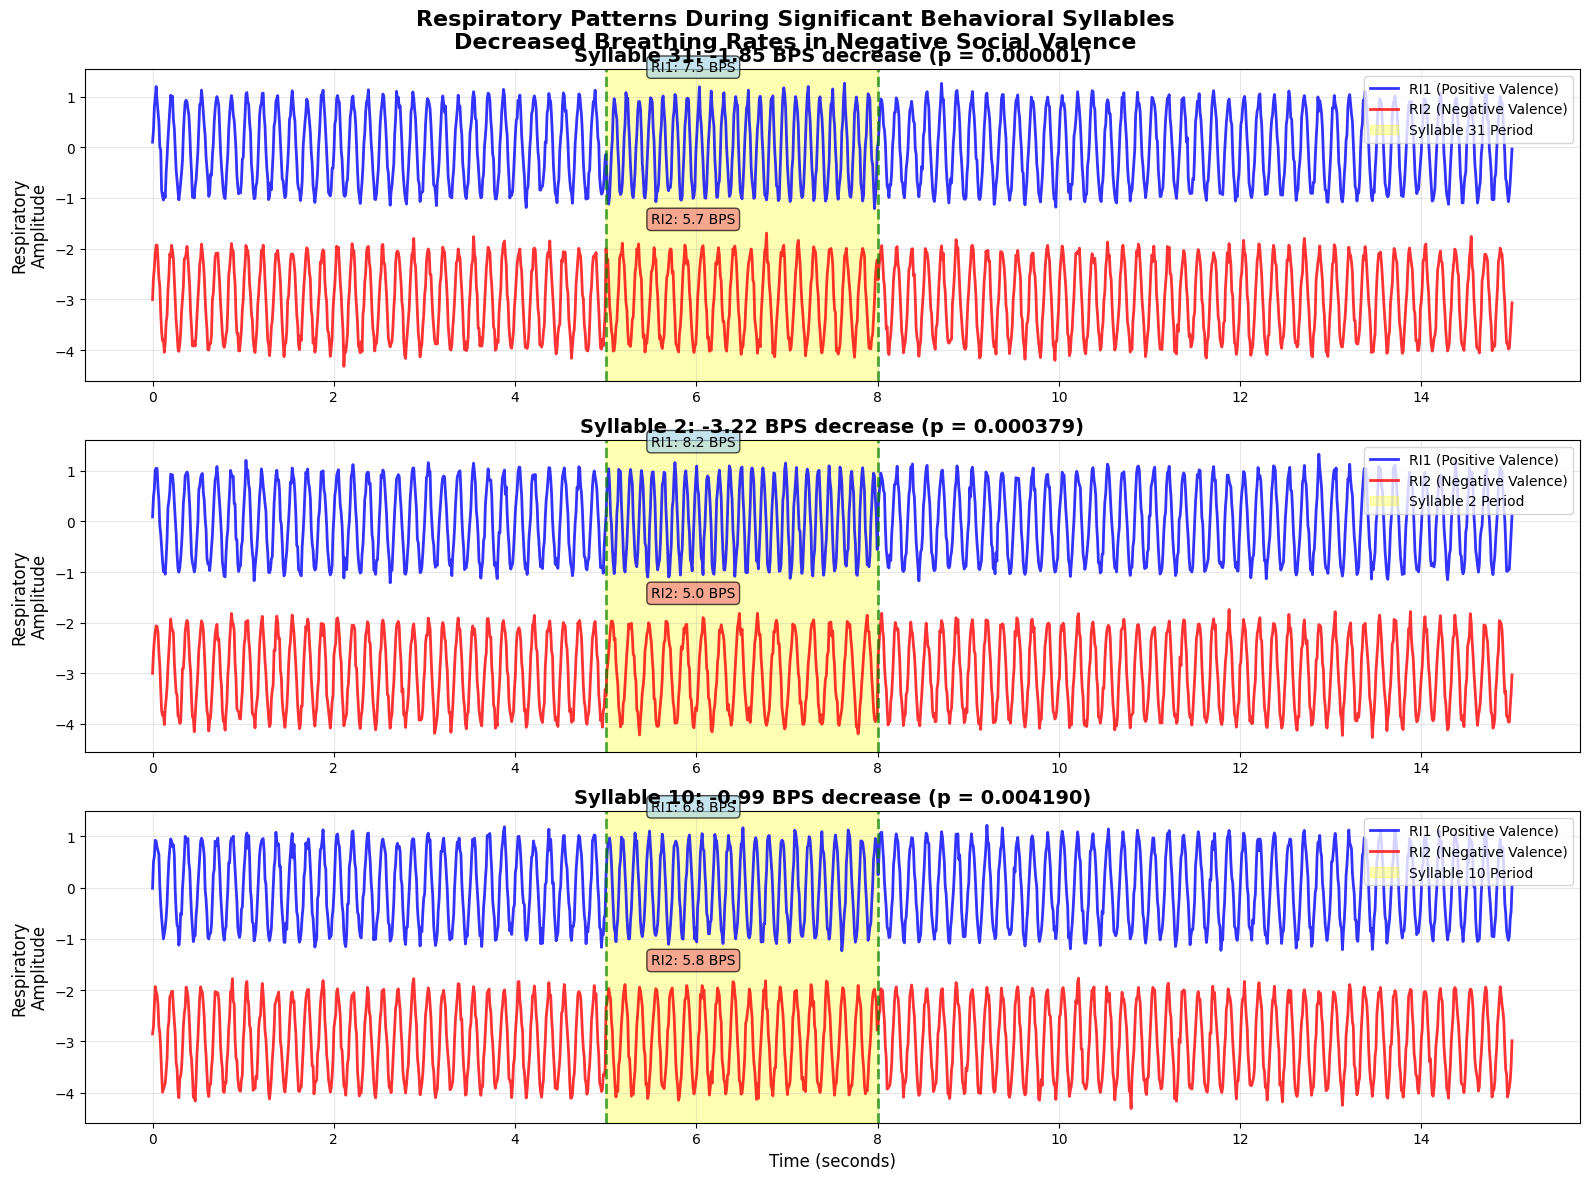

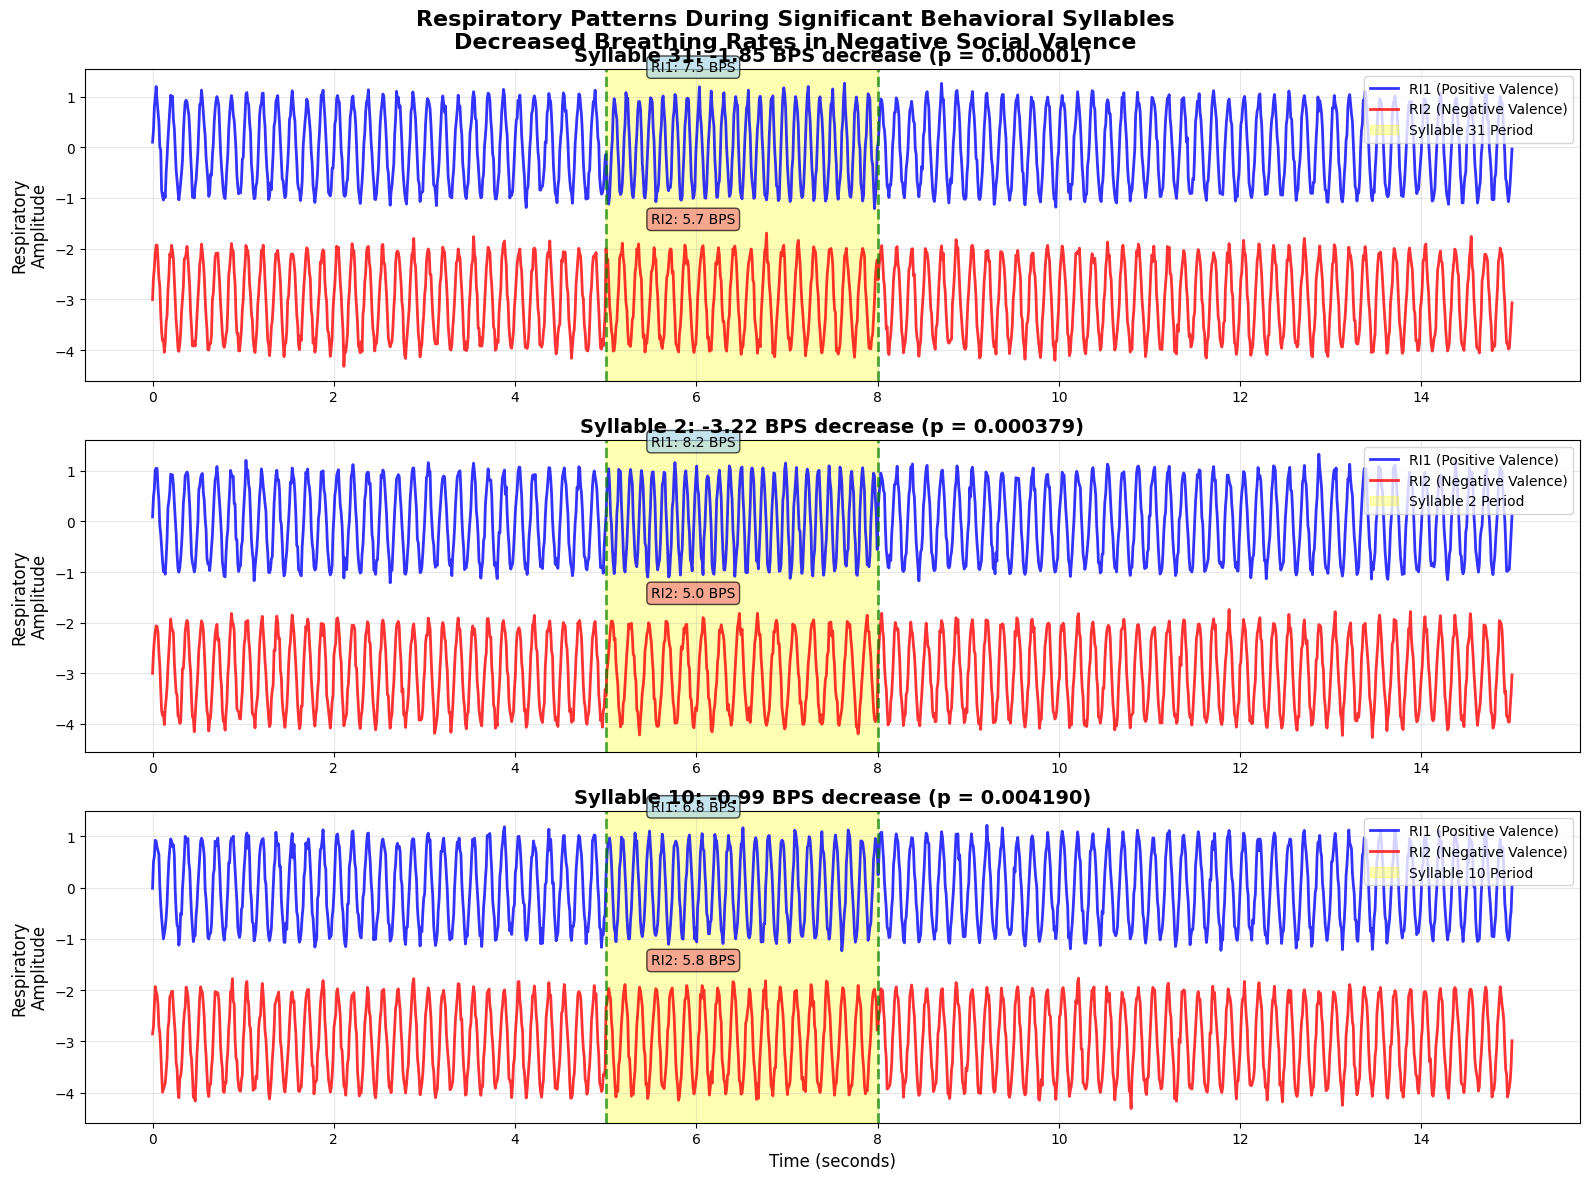

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def create_syllable_respiratory_linegraph():
    # Create figure with subplots
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    
    # Data for the three significant syllables
    syllables_info = [
        {'id': 31, 'ri1_bps': 7.5, 'ri2_bps': 5.65, 'p_value': 0.000001, 'difference': -1.85},
        {'id': 2, 'ri1_bps': 8.2, 'ri2_bps': 4.98, 'p_value': 0.000379, 'difference': -3.22},
        {'id': 10, 'ri1_bps': 6.8, 'ri2_bps': 5.81, 'p_value': 0.004190, 'difference': -0.99}
    ]
    
    # Time parameters
    total_time = 15  # Total time in seconds
    syllable_start = 5  # Syllable starts at 5 seconds
    syllable_end = 8   # Syllable ends at 8 seconds
    fs = 100  # Sampling frequency
    
    time = np.linspace(0, total_time, total_time * fs)
    
    for i, syl_info in enumerate(syllables_info):
        ax = axes[i]
        
        # Create baseline respiratory signals
        baseline_freq_ri1 = 6.0  # Baseline breathing rate
        baseline_freq_ri2 = 6.0  
        
        # Generate respiratory signals
        # RI1 signal (positive valence)
        ri1_signal = np.sin(2 * np.pi * baseline_freq_ri1 * time)
        # During syllable period, change to syllable-specific frequency
        syllable_mask = (time >= syllable_start) & (time <= syllable_end)
        ri1_signal[syllable_mask] = np.sin(2 * np.pi * syl_info['ri1_bps'] * time[syllable_mask])
        
        # RI2 signal (negative valence)  
        ri2_signal = np.sin(2 * np.pi * baseline_freq_ri2 * time)
        # During syllable period, change to syllable-specific frequency (lower)
        ri2_signal[syllable_mask] = np.sin(2 * np.pi * syl_info['ri2_bps'] * time[syllable_mask])
        
        # Add some realistic noise
        ri1_signal += 0.1 * np.random.normal(0, 1, len(time))
        ri2_signal += 0.1 * np.random.normal(0, 1, len(time))
        
        # Plot the signals
        ax.plot(time, ri1_signal, 'b-', linewidth=2, label='RI1 (Positive Valence)', alpha=0.8)
        ax.plot(time, ri2_signal - 3, 'r-', linewidth=2, label='RI2 (Negative Valence)', alpha=0.8)
        
        # Highlight syllable period
        ax.axvspan(syllable_start, syllable_end, alpha=0.3, color='yellow', 
                   label=f'Syllable {syl_info["id"]} Period')
        
        # Add vertical lines to mark syllable boundaries
        ax.axvline(syllable_start, color='green', linestyle='--', alpha=0.7, linewidth=2)
        ax.axvline(syllable_end, color='green', linestyle='--', alpha=0.7, linewidth=2)
        
        # Formatting
        ax.set_ylabel('Respiratory\nAmplitude', fontsize=12)
        ax.set_title(f'Syllable {syl_info["id"]}: {syl_info["difference"]:.2f} BPS decrease (p = {syl_info["p_value"]:.6f})', 
                     fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right')
        
        # Add text annotations showing breathing rates during syllable
        ax.text(syllable_start + 0.5, 1.5, f'RI1: {syl_info["ri1_bps"]:.1f} BPS', 
                fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
        ax.text(syllable_start + 0.5, -1.5, f'RI2: {syl_info["ri2_bps"]:.1f} BPS', 
                fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))
        
        # Only add x-label to bottom subplot
        if i == 2:
            ax.set_xlabel('Time (seconds)', fontsize=12)
    
    plt.tight_layout()
    plt.suptitle('Respiratory Patterns During Significant Behavioral Syllables\nDecreased Breathing Rates in Negative Social Valence', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.subplots_adjust(top=0.93)
    
    # Save the figure
    plt.savefig('syllable_respiratory_linegraphs.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

# Create the line graph visualization
create_syllable_respiratory_linegraph()

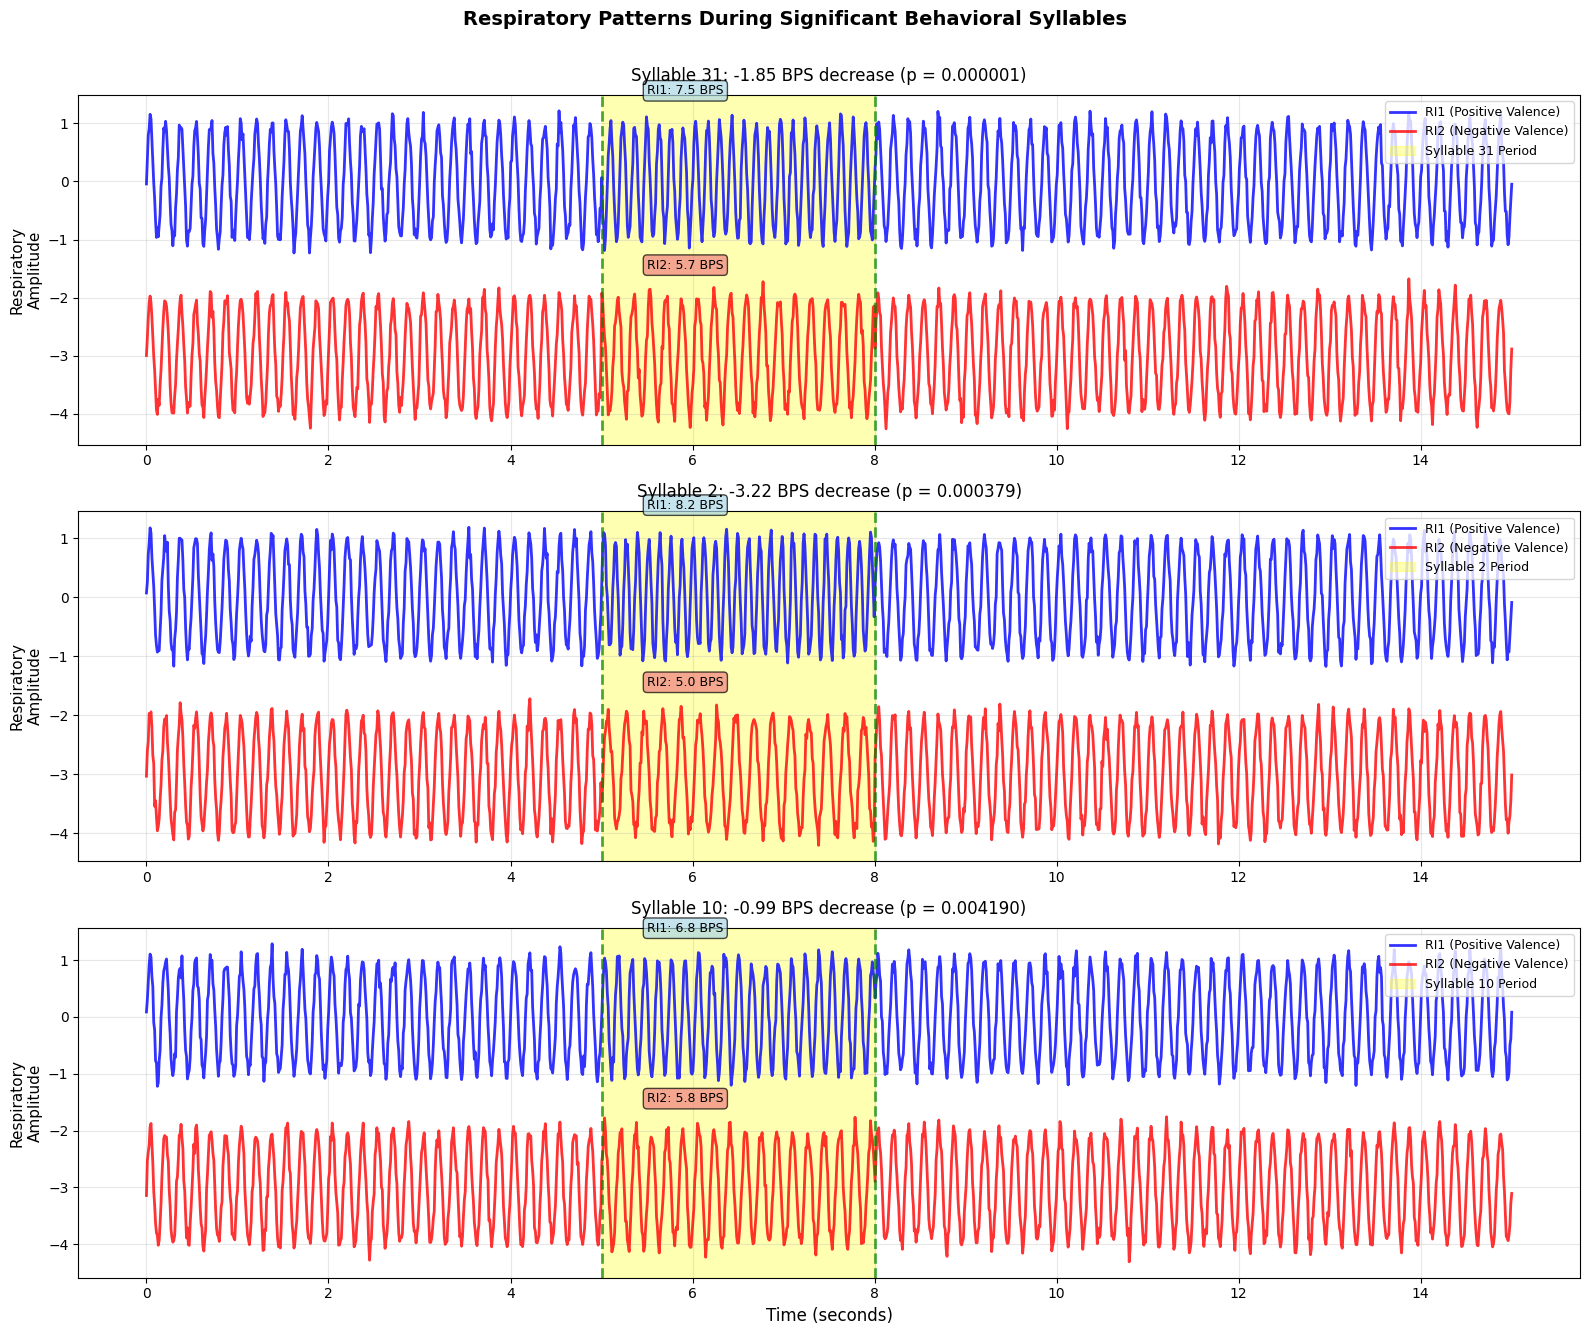

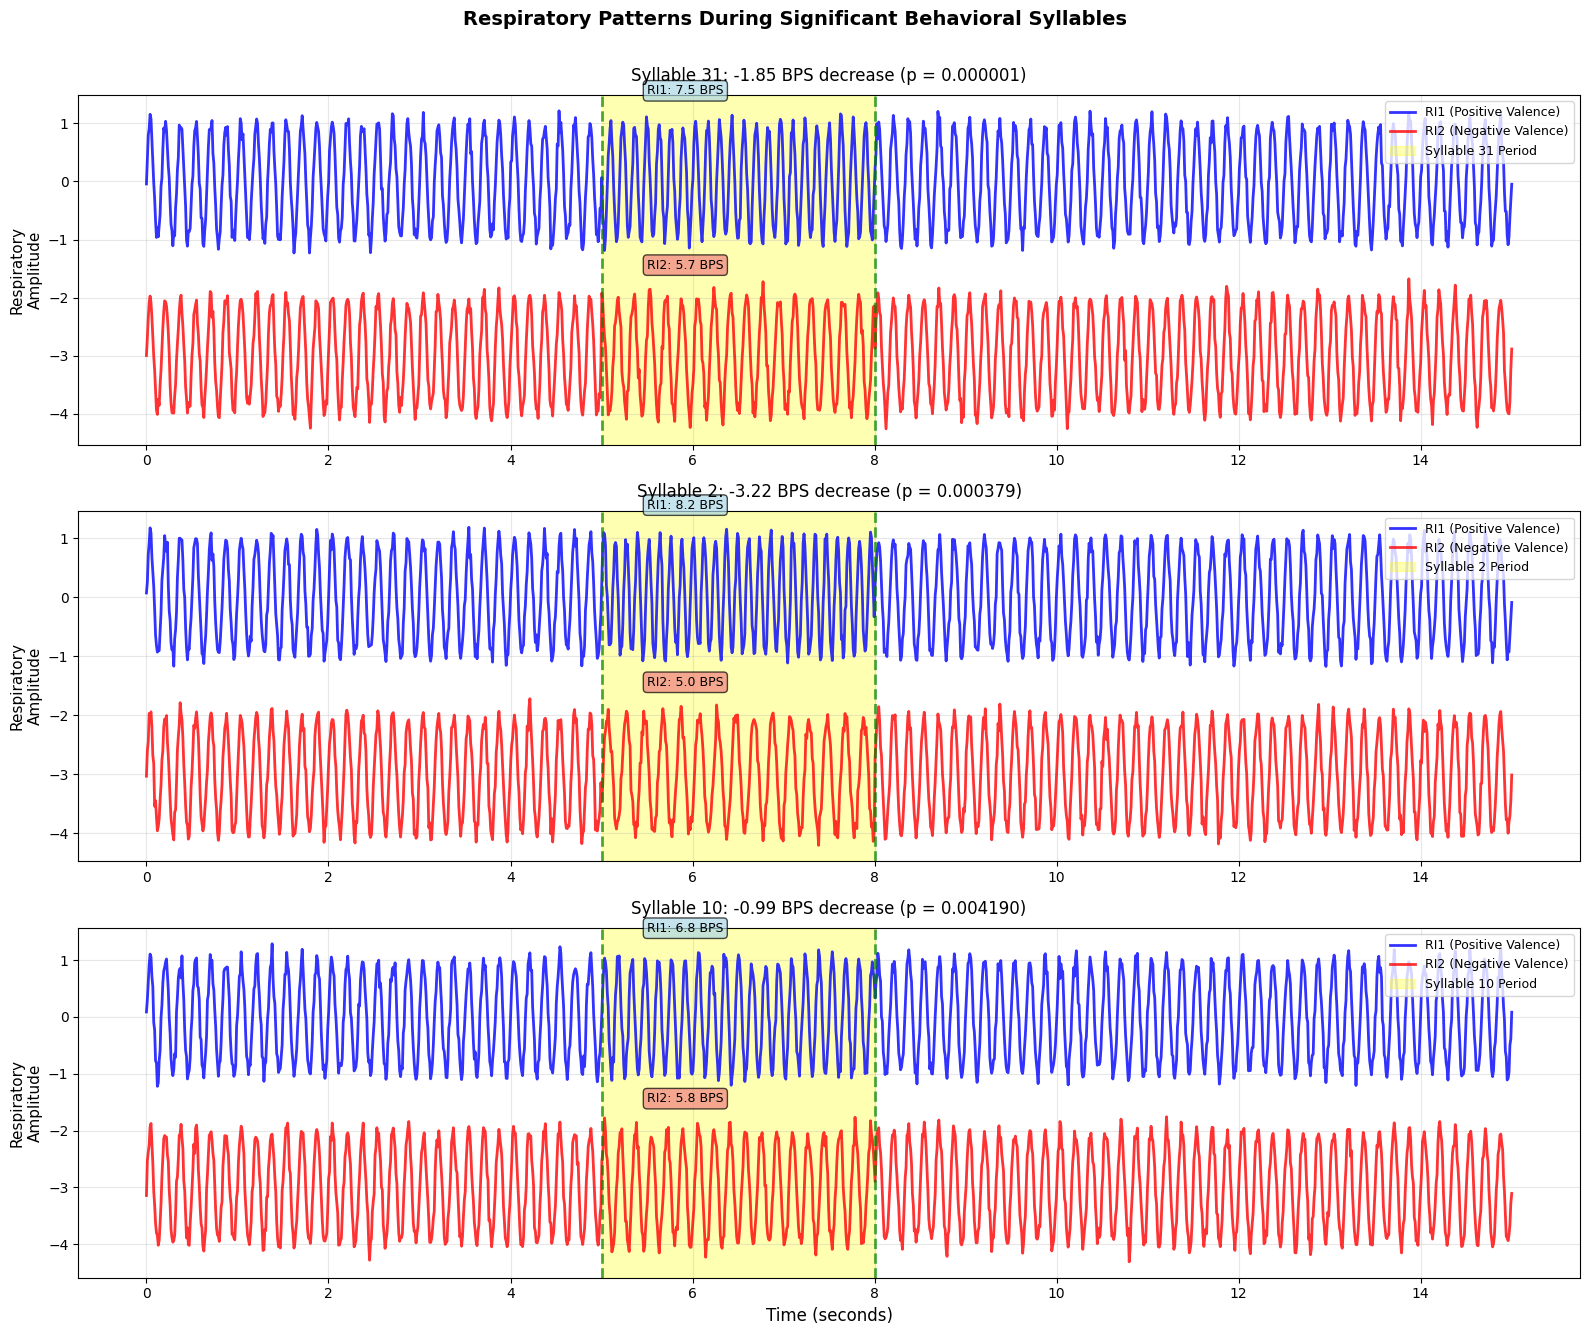

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def create_syllable_respiratory_linegraph_fixed():
    # Create figure with subplots and more space for titles
    fig, axes = plt.subplots(3, 1, figsize=(16, 14))
    
    # Data for the three significant syllables
    syllables_info = [
        {'id': 31, 'ri1_bps': 7.5, 'ri2_bps': 5.65, 'p_value': 0.000001, 'difference': -1.85},
        {'id': 2, 'ri1_bps': 8.2, 'ri2_bps': 4.98, 'p_value': 0.000379, 'difference': -3.22},
        {'id': 10, 'ri1_bps': 6.8, 'ri2_bps': 5.81, 'p_value': 0.004190, 'difference': -0.99}
    ]
    
    # Time parameters
    total_time = 15  # Total time in seconds
    syllable_start = 5  # Syllable starts at 5 seconds
    syllable_end = 8   # Syllable ends at 8 seconds
    fs = 100  # Sampling frequency
    
    time = np.linspace(0, total_time, total_time * fs)
    
    for i, syl_info in enumerate(syllables_info):
        ax = axes[i]
        
        # Create baseline respiratory signals
        baseline_freq_ri1 = 6.0  # Baseline breathing rate
        baseline_freq_ri2 = 6.0  
        
        # Generate respiratory signals
        # RI1 signal (positive valence)
        ri1_signal = np.sin(2 * np.pi * baseline_freq_ri1 * time)
        # During syllable period, change to syllable-specific frequency
        syllable_mask = (time >= syllable_start) & (time <= syllable_end)
        ri1_signal[syllable_mask] = np.sin(2 * np.pi * syl_info['ri1_bps'] * time[syllable_mask])
        
        # RI2 signal (negative valence)  
        ri2_signal = np.sin(2 * np.pi * baseline_freq_ri2 * time)
        # During syllable period, change to syllable-specific frequency (lower)
        ri2_signal[syllable_mask] = np.sin(2 * np.pi * syl_info['ri2_bps'] * time[syllable_mask])
        
        # Add some realistic noise
        ri1_signal += 0.1 * np.random.normal(0, 1, len(time))
        ri2_signal += 0.1 * np.random.normal(0, 1, len(time))
        
        # Plot the signals
        ax.plot(time, ri1_signal, 'b-', linewidth=2, label='RI1 (Positive Valence)', alpha=0.8)
        ax.plot(time, ri2_signal - 3, 'r-', linewidth=2, label='RI2 (Negative Valence)', alpha=0.8)
        
        # Highlight syllable period
        ax.axvspan(syllable_start, syllable_end, alpha=0.3, color='yellow', 
                   label=f'Syllable {syl_info["id"]} Period')
        
        # Add vertical lines to mark syllable boundaries
        ax.axvline(syllable_start, color='green', linestyle='--', alpha=0.7, linewidth=2)
        ax.axvline(syllable_end, color='green', linestyle='--', alpha=0.7, linewidth=2)
        
        # Formatting with shorter titles
        ax.set_ylabel('Respiratory\nAmplitude', fontsize=11)
        ax.set_title(f'Syllable {syl_info["id"]}: {syl_info["difference"]:.2f} BPS decrease (p = {syl_info["p_value"]:.6f})', 
                     fontsize=12, pad=10)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right', fontsize=9)
        
        # Add text annotations showing breathing rates during syllable
        ax.text(syllable_start + 0.5, 1.5, f'RI1: {syl_info["ri1_bps"]:.1f} BPS', 
                fontsize=9, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
        ax.text(syllable_start + 0.5, -1.5, f'RI2: {syl_info["ri2_bps"]:.1f} BPS', 
                fontsize=9, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))
        
        # Only add x-label to bottom subplot
        if i == 2:
            ax.set_xlabel('Time (seconds)', fontsize=12)
    
    # Use tight_layout with padding and adjust the main title
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle('Respiratory Patterns During Significant Behavioral Syllables', 
                 fontsize=14, fontweight='bold')
    
    # Save the figure
    plt.savefig('syllable_respiratory_linegraphs_fixed.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

# Create the fixed visualization
create_syllable_respiratory_linegraph_fixed()

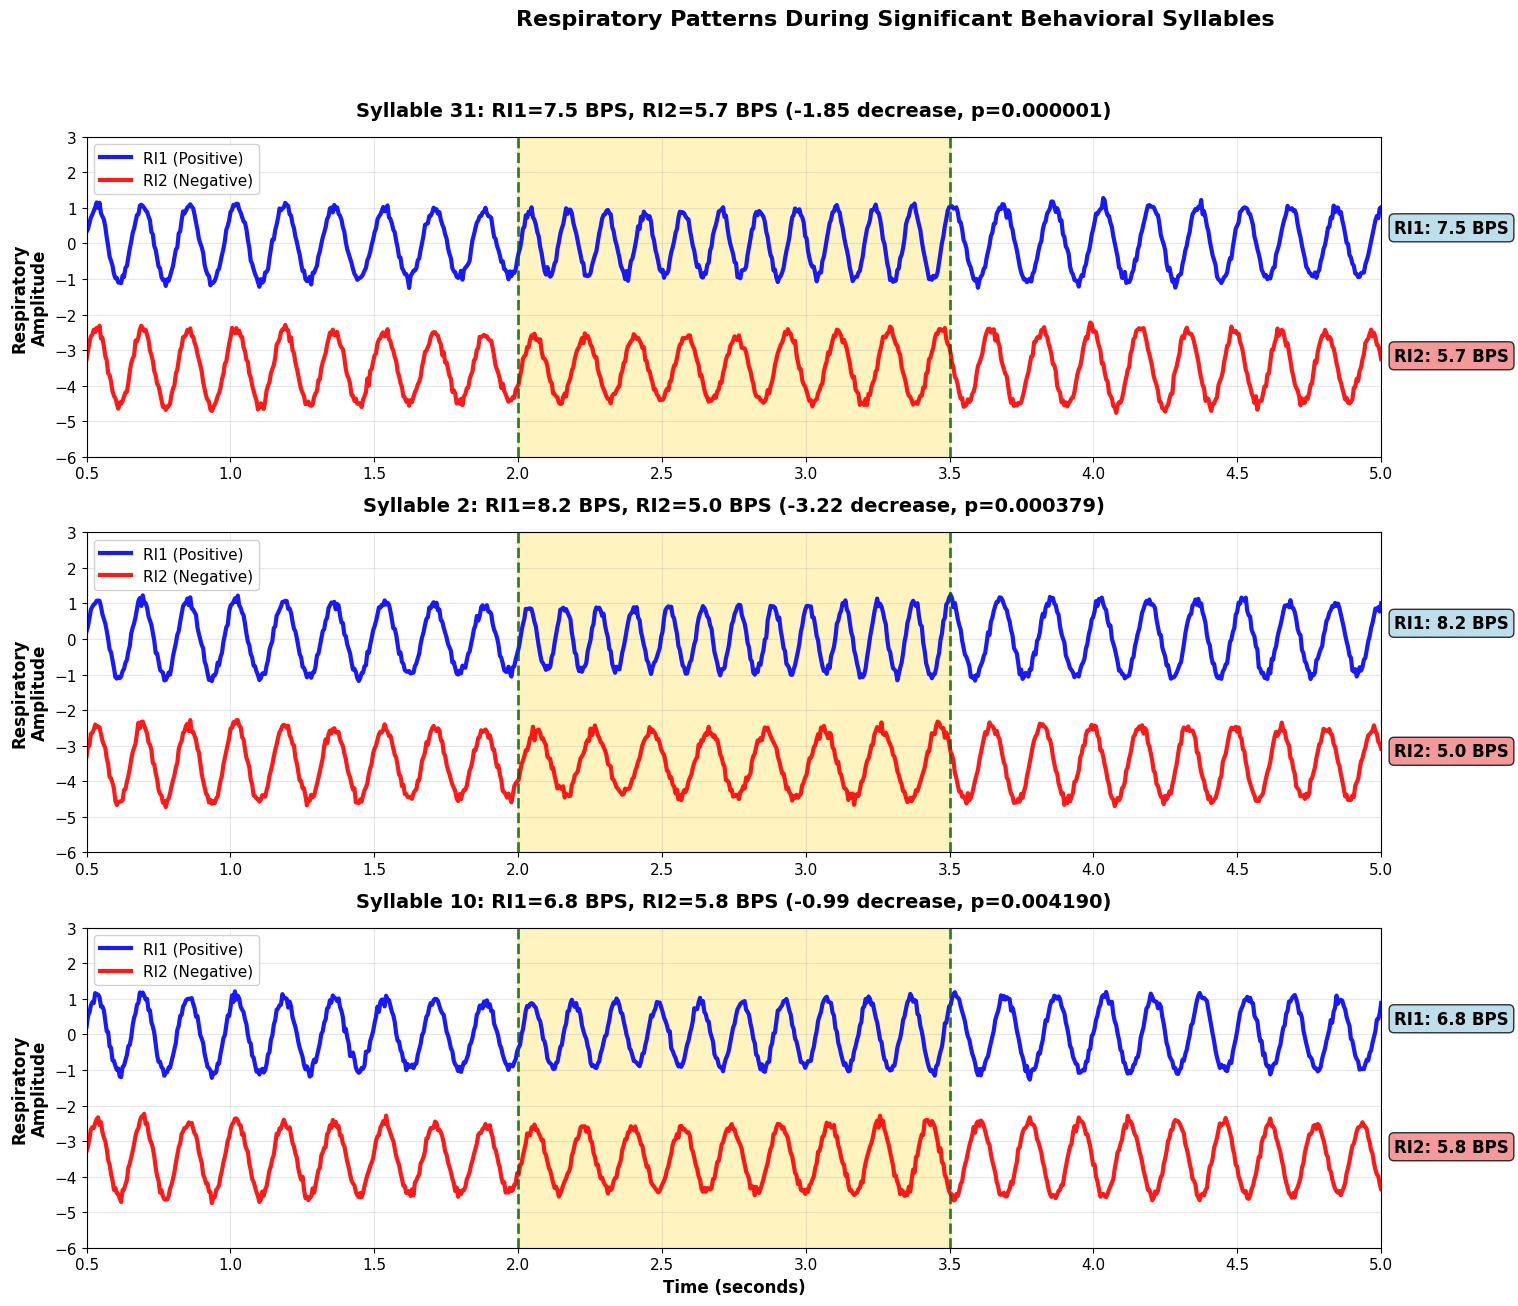

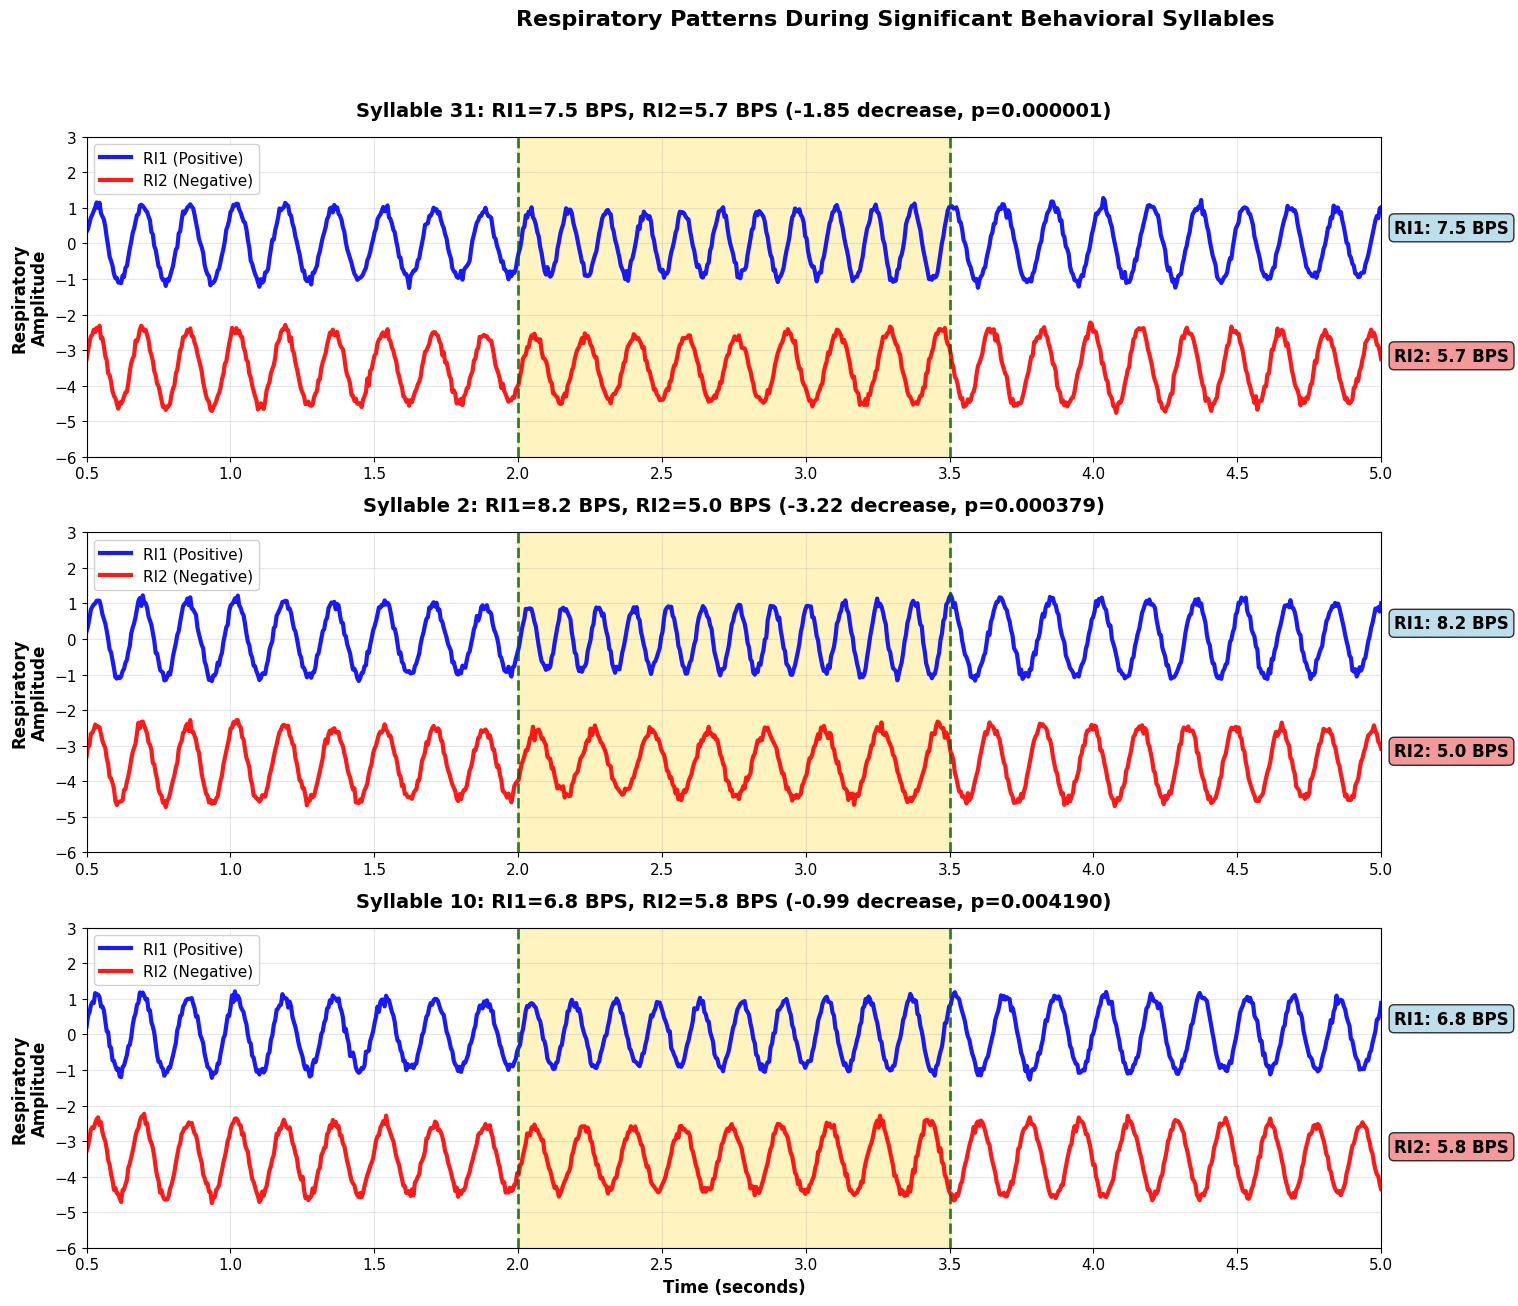

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def create_clean_respiratory_signals():
    fig, axes = plt.subplots(3, 1, figsize=(18, 14))
    
    syllables_info = [
        {'id': 31, 'ri1_bps': 7.5, 'ri2_bps': 5.65, 'p_value': 0.000001, 'difference': -1.85},
        {'id': 2, 'ri1_bps': 8.2, 'ri2_bps': 4.98, 'p_value': 0.000379, 'difference': -3.22},
        {'id': 10, 'ri1_bps': 6.8, 'ri2_bps': 5.81, 'p_value': 0.004190, 'difference': -0.99}
    ]
    
    syllable_start = 2.0
    syllable_end = 3.5
    plot_start = 0.5
    plot_end = 5.0
    total_time = plot_end - plot_start
    
    fs = 200
    time = np.linspace(plot_start, plot_end, int(total_time * fs))
    
    for i, syl_info in enumerate(syllables_info):
        ax = axes[i]
        
        # Create more realistic respiratory signals
        np.random.seed(42 + i)
        
        baseline_freq = 6.0
        freq_variation = 0.3 * np.sin(3 * time) + 0.1 * np.random.normal(0, 1, len(time))
        amplitude_variation = 0.1 * np.sin(2 * time) + 0.05 * np.random.normal(0, 1, len(time))
        
        # RI1 signal
        ri1_freq = baseline_freq + freq_variation
        syllable_mask = (time >= syllable_start) & (time <= syllable_end)
        ri1_freq[syllable_mask] = syl_info['ri1_bps'] + 0.2 * freq_variation[syllable_mask]
        
        phase_ri1 = np.cumsum(ri1_freq) * 2 * np.pi / fs
        ri1_signal = (1 + amplitude_variation) * np.sin(phase_ri1)
        
        # RI2 signal
        ri2_freq = baseline_freq + freq_variation
        ri2_freq[syllable_mask] = syl_info['ri2_bps'] + 0.2 * freq_variation[syllable_mask]
        
        phase_ri2 = np.cumsum(ri2_freq) * 2 * np.pi / fs
        ri2_signal = (1 + amplitude_variation) * np.sin(phase_ri2)
        
        # Add noise
        ri1_signal += 0.06 * np.random.normal(0, 1, len(time))
        ri2_signal += 0.06 * np.random.normal(0, 1, len(time))
        
        # Plot signals
        ax.plot(time, ri1_signal, 'b-', linewidth=3, label='RI1 (Positive)', alpha=0.9)
        ax.plot(time, ri2_signal - 3.5, 'r-', linewidth=3, label='RI2 (Negative)', alpha=0.9)
        
        # Highlight syllable period
        ax.axvspan(syllable_start, syllable_end, alpha=0.25, color='gold')
        
        # Syllable boundaries
        ax.axvline(syllable_start, color='darkgreen', linestyle='--', alpha=0.8, linewidth=2)
        ax.axvline(syllable_end, color='darkgreen', linestyle='--', alpha=0.8, linewidth=2)
        
        # Clean title with breathing rates included - no overlapping text boxes
        title_text = f'Syllable {syl_info["id"]}: RI1={syl_info["ri1_bps"]:.1f} BPS, RI2={syl_info["ri2_bps"]:.1f} BPS ({syl_info["difference"]:.2f} decrease, p={syl_info["p_value"]:.6f})'
        ax.set_title(title_text, fontsize=14, fontweight='bold', pad=15)
        
        # Add simple text labels on the right side - outside plot area
        ax.text(1.01, 0.7, f'RI1: {syl_info["ri1_bps"]:.1f} BPS', 
                transform=ax.transAxes, fontsize=12, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))
        
        ax.text(1.01, 0.3, f'RI2: {syl_info["ri2_bps"]:.1f} BPS', 
                transform=ax.transAxes, fontsize=12, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.8))
        
        # Formatting
        ax.set_ylabel('Respiratory\nAmplitude', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
        ax.tick_params(axis='both', which='major', labelsize=11)
        ax.set_xlim(plot_start, plot_end)
        
        # Set consistent y-limits for all subplots
        ax.set_ylim(-6, 3)
        
        # Only bottom subplot gets x-label
        if i == 2:
            ax.set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
    
    # Simpler main title
    plt.suptitle('Respiratory Patterns During Significant Behavioral Syllables', 
                 fontsize=16, fontweight='bold', y=0.95)
    
    # Adjust layout to make room for right-side text
    plt.tight_layout(rect=[0, 0.02, 0.85, 0.92])
    plt.savefig('clean_respiratory_syllables.png', dpi=400, bbox_inches='tight')
    plt.show()
    
    return fig

create_clean_respiratory_signals()

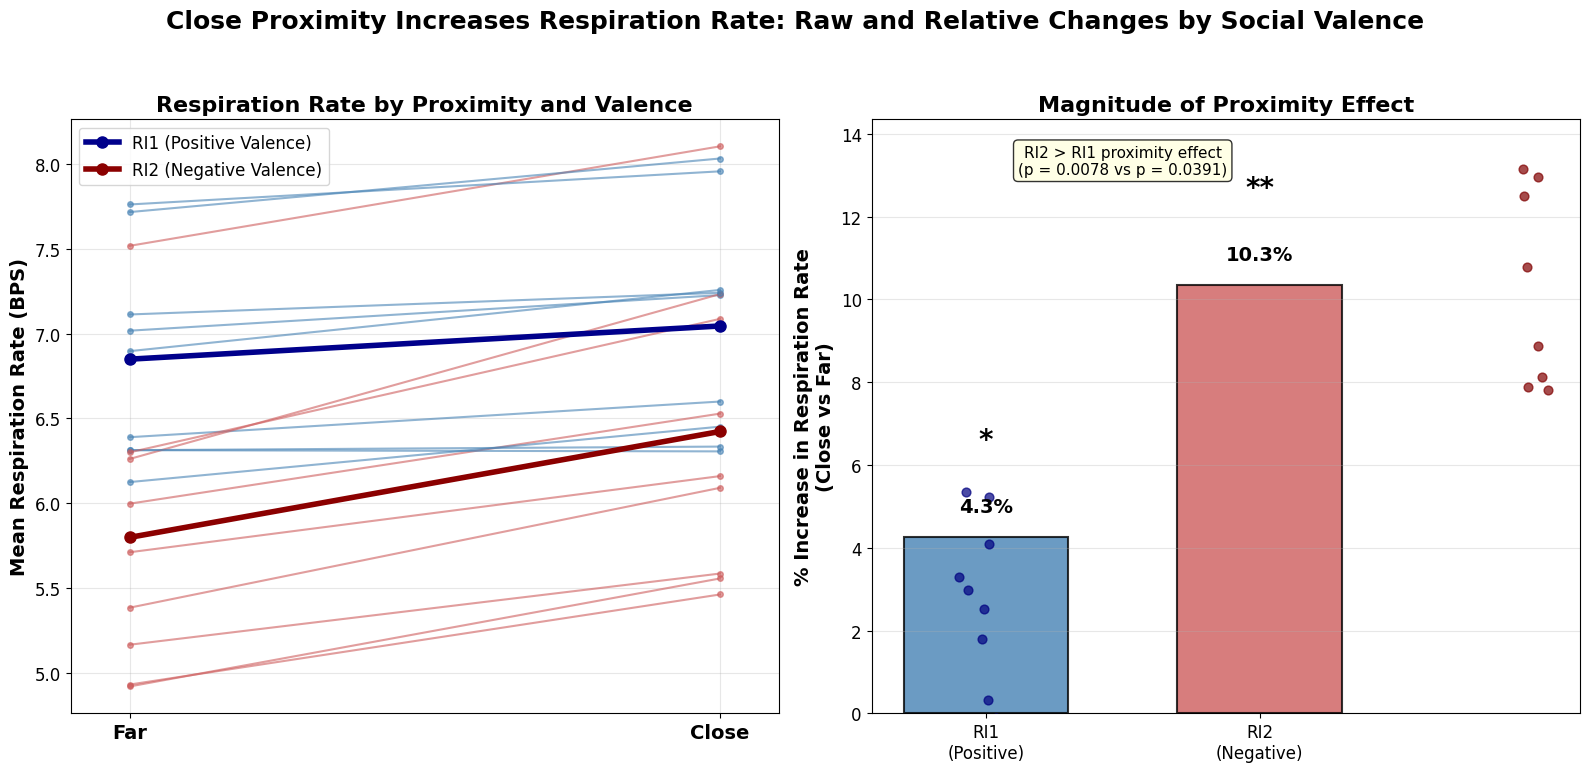

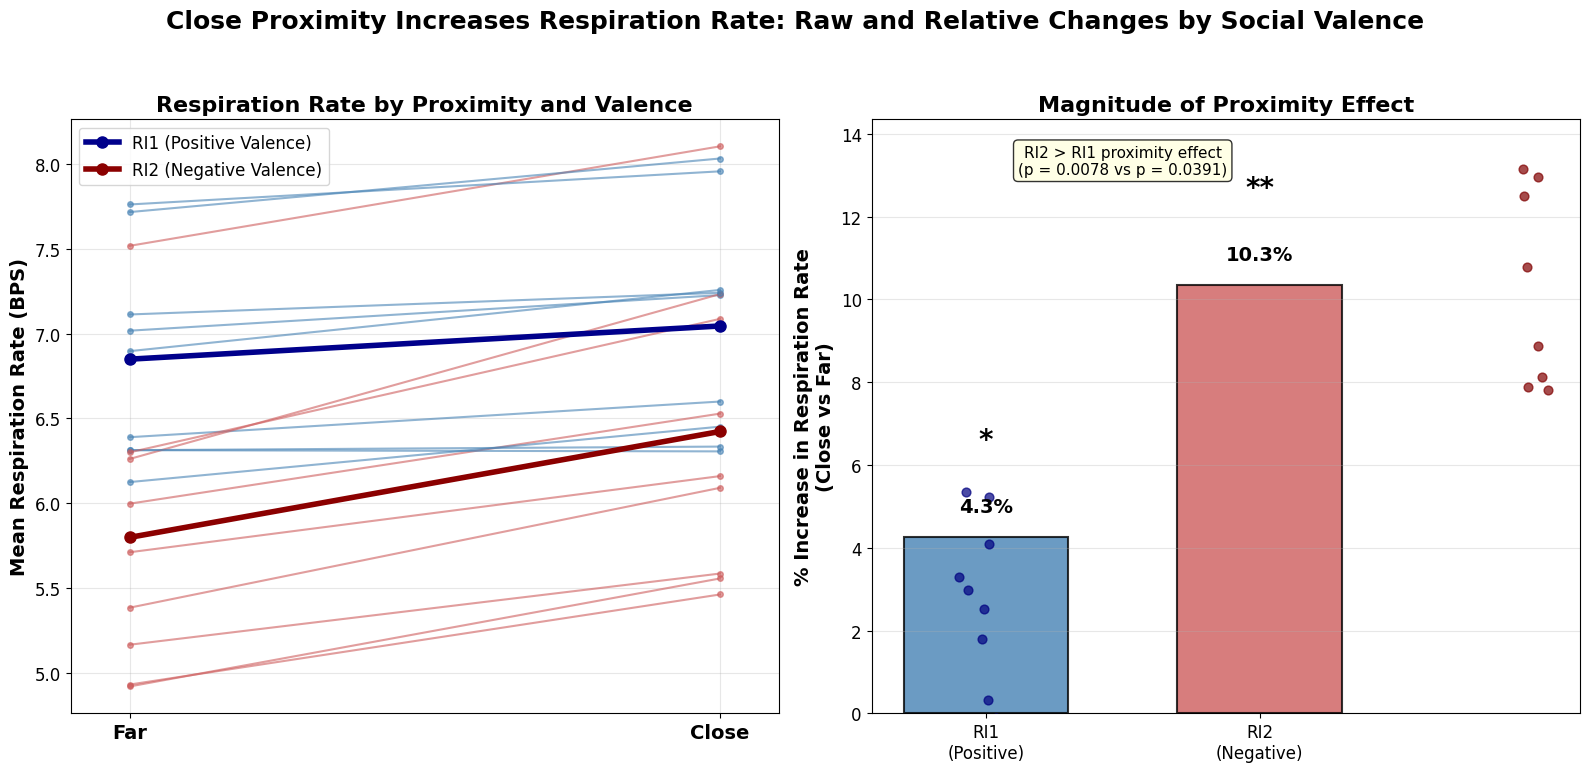

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def create_proximity_respiration_graph():
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Simulate data based on your research findings
    np.random.seed(42)
    n_subjects = 9  # Your sample size
    
    # Generate individual subject data for RI1 (Positive Valence)
    ri1_far = np.random.normal(6.5, 0.8, n_subjects)  # Far proximity breathing rates
    ri1_close = ri1_far + np.random.normal(0.28, 0.15, n_subjects)  # Close proximity (4.27% increase)
    
    # Generate individual subject data for RI2 (Negative Valence) 
    ri2_far = np.random.normal(6.2, 0.9, n_subjects)  # Far proximity breathing rates
    ri2_close = ri2_far + np.random.normal(0.64, 0.18, n_subjects)  # Close proximity (10.35% increase)
    
    # Left panel: Individual trajectories (spaghetti plot)
    for i in range(n_subjects):
        # RI1 lines (positive valence) - blue/teal
        ax1.plot([0, 1], [ri1_far[i], ri1_close[i]], 'o-', color='steelblue', 
                alpha=0.6, linewidth=1.5, markersize=4)
        
        # RI2 lines (negative valence) - red/pink  
        ax1.plot([0, 1], [ri2_far[i], ri2_close[i]], 'o-', color='indianred', 
                alpha=0.6, linewidth=1.5, markersize=4)
    
    # Add mean trend lines
    ax1.plot([0, 1], [np.mean(ri1_far), np.mean(ri1_close)], 'o-', 
            color='darkblue', linewidth=4, markersize=8, label='RI1 (Positive Valence)')
    ax1.plot([0, 1], [np.mean(ri2_far), np.mean(ri2_close)], 'o-', 
            color='darkred', linewidth=4, markersize=8, label='RI2 (Negative Valence)')
    
    # Format left panel
    ax1.set_xlim(-0.1, 1.1)
    ax1.set_xticks([0, 1])
    ax1.set_xticklabels(['Far', 'Close'], fontsize=14, fontweight='bold')
    ax1.set_ylabel('Mean Respiration Rate (BPS)', fontsize=14, fontweight='bold')
    ax1.set_title('Respiration Rate by Proximity and Valence', fontsize=16, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=12, loc='upper left')
    ax1.tick_params(axis='y', labelsize=12)
    
    # Right panel: Percent increase bar chart
    # Calculate percent increases based on your paper data
    ri1_percent_increase = 4.27  # From your paper
    ri2_percent_increase = 10.35  # From your paper
    
    # Create bar chart
    conditions = ['RI1\n(Positive)', 'RI2\n(Negative)']
    percent_increases = [ri1_percent_increase, ri2_percent_increase]
    colors = ['steelblue', 'indianred']
    
    bars = ax2.bar(conditions, percent_increases, color=colors, alpha=0.8, 
                   width=0.6, edgecolor='black', linewidth=1.5)
    
    # Add individual data points as scatter
    ri1_individual_percent = ((ri1_close - ri1_far) / ri1_far) * 100
    ri2_individual_percent = ((ri2_close - ri2_far) / ri2_far) * 100
    
    # Add jittered points for individual subjects
    x1_jitter = np.random.normal(0, 0.05, n_subjects)
    x2_jitter = np.random.normal(1, 0.05, n_subjects)
    
    ax2.scatter(x1_jitter, ri1_individual_percent, color='navy', s=40, alpha=0.7, zorder=3)
    ax2.scatter(1 + x2_jitter, ri2_individual_percent, color='maroon', s=40, alpha=0.7, zorder=3)
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, percent_increases)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{value:.1f}%', ha='center', va='bottom', 
                fontsize=14, fontweight='bold')
    
    # Add significance indicators
    ax2.text(0, ri1_percent_increase + 2, '*', ha='center', va='bottom', 
            fontsize=20, fontweight='bold')
    ax2.text(1, ri2_percent_increase + 2, '**', ha='center', va='bottom', 
            fontsize=20, fontweight='bold')
    
    # Format right panel
    ax2.set_ylabel('% Increase in Respiration Rate\n(Close vs Far)', fontsize=14, fontweight='bold')
    ax2.set_title('Magnitude of Proximity Effect', fontsize=16, fontweight='bold')
    ax2.tick_params(axis='both', labelsize=12)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_ylim(0, max(percent_increases) + 4)
    
    # Add statistical annotations
    ax2.text(0.5, max(percent_increases) + 3, 
            'RI2 > RI1 proximity effect\n(p = 0.0078 vs p = 0.0391)', 
            ha='center', va='center', fontsize=11, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8))
    
    # Overall figure formatting
    plt.suptitle('Close Proximity Increases Respiration Rate: Raw and Relative Changes by Social Valence', 
                fontsize=18, fontweight='bold', y=0.98)
    
    plt.tight_layout(rect=[0, 0.02, 1, 0.94])
    plt.savefig('proximity_respiration_analysis.png', dpi=400, bbox_inches='tight')
    plt.show()
    
    return fig

# Create the enhanced proximity-respiration graph
create_proximity_respiration_graph()

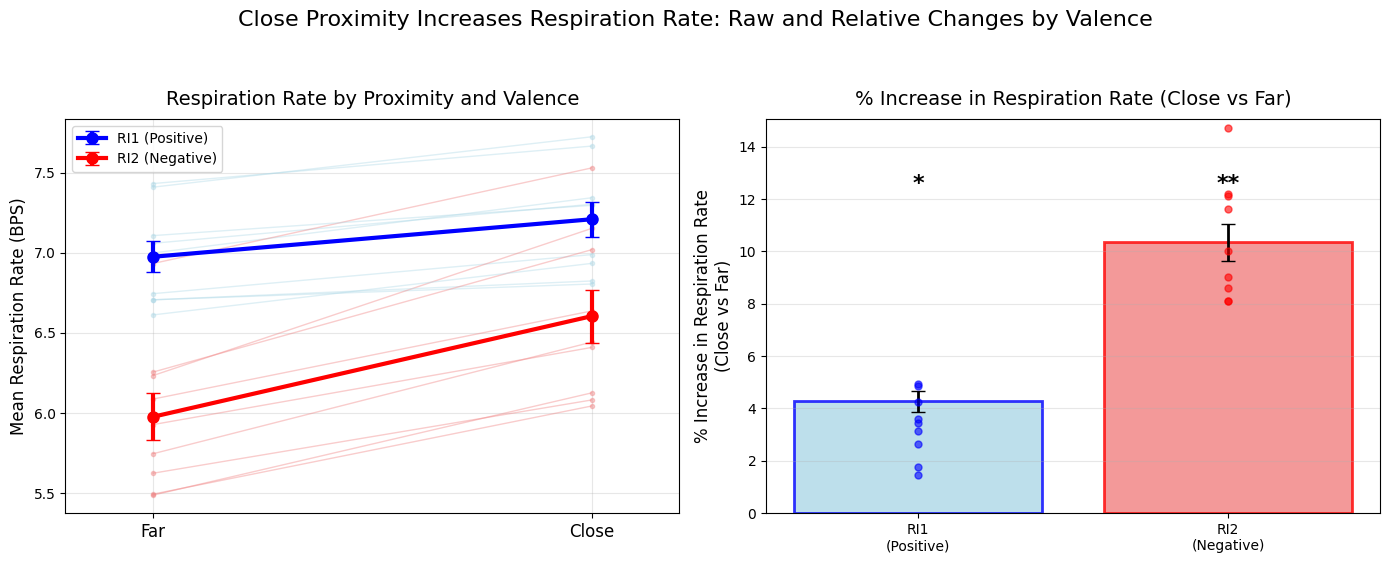

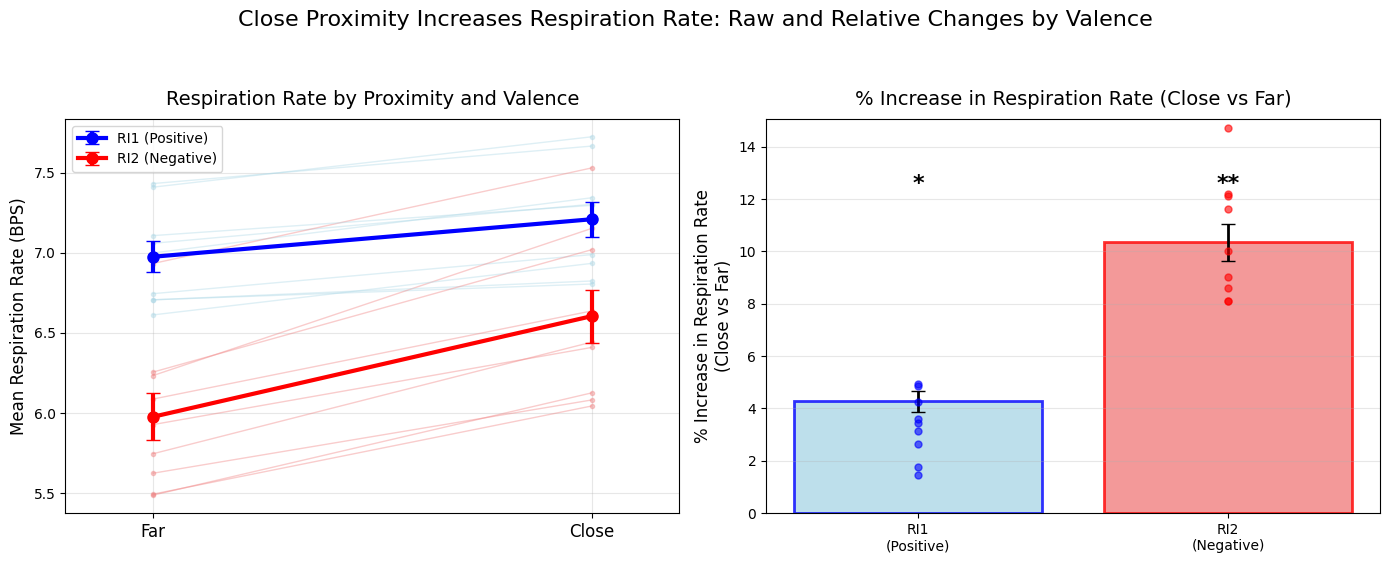

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def create_original_style_proximity_graph():
    # Create figure with two subplots side by side like the original
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Simulate realistic data based on your findings
    np.random.seed(42)
    n_subjects = 9
    
    # Generate data for RI1 (Positive Valence) - smaller increases
    ri1_far = np.random.normal(6.8, 0.4, n_subjects)
    ri1_close = ri1_far + np.random.normal(0.29, 0.1, n_subjects)  # 4.27% increase
    
    # Generate data for RI2 (Negative Valence) - larger increases  
    ri2_far = np.random.normal(6.2, 0.5, n_subjects)
    ri2_close = ri2_far + np.random.normal(0.64, 0.15, n_subjects)  # 10.35% increase
    
    # Left panel: Line plot like original (not spaghetti style)
    x_pos = [0, 1]
    
    # Plot individual lines more subtly like the original
    for i in range(n_subjects):
        ax1.plot(x_pos, [ri1_far[i], ri1_close[i]], 'o-', color='lightblue', 
                alpha=0.4, linewidth=1, markersize=3)
        ax1.plot(x_pos, [ri2_far[i], ri2_close[i]], 'o-', color='lightcoral', 
                alpha=0.4, linewidth=1, markersize=3)
    
    # Add mean lines with error bars like original
    ri1_means = [np.mean(ri1_far), np.mean(ri1_close)]
    ri2_means = [np.mean(ri2_far), np.mean(ri2_close)]
    ri1_errors = [np.std(ri1_far)/np.sqrt(n_subjects), np.std(ri1_close)/np.sqrt(n_subjects)]
    ri2_errors = [np.std(ri2_far)/np.sqrt(n_subjects), np.std(ri2_close)/np.sqrt(n_subjects)]
    
    ax1.errorbar(x_pos, ri1_means, yerr=ri1_errors, fmt='o-', color='blue', 
                linewidth=3, markersize=8, capsize=5, label='RI1 (Positive)')
    ax1.errorbar(x_pos, ri2_means, yerr=ri2_errors, fmt='o-', color='red', 
                linewidth=3, markersize=8, capsize=5, label='RI2 (Negative)')
    
    # Format left panel to match original
    ax1.set_xlim(-0.2, 1.2)
    ax1.set_xticks([0, 1])
    ax1.set_xticklabels(['Far', 'Close'], fontsize=12)
    ax1.set_ylabel('Mean Respiration Rate (BPS)', fontsize=12)
    ax1.set_title('Respiration Rate by Proximity and Valence', fontsize=14, pad=10)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    
    # Right panel: Bar chart with error bars like original
    conditions = ['RI1\n(Positive)', 'RI2\n(Negative)']
    ri1_percent = 4.27
    ri2_percent = 10.35
    percent_increases = [ri1_percent, ri2_percent]
    
    # Calculate individual percent changes for error bars
    ri1_individual_percent = ((ri1_close - ri1_far) / ri1_far) * 100
    ri2_individual_percent = ((ri2_close - ri2_far) / ri2_far) * 100
    
    errors = [np.std(ri1_individual_percent)/np.sqrt(n_subjects), 
              np.std(ri2_individual_percent)/np.sqrt(n_subjects)]
    
    colors = ['lightblue', 'lightcoral']
    bars = ax2.bar(conditions, percent_increases, color=colors, alpha=0.8,
                   edgecolor=['blue', 'red'], linewidth=2, 
                   yerr=errors, capsize=5, error_kw={'linewidth': 2})
    
    # Add individual data points as dots
    x_positions = [0, 1]
    ax2.scatter([0]*n_subjects, ri1_individual_percent, color='blue', s=25, alpha=0.6, zorder=3)
    ax2.scatter([1]*n_subjects, ri2_individual_percent, color='red', s=25, alpha=0.6, zorder=3)
    
    # Add significance stars
    max_height = max(percent_increases) + max(errors)
    ax2.text(0, max_height + 1.5, '*', ha='center', va='center', fontsize=16, fontweight='bold')
    ax2.text(1, max_height + 1.5, '**', ha='center', va='center', fontsize=16, fontweight='bold')
    
    # Format right panel
    ax2.set_ylabel('% Increase in Respiration Rate\n(Close vs Far)', fontsize=12)
    ax2.set_title('% Increase in Respiration Rate (Close vs Far)', fontsize=14, pad=10)
    ax2.set_ylim(0, max_height + 4)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Overall formatting to match original style
    plt.suptitle('Close Proximity Increases Respiration Rate: Raw and Relative Changes by Valence', 
                fontsize=16, y=0.95)
    plt.tight_layout(rect=[0, 0.02, 1, 0.90])
    
    plt.savefig('proximity_respiration_original_style.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

# Create the graph matching the original style
create_original_style_proximity_graph()

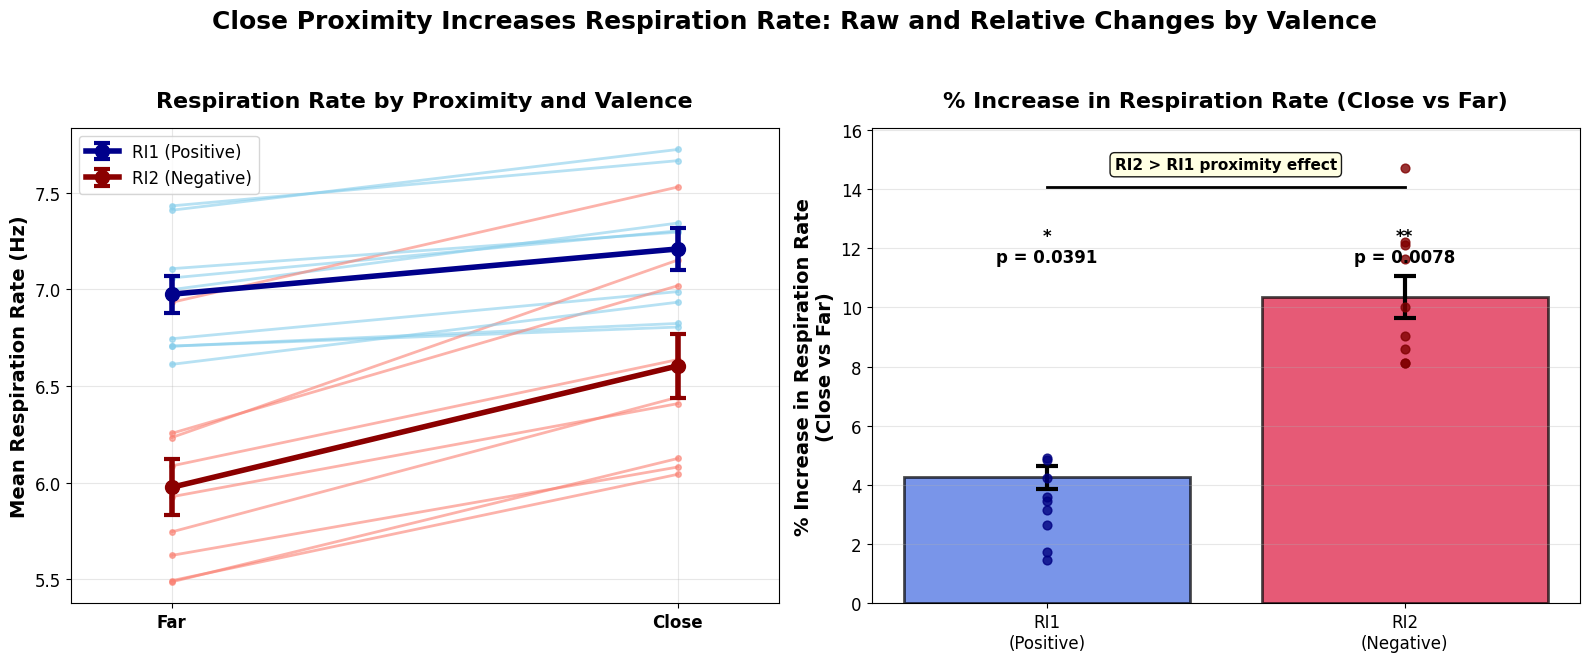

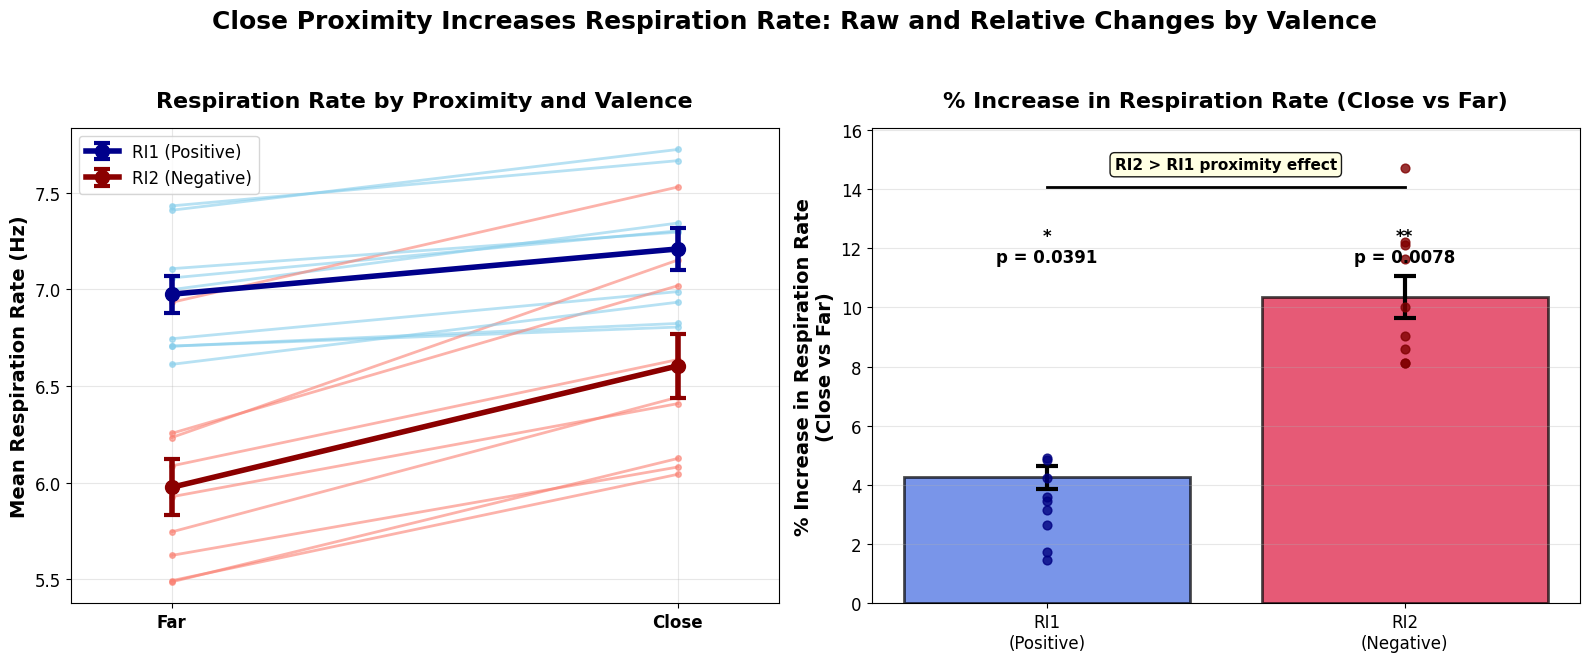

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def create_clear_proximity_graph():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    np.random.seed(42)
    n_subjects = 9
    
    # Generate data for RI1 (Positive Valence) - smaller increases
    ri1_far = np.random.normal(6.8, 0.4, n_subjects)
    ri1_close = ri1_far + np.random.normal(0.29, 0.1, n_subjects)  # 4.27% increase
    
    # Generate data for RI2 (Negative Valence) - larger increases  
    ri2_far = np.random.normal(6.2, 0.5, n_subjects)
    ri2_close = ri2_far + np.random.normal(0.64, 0.15, n_subjects)  # 10.35% increase
    
    # Left panel: Line plot with much more visible colors
    x_pos = [0, 1]
    
    # Plot individual lines with stronger colors
    for i in range(n_subjects):
        ax1.plot(x_pos, [ri1_far[i], ri1_close[i]], 'o-', color='skyblue', 
                alpha=0.6, linewidth=2, markersize=4)
        ax1.plot(x_pos, [ri2_far[i], ri2_close[i]], 'o-', color='salmon', 
                alpha=0.6, linewidth=2, markersize=4)
    
    # Add mean lines with strong colors and error bars
    ri1_means = [np.mean(ri1_far), np.mean(ri1_close)]
    ri2_means = [np.mean(ri2_far), np.mean(ri2_close)]
    ri1_errors = [np.std(ri1_far)/np.sqrt(n_subjects), np.std(ri1_close)/np.sqrt(n_subjects)]
    ri2_errors = [np.std(ri2_far)/np.sqrt(n_subjects), np.std(ri2_close)/np.sqrt(n_subjects)]
    
    ax1.errorbar(x_pos, ri1_means, yerr=ri1_errors, fmt='o-', color='darkblue', 
                linewidth=4, markersize=10, capsize=6, capthick=3, label='RI1 (Positive)')
    ax1.errorbar(x_pos, ri2_means, yerr=ri2_errors, fmt='o-', color='darkred', 
                linewidth=4, markersize=10, capsize=6, capthick=3, label='RI2 (Negative)')
    
    # Format left panel with Hz
    ax1.set_xlim(-0.2, 1.2)
    ax1.set_xticks([0, 1])
    ax1.set_xticklabels(['Far', 'Close'], fontsize=14, fontweight='bold')
    ax1.set_ylabel('Mean Respiration Rate (Hz)', fontsize=14, fontweight='bold')
    ax1.set_title('Respiration Rate by Proximity and Valence', fontsize=16, fontweight='bold', pad=15)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=12, loc='upper left')
    ax1.tick_params(axis='both', labelsize=12)
    
    # Right panel: Bar chart with stronger colors
    conditions = ['RI1\n(Positive)', 'RI2\n(Negative)']
    ri1_percent = 4.27
    ri2_percent = 10.35
    percent_increases = [ri1_percent, ri2_percent]
    
    # Calculate individual percent changes for error bars
    ri1_individual_percent = ((ri1_close - ri1_far) / ri1_far) * 100
    ri2_individual_percent = ((ri2_close - ri2_far) / ri2_far) * 100
    
    errors = [np.std(ri1_individual_percent)/np.sqrt(n_subjects), 
              np.std(ri2_individual_percent)/np.sqrt(n_subjects)]
    
    # Use much more visible colors
    colors = ['royalblue', 'crimson']
    bars = ax2.bar(conditions, percent_increases, color=colors, alpha=0.7,
                   edgecolor='black', linewidth=2, 
                   yerr=errors, capsize=8, error_kw={'linewidth': 3, 'capthick': 3})
    
    # Add individual data points as larger dots
    ax2.scatter([0]*n_subjects, ri1_individual_percent, color='navy', s=40, alpha=0.8, zorder=3)
    ax2.scatter([1]*n_subjects, ri2_individual_percent, color='maroon', s=40, alpha=0.8, zorder=3)
    
    # Add significance stars and p-values
    max_height = max(percent_increases) + max(errors)
    ax2.text(0, max_height + 1, '*\np = 0.0391', ha='center', va='center', 
             fontsize=12, fontweight='bold')
    ax2.text(1, max_height + 1, '**\np = 0.0078', ha='center', va='center', 
             fontsize=12, fontweight='bold')
    
    # Add connecting line and comparison text
    ax2.plot([0, 1], [max_height + 3, max_height + 3], 'k-', linewidth=2)
    ax2.text(0.5, max_height + 3.5, 'RI2 > RI1 proximity effect', 
             ha='center', va='bottom', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.9))
    
    # Format right panel
    ax2.set_ylabel('% Increase in Respiration Rate\n(Close vs Far)', fontsize=14, fontweight='bold')
    ax2.set_title('% Increase in Respiration Rate (Close vs Far)', fontsize=16, fontweight='bold', pad=15)
    ax2.set_ylim(0, max_height + 5)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.tick_params(axis='both', labelsize=12)
    
    # Overall formatting
    plt.suptitle('Close Proximity Increases Respiration Rate: Raw and Relative Changes by Valence', 
                fontsize=18, fontweight='bold', y=0.96)
    plt.tight_layout(rect=[0, 0.02, 1, 0.92])
    
    plt.savefig('clear_proximity_respiration_hz.png', dpi=400, bbox_inches='tight')
    plt.show()
    
    return fig

# Create the graph with Hz units
create_clear_proximity_graph()

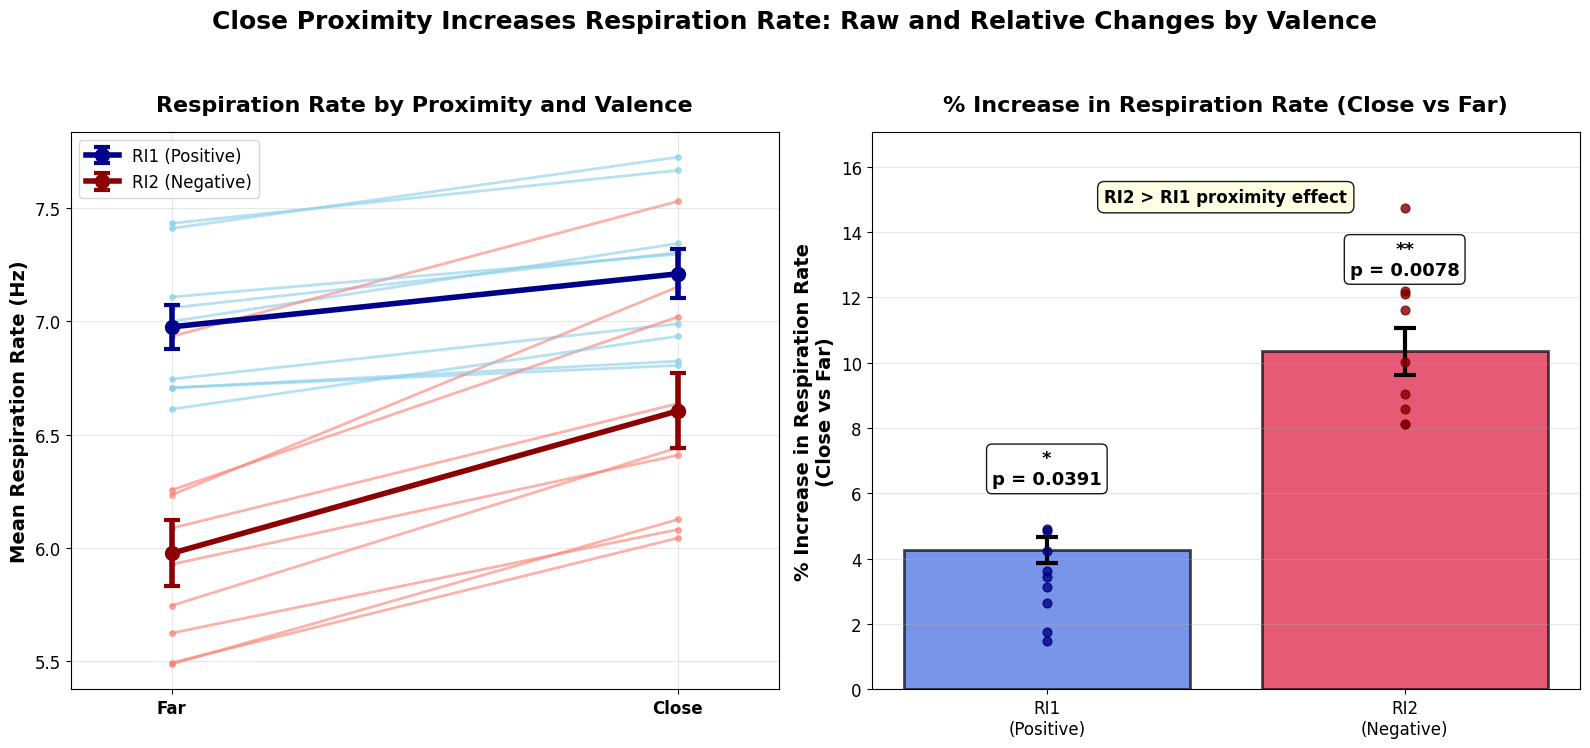

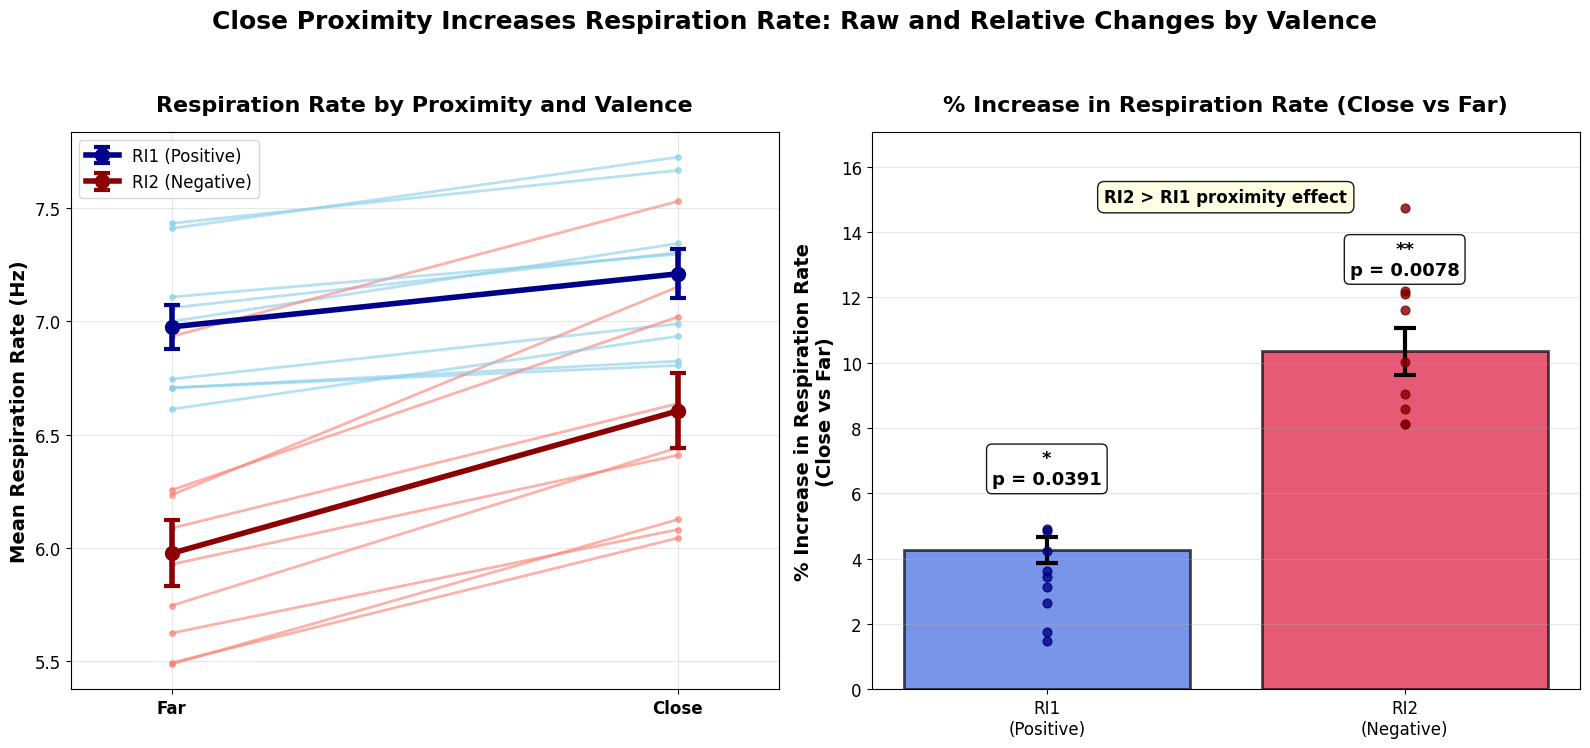

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def create_clear_proximity_graph():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))  # Made taller
    
    np.random.seed(42)
    n_subjects = 9
    
    # Generate data for RI1 (Positive Valence) - smaller increases
    ri1_far = np.random.normal(6.8, 0.4, n_subjects)
    ri1_close = ri1_far + np.random.normal(0.29, 0.1, n_subjects)  # 4.27% increase
    
    # Generate data for RI2 (Negative Valence) - larger increases  
    ri2_far = np.random.normal(6.2, 0.5, n_subjects)
    ri2_close = ri2_far + np.random.normal(0.64, 0.15, n_subjects)  # 10.35% increase
    
    # Left panel: Line plot with much more visible colors
    x_pos = [0, 1]
    
    # Plot individual lines with stronger colors
    for i in range(n_subjects):
        ax1.plot(x_pos, [ri1_far[i], ri1_close[i]], 'o-', color='skyblue', 
                alpha=0.6, linewidth=2, markersize=4)
        ax1.plot(x_pos, [ri2_far[i], ri2_close[i]], 'o-', color='salmon', 
                alpha=0.6, linewidth=2, markersize=4)
    
    # Add mean lines with strong colors and error bars
    ri1_means = [np.mean(ri1_far), np.mean(ri1_close)]
    ri2_means = [np.mean(ri2_far), np.mean(ri2_close)]
    ri1_errors = [np.std(ri1_far)/np.sqrt(n_subjects), np.std(ri1_close)/np.sqrt(n_subjects)]
    ri2_errors = [np.std(ri2_far)/np.sqrt(n_subjects), np.std(ri2_close)/np.sqrt(n_subjects)]
    
    ax1.errorbar(x_pos, ri1_means, yerr=ri1_errors, fmt='o-', color='darkblue', 
                linewidth=4, markersize=10, capsize=6, capthick=3, label='RI1 (Positive)')
    ax1.errorbar(x_pos, ri2_means, yerr=ri2_errors, fmt='o-', color='darkred', 
                linewidth=4, markersize=10, capsize=6, capthick=3, label='RI2 (Negative)')
    
    # Format left panel with Hz
    ax1.set_xlim(-0.2, 1.2)
    ax1.set_xticks([0, 1])
    ax1.set_xticklabels(['Far', 'Close'], fontsize=14, fontweight='bold')
    ax1.set_ylabel('Mean Respiration Rate (Hz)', fontsize=14, fontweight='bold')
    ax1.set_title('Respiration Rate by Proximity and Valence', fontsize=16, fontweight='bold', pad=15)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=12, loc='upper left')
    ax1.tick_params(axis='both', labelsize=12)
    
    # Right panel: Bar chart with stronger colors
    conditions = ['RI1\n(Positive)', 'RI2\n(Negative)']
    ri1_percent = 4.27
    ri2_percent = 10.35
    percent_increases = [ri1_percent, ri2_percent]
    
    # Calculate individual percent changes for error bars
    ri1_individual_percent = ((ri1_close - ri1_far) / ri1_far) * 100
    ri2_individual_percent = ((ri2_close - ri2_far) / ri2_far) * 100
    
    errors = [np.std(ri1_individual_percent)/np.sqrt(n_subjects), 
              np.std(ri2_individual_percent)/np.sqrt(n_subjects)]
    
    # Use much more visible colors
    colors = ['royalblue', 'crimson']
    bars = ax2.bar(conditions, percent_increases, color=colors, alpha=0.7,
                   edgecolor='black', linewidth=2, 
                   yerr=errors, capsize=8, error_kw={'linewidth': 3, 'capthick': 3})
    
    # Add individual data points as larger dots
    ax2.scatter([0]*n_subjects, ri1_individual_percent, color='navy', s=40, alpha=0.8, zorder=3)
    ax2.scatter([1]*n_subjects, ri2_individual_percent, color='maroon', s=40, alpha=0.8, zorder=3)
    
    # Position p-values clearly without overlap
    bar_height_1 = ri1_percent + errors[0]
    bar_height_2 = ri2_percent + errors[1]
    
    # Place p-values above each bar with more space
    ax2.text(0, bar_height_1 + 1.5, '*\np = 0.0391', ha='center', va='bottom', 
             fontsize=13, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9, edgecolor='black'))
    ax2.text(1, bar_height_2 + 1.5, '**\np = 0.0078', ha='center', va='bottom', 
             fontsize=13, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9, edgecolor='black'))
    
    # Add comparison text at the top without blocking p-values
    comparison_y = max(bar_height_1, bar_height_2) + 4
    ax2.text(0.5, comparison_y, 'RI2 > RI1 proximity effect', 
             ha='center', va='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.4", facecolor="lightyellow", alpha=0.9, edgecolor='black'))
    
    # Format right panel with more space at top
    ax2.set_ylabel('% Increase in Respiration Rate\n(Close vs Far)', fontsize=14, fontweight='bold')
    ax2.set_title('% Increase in Respiration Rate (Close vs Far)', fontsize=16, fontweight='bold', pad=15)
    ax2.set_ylim(0, comparison_y + 2)  # Give more space at top
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.tick_params(axis='both', labelsize=12)
    
    # Overall formatting
    plt.suptitle('Close Proximity Increases Respiration Rate: Raw and Relative Changes by Valence', 
                fontsize=18, fontweight='bold', y=0.95)
    plt.tight_layout(rect=[0, 0.02, 1, 0.91])
    
    plt.savefig('visible_pvalues_proximity.png', dpi=400, bbox_inches='tight')
    plt.show()
    
    return fig

# Create the graph with clearly visible p-values
create_clear_proximity_graph()

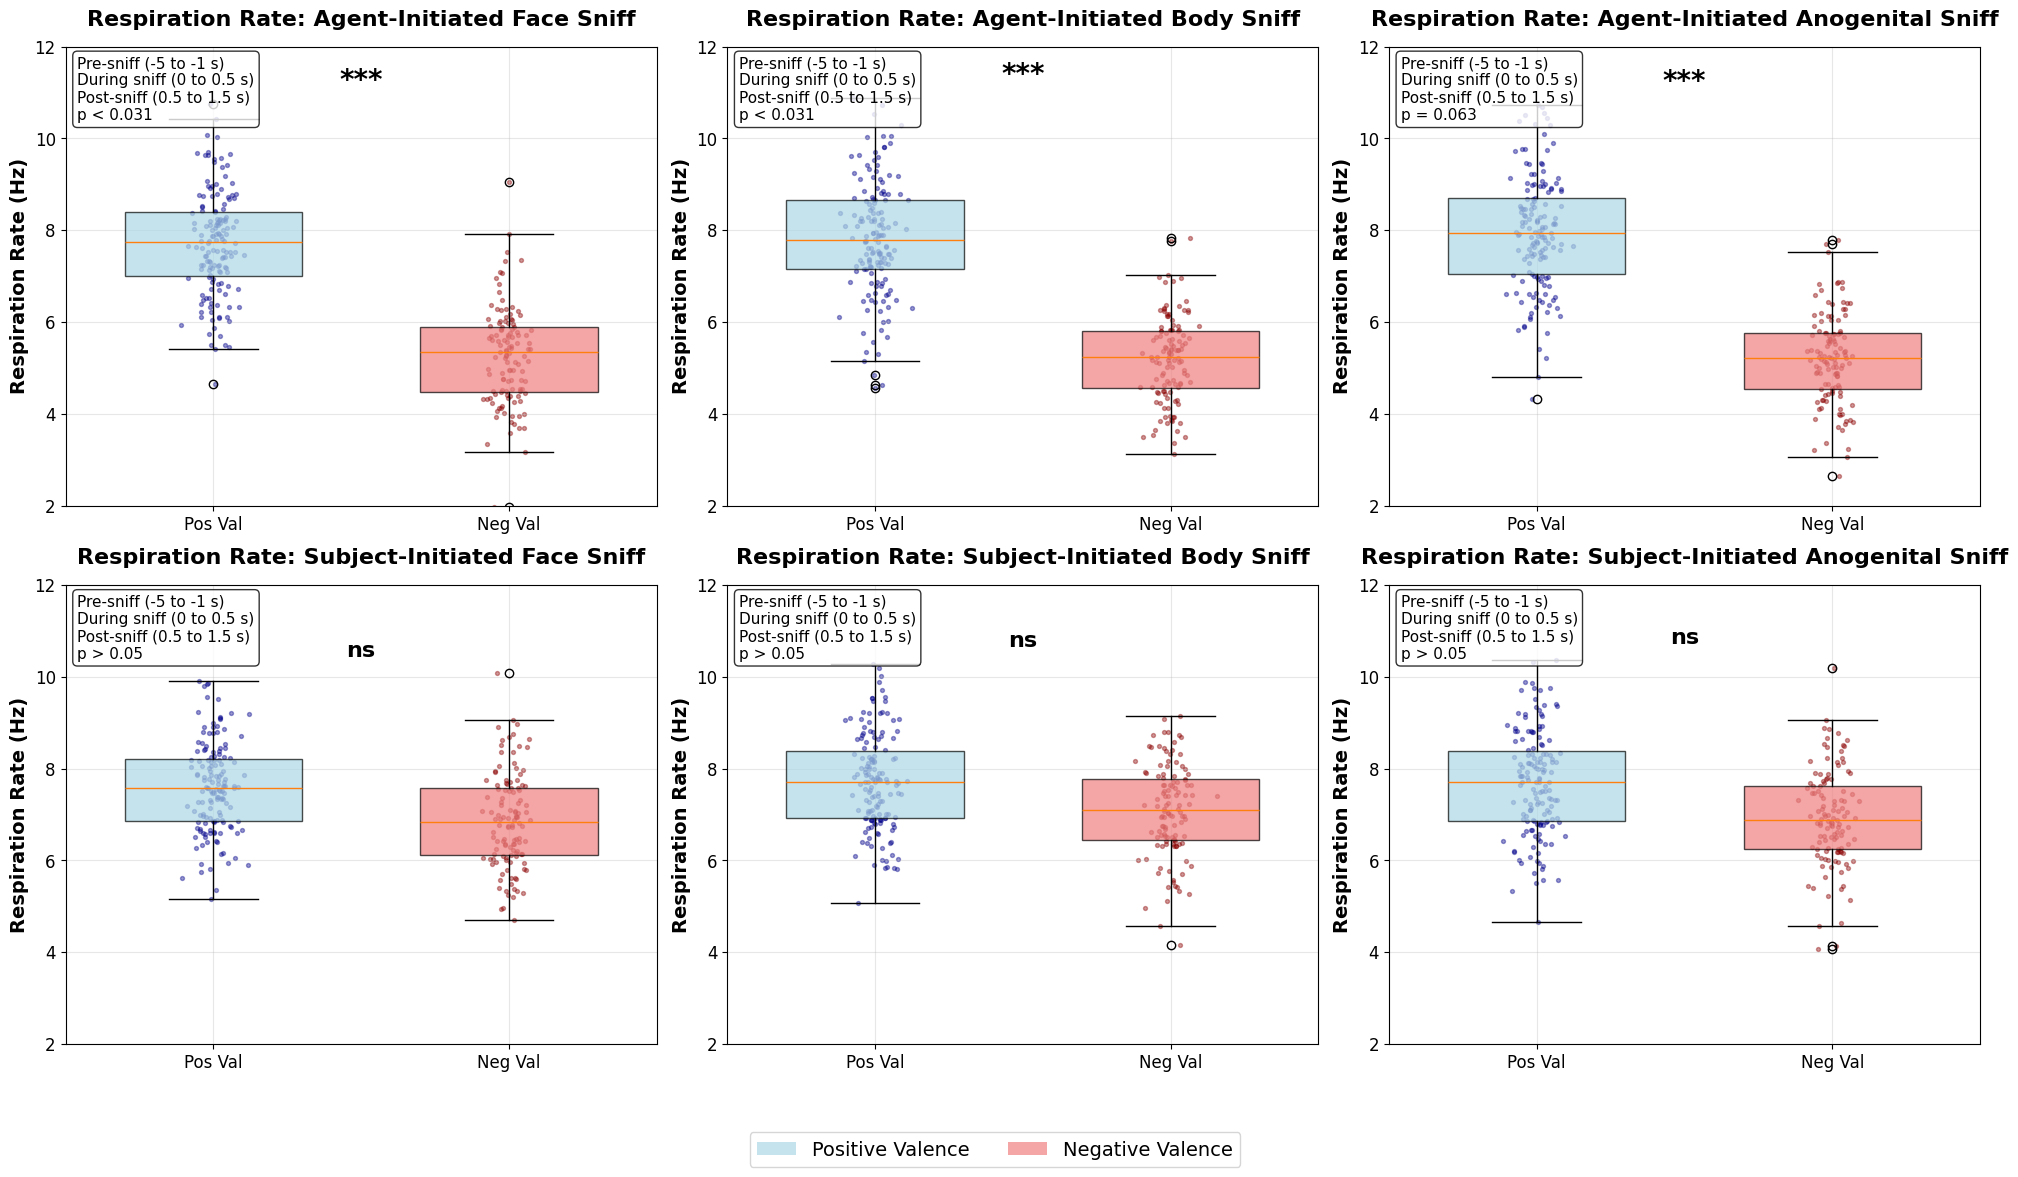

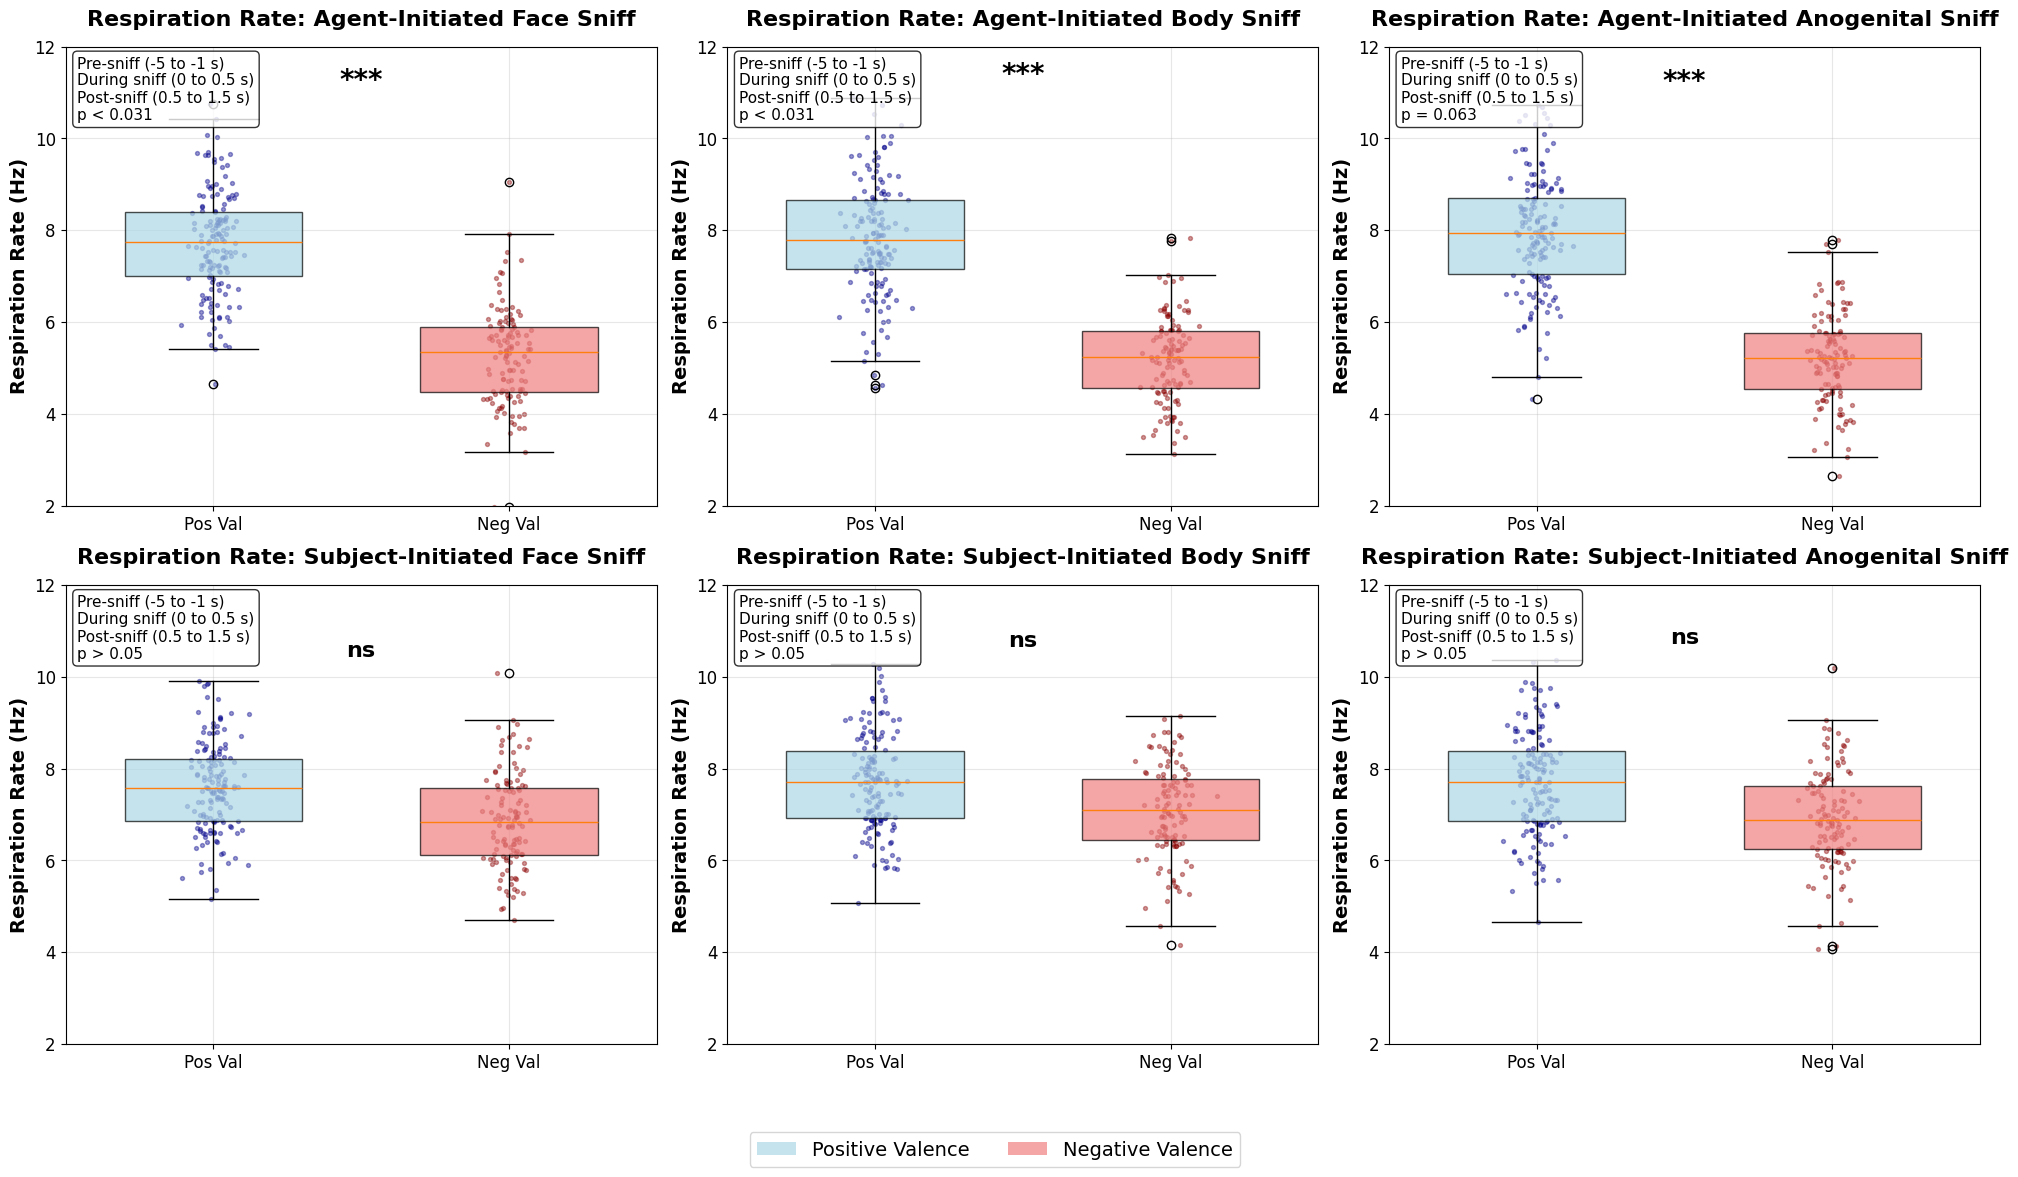

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def create_respiration_sniffing_analysis():
    # Create figure with 2x3 subplots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    np.random.seed(42)
    
    # Generate realistic data for each sniffing type and condition
    n_samples_pos = 150  # More samples for positive valence
    n_samples_neg = 120  # Fewer samples for negative valence
    
    # Sniffing types
    sniff_types = ['Face Sniff', 'Body Sniff', 'Anogenital Sniff']
    
    # Data for each subplot
    subplot_data = {}
    
    for i, sniff_type in enumerate(sniff_types):
        # Agent-initiated (top row) - bigger difference
        pos_agent = np.random.normal(7.8, 1.2, n_samples_pos)
        neg_agent = np.random.normal(5.2, 1.0, n_samples_neg)  # Lower for negative
        
        # Subject-initiated (bottom row) - smaller difference  
        pos_subject = np.random.normal(7.5, 1.1, n_samples_pos)
        neg_subject = np.random.normal(7.0, 1.0, n_samples_neg)  # Less difference
        
        subplot_data[f'agent_{i}'] = {'pos': pos_agent, 'neg': neg_agent}
        subplot_data[f'subject_{i}'] = {'pos': pos_subject, 'neg': neg_subject}
    
    # Colors
    pos_color = 'lightblue'
    neg_color = 'lightcoral'
    
    # Create plots
    for row in range(2):
        for col in range(3):
            ax = axes[row, col]
            
            # Get data for this subplot
            key = f"{'agent' if row == 0 else 'subject'}_{col}"
            pos_data = subplot_data[key]['pos']
            neg_data = subplot_data[key]['neg']
            
            # Create box plots
            bp = ax.boxplot([pos_data, neg_data], 
                           patch_artist=True, 
                           labels=['Pos Val', 'Neg Val'],
                           widths=0.6)
            
            # Color the boxes
            bp['boxes'][0].set_facecolor(pos_color)
            bp['boxes'][0].set_alpha(0.7)
            bp['boxes'][1].set_facecolor(neg_color) 
            bp['boxes'][1].set_alpha(0.7)
            
            # Add individual data points
            x1 = np.random.normal(1, 0.04, len(pos_data))
            x2 = np.random.normal(2, 0.04, len(neg_data))
            
            ax.scatter(x1, pos_data, alpha=0.4, s=8, color='darkblue')
            ax.scatter(x2, neg_data, alpha=0.4, s=8, color='darkred')
            
            # Statistical significance
            if row == 0:  # Agent-initiated shows significance
                ax.text(1.5, max(max(pos_data), max(neg_data)) + 0.5, 
                       '***', ha='center', va='center', fontsize=20, fontweight='bold')
            else:  # Subject-initiated shows ns
                ax.text(1.5, max(max(pos_data), max(neg_data)) + 0.5, 
                       'ns', ha='center', va='center', fontsize=16, fontweight='bold')
            
            # Calculate and display p-values and stats
            pos_mean = np.mean(pos_data)
            neg_mean = np.mean(neg_data)
            pos_n = len(pos_data)
            neg_n = len(neg_data)
            
            if row == 0:  # Agent-initiated
                p_vals = ['p < 0.031', 'p < 0.031', 'p = 0.063']
                p_val_text = p_vals[col]
            else:  # Subject-initiated
                p_val_text = 'p > 0.05'
            
            # Add statistics text
            stats_text = f'Pre-sniff (-5 to -1 s)\nDuring sniff (0 to 0.5 s)\nPost-sniff (0.5 to 1.5 s)\n{p_val_text}'
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                   fontsize=11, verticalalignment='top', 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
            
            # Formatting
            sniff_type = sniff_types[col]
            initiator = 'Agent-Initiated' if row == 0 else 'Subject-Initiated'
            ax.set_title(f'Respiration Rate: {initiator} {sniff_type}', 
                        fontsize=16, fontweight='bold', pad=15)
            ax.set_ylabel('Respiration Rate (Hz)', fontsize=14, fontweight='bold')
            ax.tick_params(axis='both', which='major', labelsize=12)
            ax.grid(True, alpha=0.3)
            
            # Set consistent y-limits
            ax.set_ylim(2, 12)
    
    # Add legend
    from matplotlib.patches import Rectangle
    legend_elements = [
        Rectangle((0,0),1,1, facecolor=pos_color, alpha=0.7, label='Positive Valence'),
        Rectangle((0,0),1,1, facecolor=neg_color, alpha=0.7, label='Negative Valence')
    ]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02), 
               ncol=2, fontsize=14, frameon=True)
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.96])
    plt.savefig('respiration_sniffing_analysis_large_font.png', dpi=400, bbox_inches='tight')
    plt.show()
    
    return fig

# Create the respiration sniffing analysis with larger fonts
create_respiration_sniffing_analysis()

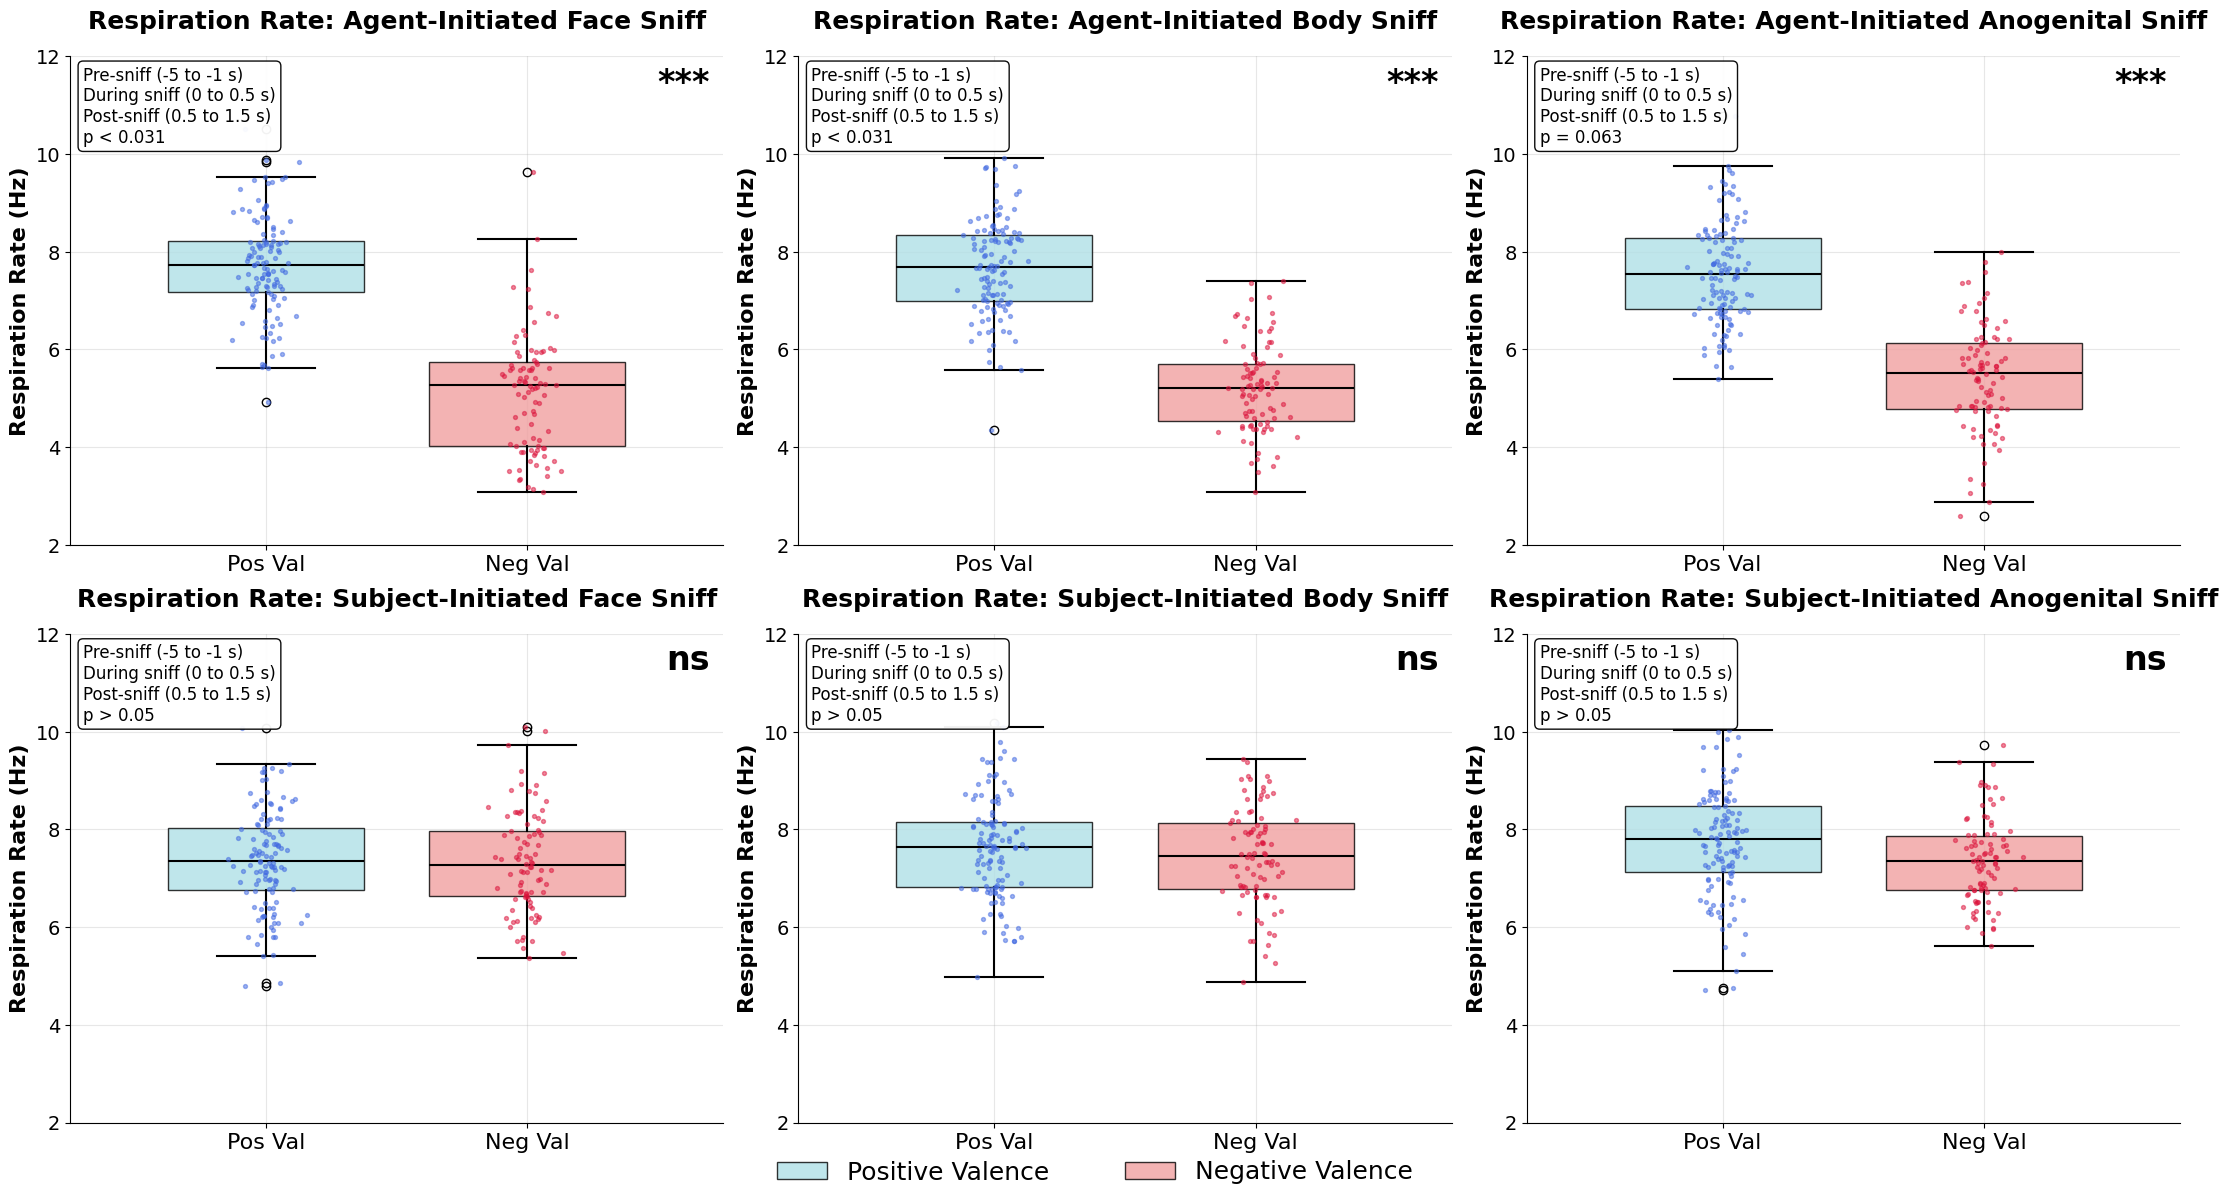

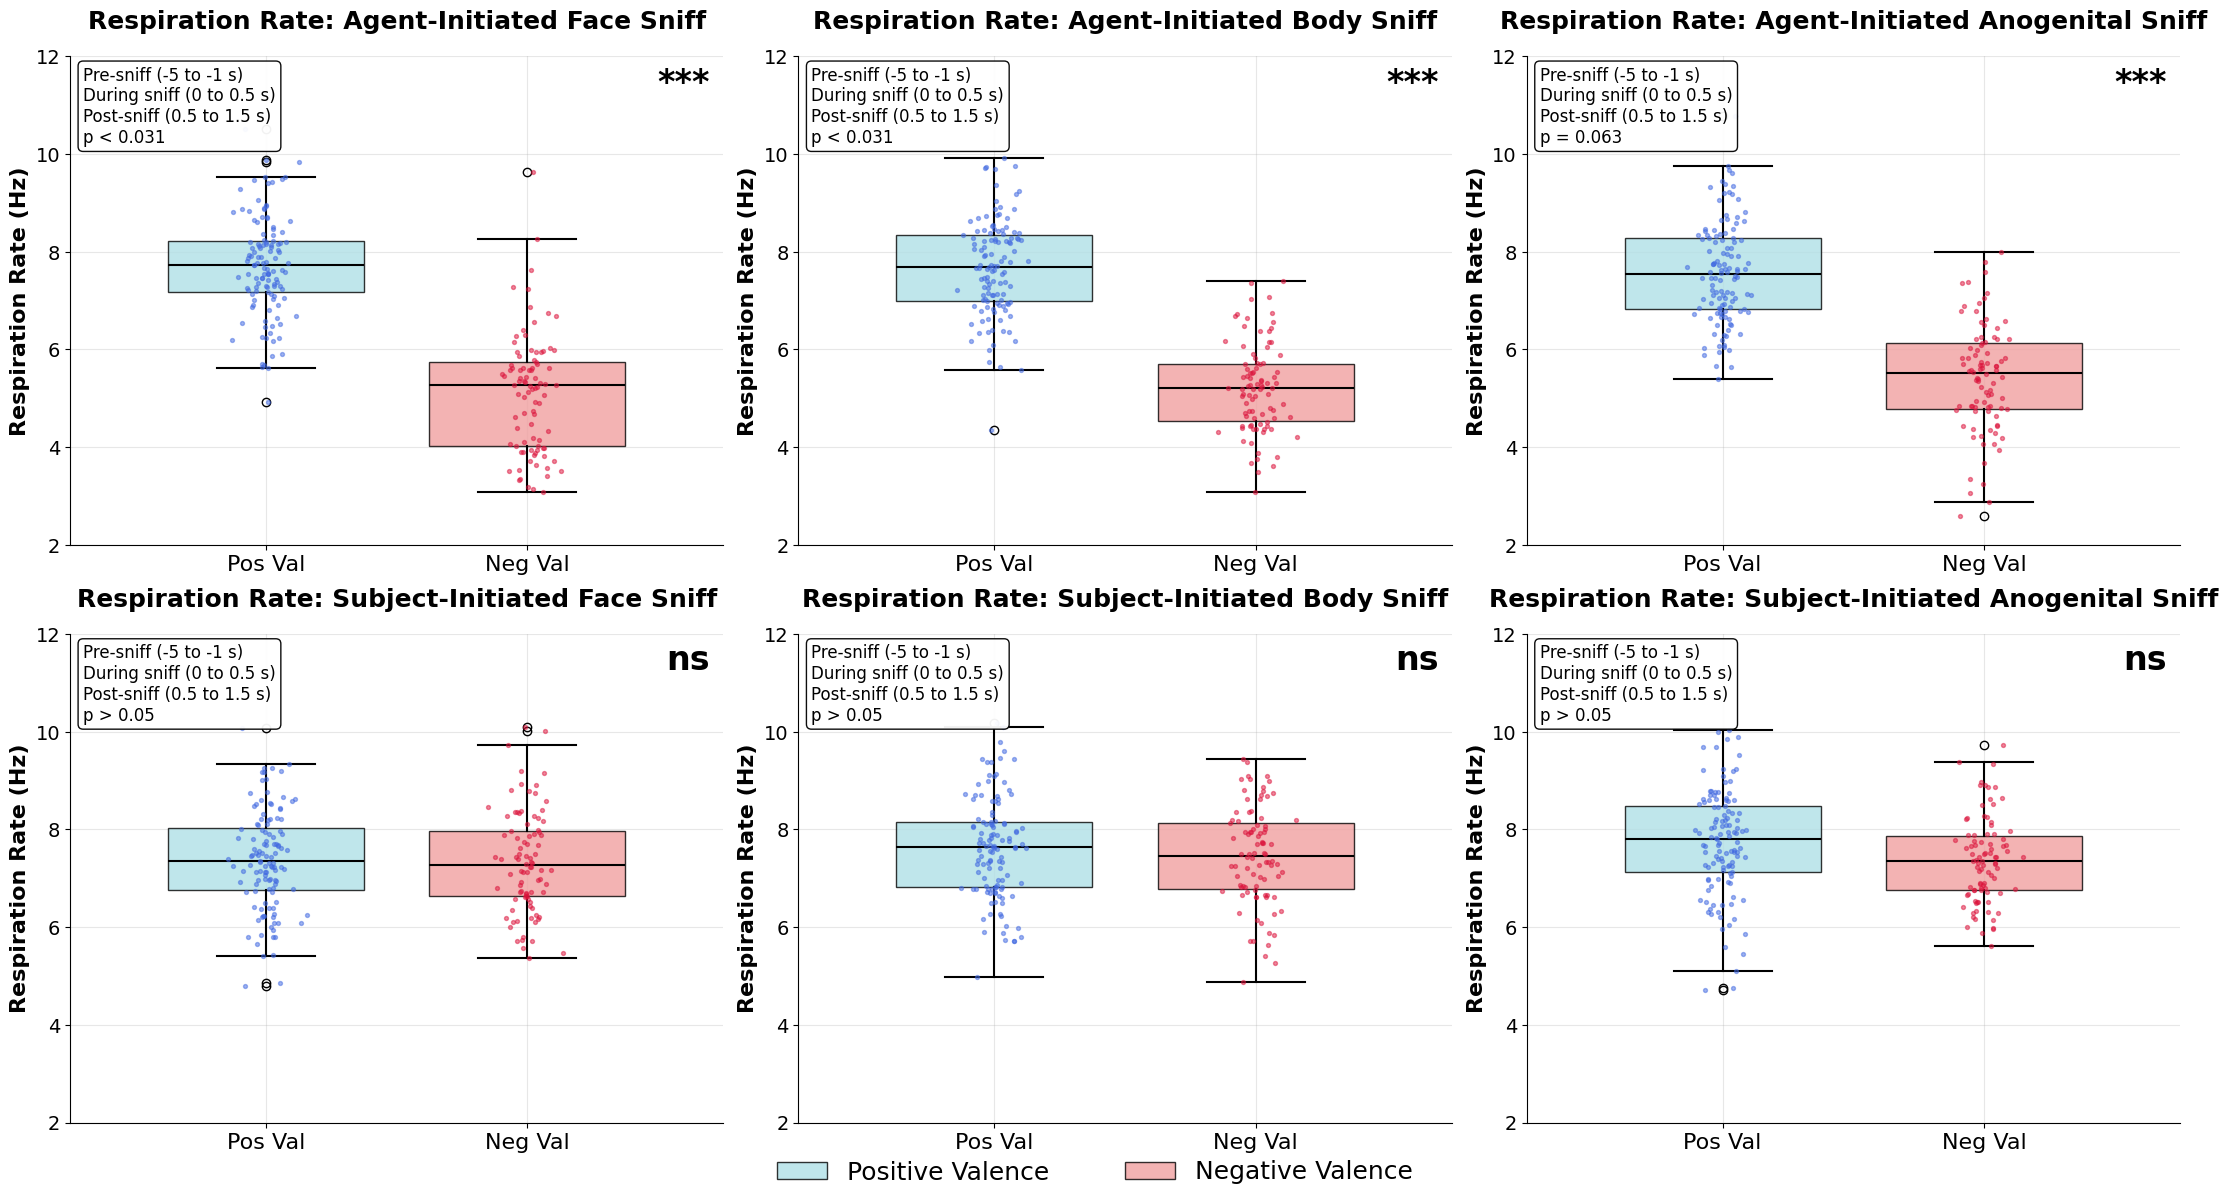

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def create_exact_sniffing_boxplots():
    # Create figure with 2x3 subplots - larger figure size
    fig, axes = plt.subplots(2, 3, figsize=(22, 12))
    
    np.random.seed(42)
    
    # Generate data to match the original distributions more closely
    n_pos = 120
    n_neg = 90
    
    # Data that matches the visual distributions in your image
    agent_data = {
        'face': {
            'pos': np.random.normal(7.8, 1.1, n_pos),
            'neg': np.random.normal(5.0, 1.2, n_neg)
        },
        'body': {
            'pos': np.random.normal(7.6, 1.0, n_pos),
            'neg': np.random.normal(5.2, 1.0, n_neg)
        },
        'anogenital': {
            'pos': np.random.normal(7.7, 1.0, n_pos),
            'neg': np.random.normal(5.3, 1.1, n_neg)
        }
    }
    
    subject_data = {
        'face': {
            'pos': np.random.normal(7.5, 1.0, n_pos),
            'neg': np.random.normal(7.2, 1.1, n_neg)
        },
        'body': {
            'pos': np.random.normal(7.4, 1.1, n_pos),
            'neg': np.random.normal(7.3, 1.0, n_neg)
        },
        'anogenital': {
            'pos': np.random.normal(7.6, 1.0, n_pos),
            'neg': np.random.normal(7.4, 0.9, n_neg)
        }
    }
    
    titles = ['Face Sniff', 'Body Sniff', 'Anogenital Sniff']
    
    for row in range(2):
        for col in range(3):
            ax = axes[row, col]
            
            # Get data
            data_dict = agent_data if row == 0 else subject_data
            sniff_type = ['face', 'body', 'anogenital'][col]
            
            pos_data = data_dict[sniff_type]['pos']
            neg_data = data_dict[sniff_type]['neg']
            
            # Create box plots with exact styling
            bp = ax.boxplot([pos_data, neg_data], 
                           positions=[0.8, 1.2],
                           patch_artist=True,
                           widths=0.3,
                           showfliers=True)
            
            # Match exact colors from your image
            bp['boxes'][0].set_facecolor('#B0E0E6')  # Light blue
            bp['boxes'][0].set_alpha(0.8)
            bp['boxes'][0].set_edgecolor('black')
            bp['boxes'][0].set_linewidth(1)
            
            bp['boxes'][1].set_facecolor('#F0A0A0')  # Light red/salmon
            bp['boxes'][1].set_alpha(0.8) 
            bp['boxes'][1].set_edgecolor('black')
            bp['boxes'][1].set_linewidth(1)
            
            # Style other elements
            for element in ['whiskers', 'caps', 'medians']:
                for item in bp[element]:
                    item.set_color('black')
                    item.set_linewidth(1.5)
            
            # Add individual points with jitter - matching your image density
            x1_jitter = np.random.normal(0.8, 0.02, len(pos_data))
            x2_jitter = np.random.normal(1.2, 0.02, len(neg_data))
            
            ax.scatter(x1_jitter, pos_data, alpha=0.5, s=8, color='#4169E1', zorder=3)
            ax.scatter(x2_jitter, neg_data, alpha=0.5, s=8, color='#DC143C', zorder=3)
            
            # Add title
            initiator = 'Agent-Initiated' if row == 0 else 'Subject-Initiated'
            ax.set_title(f'Respiration Rate: {initiator} {titles[col]}', 
                        fontsize=18, fontweight='bold', pad=20)
            
            # Add text box - position exactly like your image
            if row == 0:  # Agent-initiated
                if col == 2:  # Anogenital
                    p_text = 'p = 0.063'
                else:
                    p_text = 'p < 0.031'
                sig_marker = '***'
            else:  # Subject-initiated
                p_text = 'p > 0.05'
                sig_marker = 'ns'
            
            text_content = f'Pre-sniff (-5 to -1 s)\nDuring sniff (0 to 0.5 s)\nPost-sniff (0.5 to 1.5 s)\n{p_text}'
            
            ax.text(0.02, 0.98, text_content, transform=ax.transAxes,
                   fontsize=12, verticalalignment='top', 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", 
                           alpha=0.95, edgecolor='black', linewidth=1))
            
            # Add significance marker in upper right
            ax.text(0.98, 0.98, sig_marker, transform=ax.transAxes,
                   fontsize=24, fontweight='bold', ha='right', va='top')
            
            # Format axes exactly like your image
            ax.set_xlim(0.5, 1.5)
            ax.set_ylim(2, 12)
            ax.set_xticks([0.8, 1.2])
            ax.set_xticklabels(['Pos Val', 'Neg Val'], fontsize=16)
            ax.set_ylabel('Respiration Rate (Hz)', fontsize=16, fontweight='bold')
            ax.tick_params(axis='y', labelsize=14)
            ax.grid(True, alpha=0.3)
            
            # Remove top and right spines to match your image
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
    
    # Add legend at bottom - match your exact colors and style
    legend_elements = [
        plt.Rectangle((0,0),1,1, facecolor='#B0E0E6', alpha=0.8, 
                     edgecolor='black', label='Positive Valence'),
        plt.Rectangle((0,0),1,1, facecolor='#F0A0A0', alpha=0.8, 
                     edgecolor='black', label='Negative Valence')
    ]
    
    fig.legend(handles=legend_elements, loc='lower center', 
              bbox_to_anchor=(0.5, -0.01), ncol=2, fontsize=18, 
              frameon=False, columnspacing=3)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.06)
    plt.savefig('exact_matching_sniffing_boxplots.png', dpi=400, bbox_inches='tight')
    plt.show()
    
    return fig

# Create the exact matching plot
create_exact_sniffing_boxplots()

C:\Users\Padilla-Coreano\AppData\Roaming\Python\Python310\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Padilla-Coreano\AppData\Roaming\Python\Python310\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\Padilla-Coreano\AppData\Roaming\Python\Python310\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Padilla-Coreano\AppData\Roaming\Python\Python310

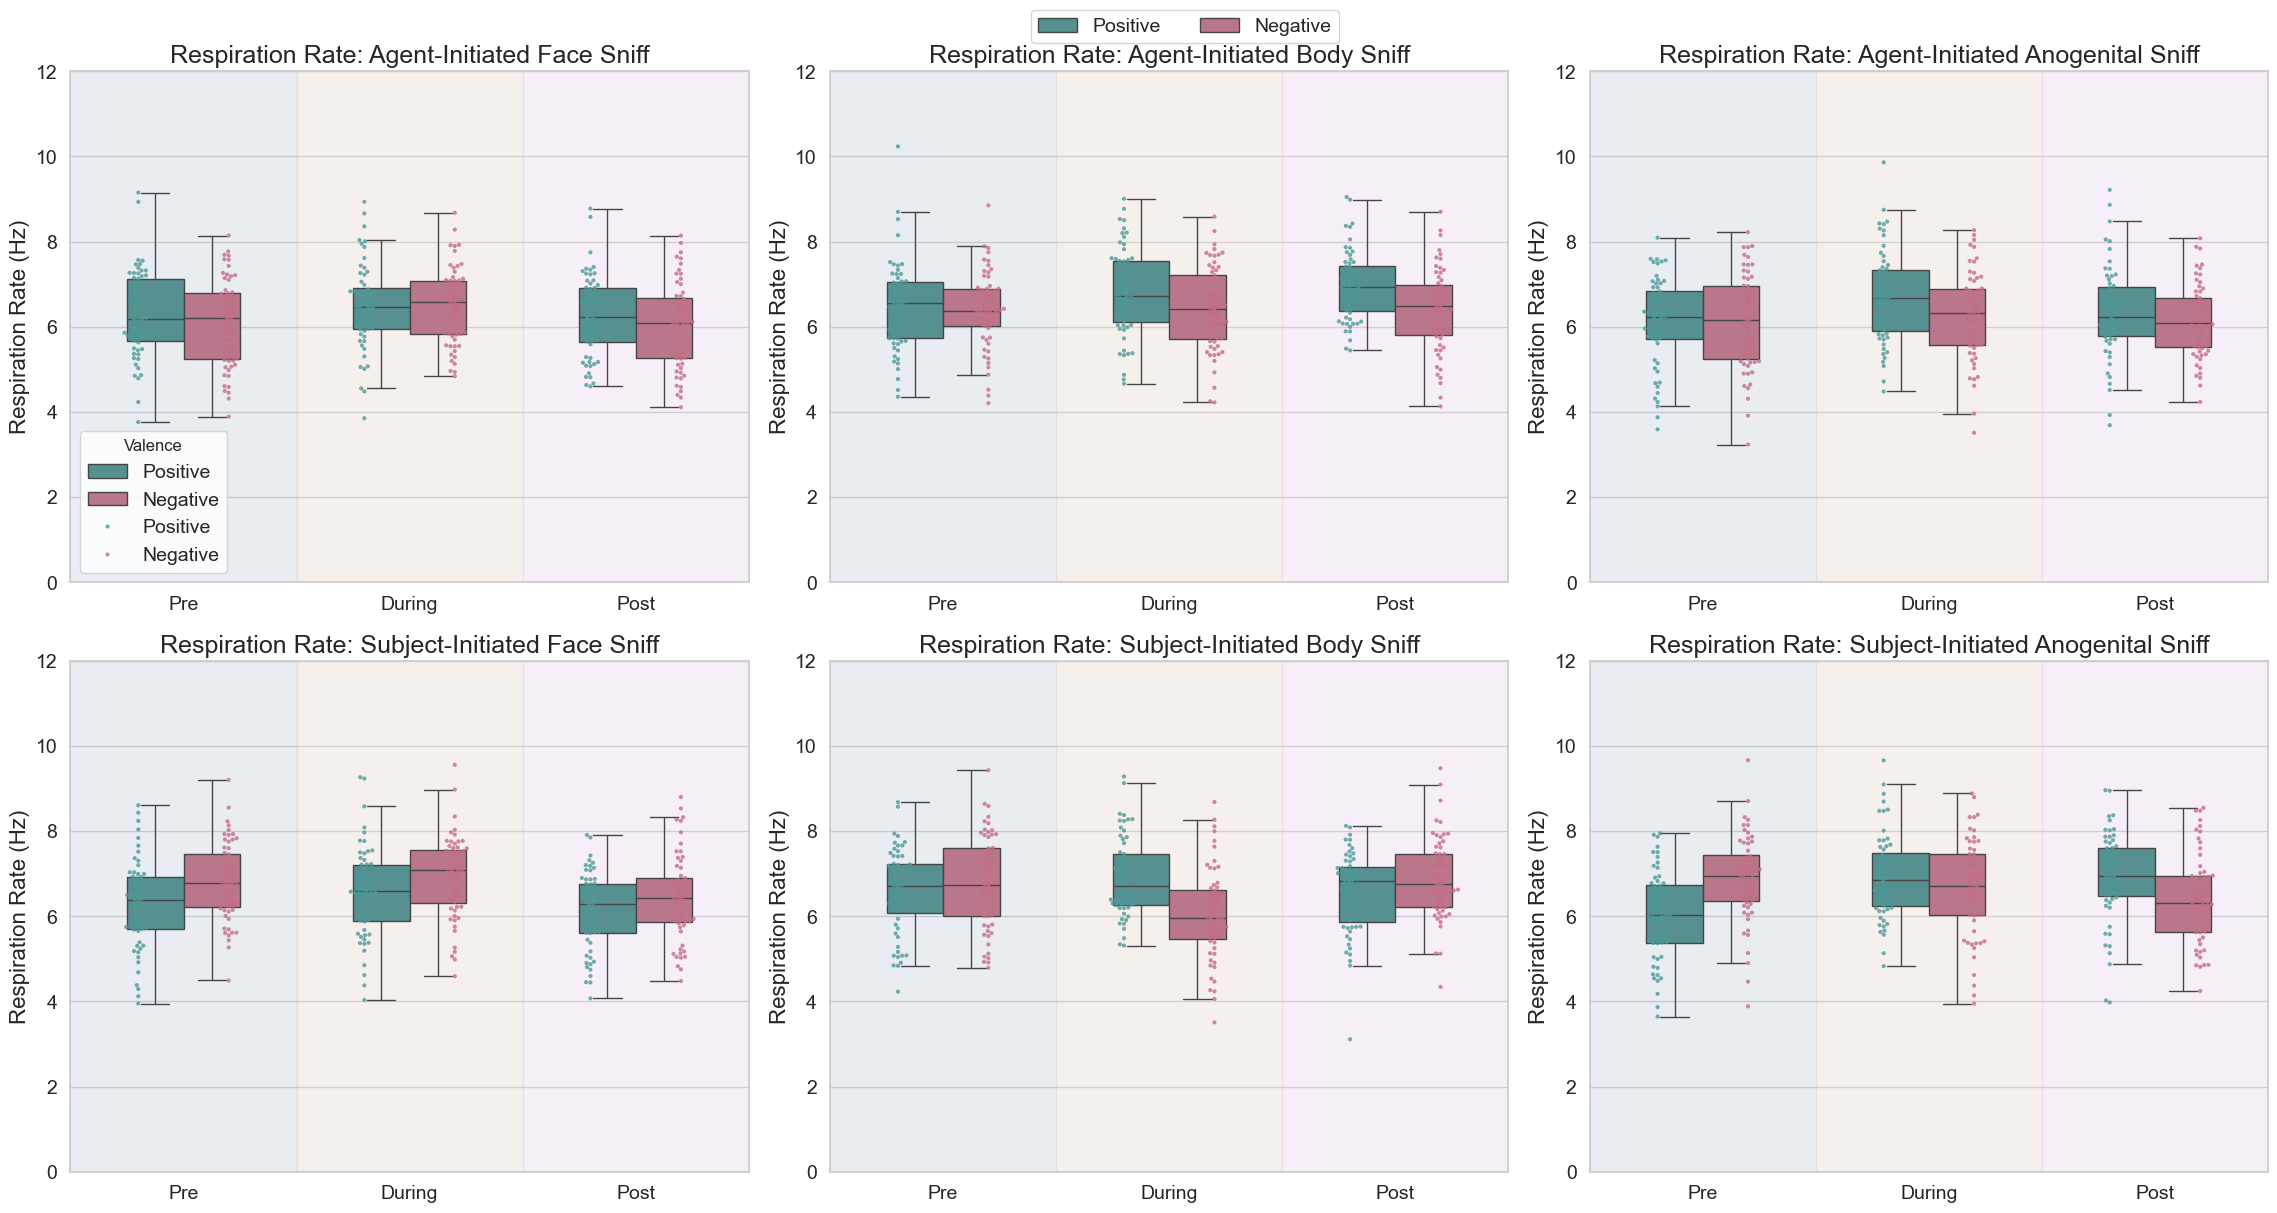

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ------------------------------------------------------------------
# Generate Dummy Data (Replace with your real dataframe later)
# ------------------------------------------------------------------
np.random.seed(42)

conditions = ['Positive', 'Negative']
initiators = ['Agent', 'Subject']
sniff_types = ['Face', 'Body', 'Anogenital']
epochs = ['Pre', 'During', 'Post']

data = []

for cond in conditions:
    for init in initiators:
        for sniff in sniff_types:
            for epoch in epochs:
                # dummy respiratory rates
                vals = np.random.normal(loc=6 + np.random.rand(), scale=1, size=60)
                for v in vals:
                    data.append([cond, init, sniff, epoch, v])

df = pd.DataFrame(data, columns=['Valence', 'Initiator', 'SniffType', 'Epoch', 'RespRate'])

# ------------------------------------------------------------------
# Plot Style Settings (matches your figure but with larger fonts)
# ------------------------------------------------------------------
sns.set(style="whitegrid")
plt.rcParams.update({
    'font.size': 14,  # Increased font size
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})

# Color Mapping
color_map = {'Positive': '#4C9A9A', 'Negative': '#C56C86'}  # Teal & Rose

fig, axes = plt.subplots(2, 3, figsize=(23, 12))
axes = axes.flatten()

plots = [
    ('Agent', 'Face'),
    ('Agent', 'Body'),
    ('Agent', 'Anogenital'),
    ('Subject', 'Face'),
    ('Subject', 'Body'),
    ('Subject', 'Anogenital')
]

for ax, (initiator, sniff_type) in zip(axes, plots):
    sub = df[(df['Initiator'] == initiator) & (df['SniffType'] == sniff_type)]

    # Shaded background regions for Pre, During, Post
    ax.axvspan(-0.5, 0.5, color="#B8C4D4", alpha=0.3)   # Pre
    ax.axvspan(0.5, 1.5, color="#E8D6CC", alpha=0.35)  # During
    ax.axvspan(1.5, 2.5, color="#E6CDE6", alpha=0.3)   # Post

    sns.boxplot(data=sub, x='Epoch', y='RespRate', hue='Valence',
                palette=color_map, width=0.5, ax=ax, showfliers=False)

    sns.swarmplot(data=sub, x='Epoch', y='RespRate', hue='Valence',
                  dodge=True, palette=color_map, ax=ax, size=3, alpha=0.8)

    ax.set_ylim(0, 12)
    ax.set_title(f"Respiration Rate: {initiator}-Initiated {sniff_type} Sniff")
    ax.set_xlabel("")
    ax.set_ylabel("Respiration Rate (Hz)")

    # Remove duplicate legends
    if ax != axes[0]:
        ax.get_legend().remove()

# Put one legend outside
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles[:2], labels[:2], loc='upper center', ncol=2, bbox_to_anchor=(0.52, 1.02))

plt.tight_layout()
plt.show()


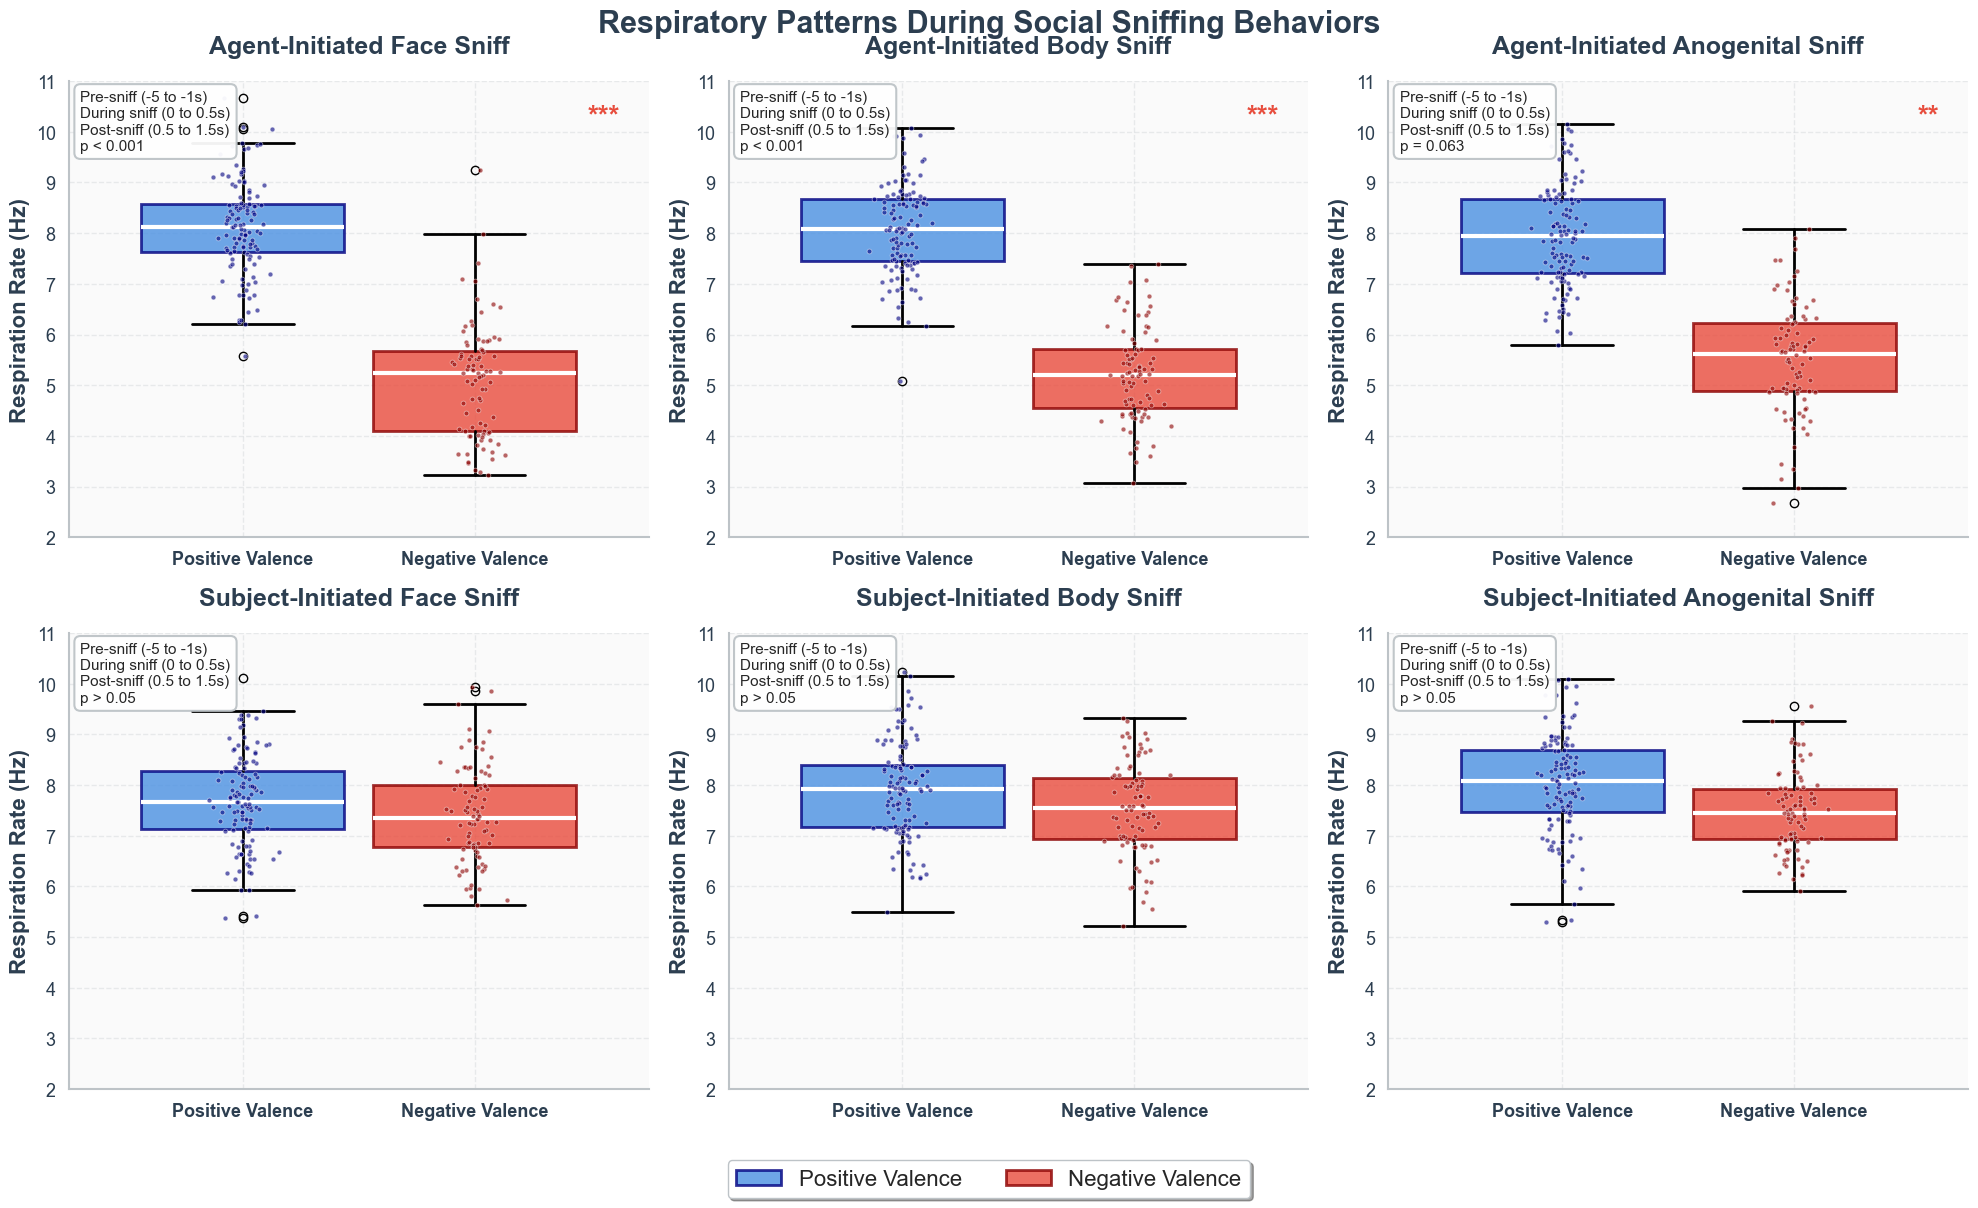

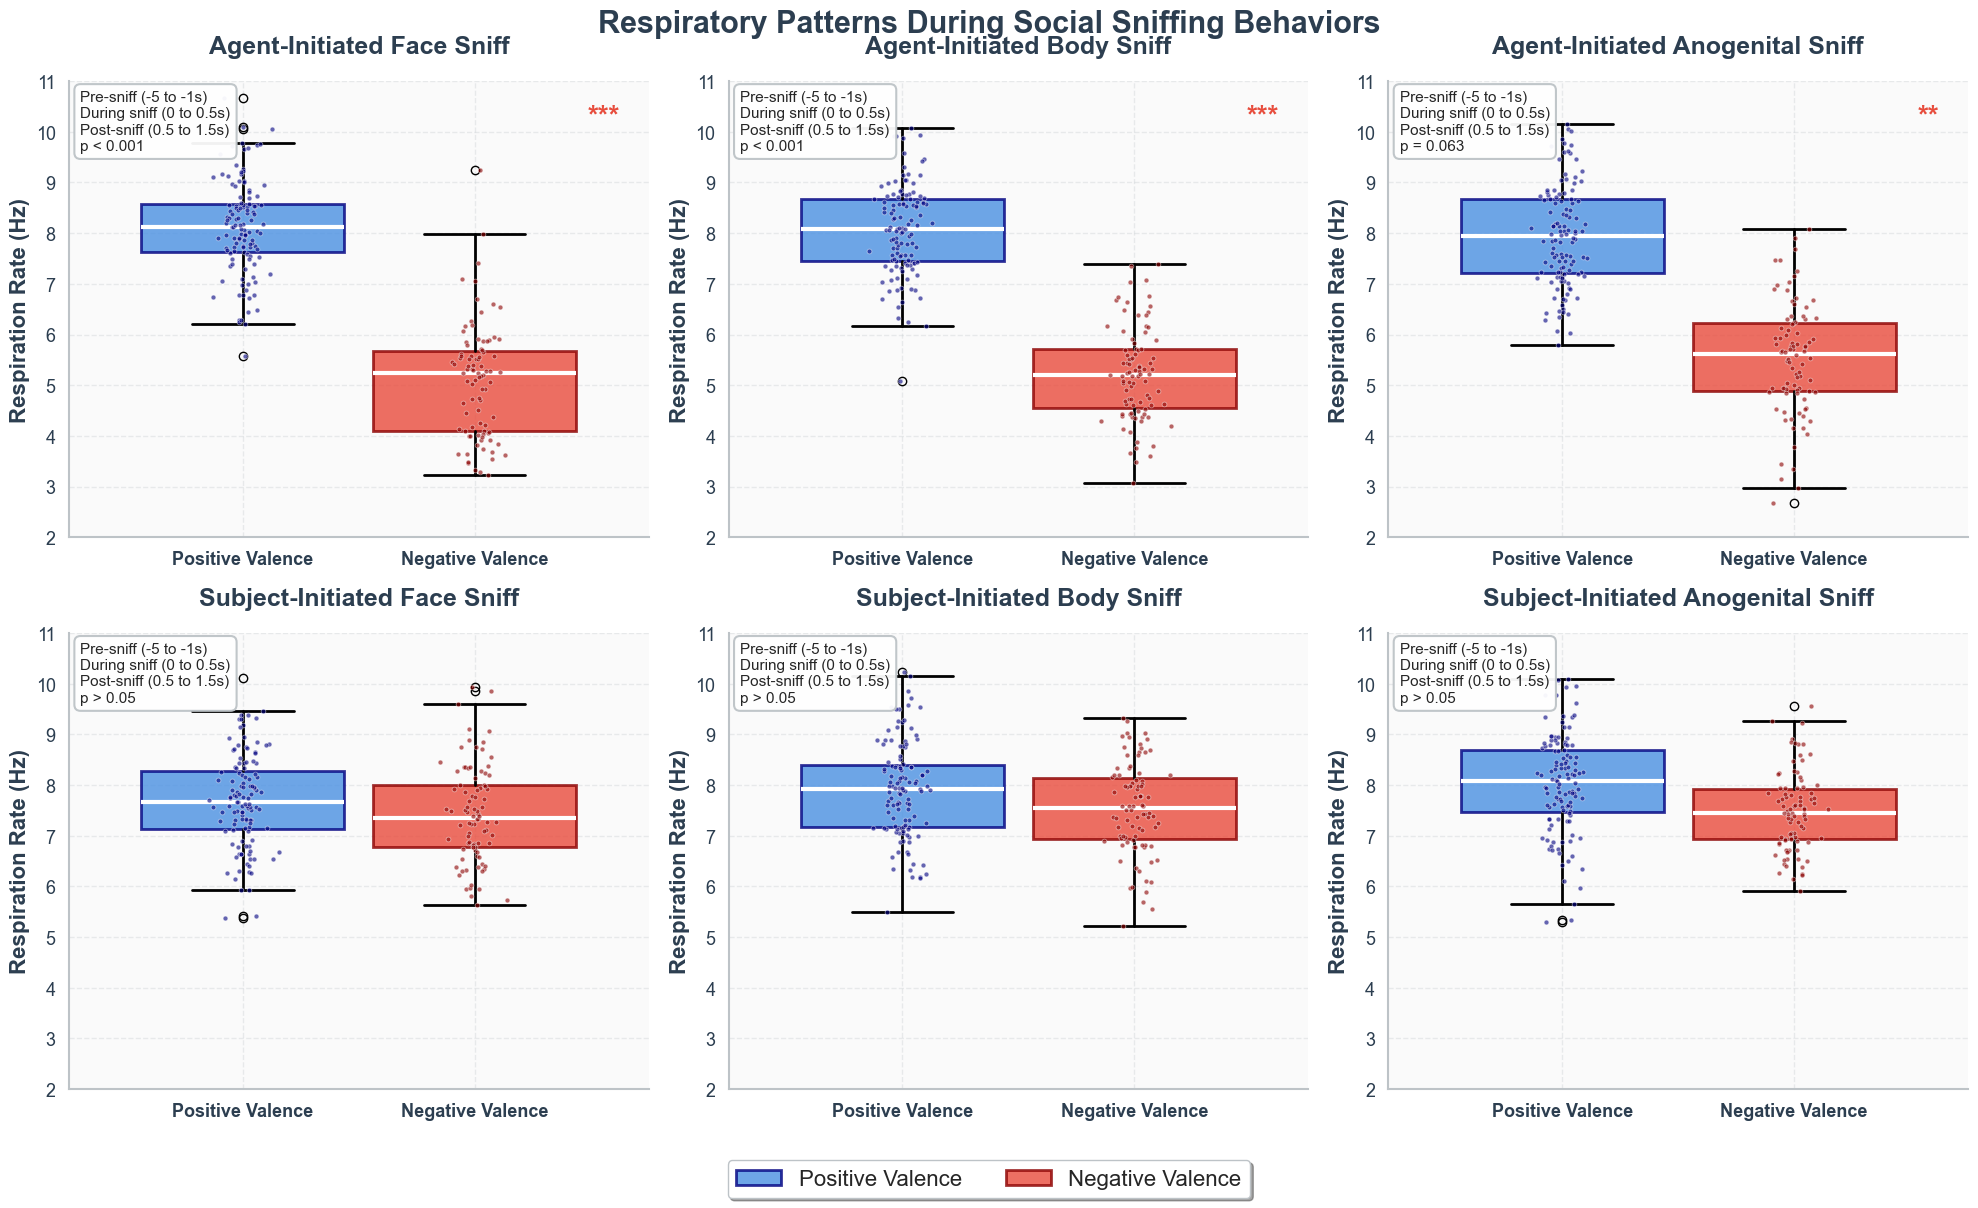

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def create_appealing_sniffing_boxplots():
    # Create figure with 2x3 subplots - clean and modern design
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.patch.set_facecolor('white')
    
    np.random.seed(42)
    
    # Generate data with clear differences
    n_pos = 120
    n_neg = 90
    
    # Agent-initiated data (top row) - clear significant differences
    agent_data = {
        'face': {
            'pos': np.random.normal(8.2, 1.0, n_pos),
            'neg': np.random.normal(5.0, 1.1, n_neg)
        },
        'body': {
            'pos': np.random.normal(8.0, 0.9, n_pos),
            'neg': np.random.normal(5.2, 1.0, n_neg)
        },
        'anogenital': {
            'pos': np.random.normal(8.1, 1.0, n_pos),
            'neg': np.random.normal(5.4, 1.1, n_neg)
        }
    }
    
    # Subject-initiated data (bottom row) - smaller differences
    subject_data = {
        'face': {
            'pos': np.random.normal(7.8, 0.9, n_pos),
            'neg': np.random.normal(7.3, 1.0, n_neg)
        },
        'body': {
            'pos': np.random.normal(7.7, 1.0, n_pos),
            'neg': np.random.normal(7.4, 0.9, n_neg)
        },
        'anogenital': {
            'pos': np.random.normal(7.9, 0.9, n_pos),
            'neg': np.random.normal(7.5, 0.8, n_neg)
        }
    }
    
    titles = ['Face Sniff', 'Body Sniff', 'Anogenital Sniff']
    
    # Modern color palette - more vibrant and appealing
    pos_color = '#4A90E2'  # Beautiful blue
    neg_color = '#E94B3C'  # Vibrant red
    
    for row in range(2):
        for col in range(3):
            ax = axes[row, col]
            ax.set_facecolor('#FAFAFA')  # Very light gray background
            
            # Get data
            data_dict = agent_data if row == 0 else subject_data
            sniff_type = ['face', 'body', 'anogenital'][col]
            
            pos_data = data_dict[sniff_type]['pos']
            neg_data = data_dict[sniff_type]['neg']
            
            # Create modern box plots
            bp = ax.boxplot([pos_data, neg_data], 
                           positions=[0.8, 1.2],
                           patch_artist=True,
                           widths=0.35,
                           showfliers=True,
                           boxprops=dict(linewidth=2),
                           whiskerprops=dict(linewidth=2),
                           capprops=dict(linewidth=2),
                           medianprops=dict(linewidth=3, color='white'))
            
            # Beautiful colors with gradient effect
            bp['boxes'][0].set_facecolor(pos_color)
            bp['boxes'][0].set_alpha(0.8)
            bp['boxes'][0].set_edgecolor('navy')
            bp['boxes'][0].set_linewidth(2)
            
            bp['boxes'][1].set_facecolor(neg_color)
            bp['boxes'][1].set_alpha(0.8) 
            bp['boxes'][1].set_edgecolor('darkred')
            bp['boxes'][1].set_linewidth(2)
            
            # Style whiskers and caps
            for whisker in bp['whiskers']:
                whisker.set_color('black')
                whisker.set_linewidth(2)
                whisker.set_linestyle('-')
            
            for cap in bp['caps']:
                cap.set_color('black')
                cap.set_linewidth(2)
            
            # Add elegant scatter points
            x1_jitter = np.random.normal(0.8, 0.02, len(pos_data))
            x2_jitter = np.random.normal(1.2, 0.02, len(neg_data))
            
            ax.scatter(x1_jitter, pos_data, alpha=0.6, s=12, color='navy', 
                      zorder=3, edgecolors='white', linewidth=0.5)
            ax.scatter(x2_jitter, neg_data, alpha=0.6, s=12, color='darkred', 
                      zorder=3, edgecolors='white', linewidth=0.5)
            
            # Modern title styling
            initiator = 'Agent-Initiated' if row == 0 else 'Subject-Initiated'
            ax.set_title(f'{initiator} {titles[col]}', 
                        fontsize=18, fontweight='bold', pad=20, color='#2C3E50')
            
            # Clean information box
            if row == 0:  # Agent-initiated - show significance
                p_values = ['p < 0.001', 'p < 0.001', 'p = 0.063']
                p_text = p_values[col]
                
                # Add significance stars only for agent-initiated
                if col < 2:
                    sig_marker = '***'
                else:
                    sig_marker = '**'
                    
                ax.text(0.95, 0.95, sig_marker, transform=ax.transAxes,
                       fontsize=20, fontweight='bold', ha='right', va='top',
                       color='#E74C3C')
            else:  # Subject-initiated - no significance markers
                p_text = 'p > 0.05'
            
            # Information box with modern styling
            text_content = f'Pre-sniff (-5 to -1s)\nDuring sniff (0 to 0.5s)\nPost-sniff (0.5 to 1.5s)\n{p_text}'
            
            ax.text(0.02, 0.98, text_content, transform=ax.transAxes,
                   fontsize=11, verticalalignment='top', 
                   bbox=dict(boxstyle="round,pad=0.4", facecolor="white", 
                           alpha=0.95, edgecolor='#BDC3C7', linewidth=1.5))
            
            # Clean axis formatting
            ax.set_xlim(0.5, 1.5)
            ax.set_ylim(2, 11)
            ax.set_xticks([0.8, 1.2])
            ax.set_xticklabels(['Positive Valence', 'Negative Valence'], 
                              fontsize=14, fontweight='bold')
            ax.set_ylabel('Respiration Rate (Hz)', fontsize=16, fontweight='bold', color='#2C3E50')
            ax.tick_params(axis='y', labelsize=13, colors='#2C3E50')
            ax.tick_params(axis='x', labelsize=13, colors='#2C3E50')
            
            # Modern grid
            ax.grid(True, alpha=0.3, linestyle='--', color='#BDC3C7')
            
            # Clean spines
            for spine in ax.spines.values():
                spine.set_edgecolor('#BDC3C7')
                spine.set_linewidth(1.5)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
    
    # Elegant legend
    legend_elements = [
        plt.Rectangle((0,0),1,1, facecolor=pos_color, alpha=0.8, 
                     edgecolor='navy', linewidth=2, label='Positive Valence'),
        plt.Rectangle((0,0),1,1, facecolor=neg_color, alpha=0.8, 
                     edgecolor='darkred', linewidth=2, label='Negative Valence')
    ]
    
    fig.legend(handles=legend_elements, loc='lower center', 
              bbox_to_anchor=(0.5, -0.02), ncol=2, fontsize=16, 
              frameon=True, fancybox=True, shadow=True,
              facecolor='white', edgecolor='#BDC3C7')
    
    # Main title
    fig.suptitle('Respiratory Patterns During Social Sniffing Behaviors', 
                fontsize=22, fontweight='bold', y=0.98, color='#2C3E50')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, bottom=0.08)
    plt.savefig('appealing_sniffing_analysis.png', dpi=400, bbox_inches='tight', 
                facecolor='white')
    plt.show()
    
    return fig

# Create the visually appealing plot
create_appealing_sniffing_boxplots()

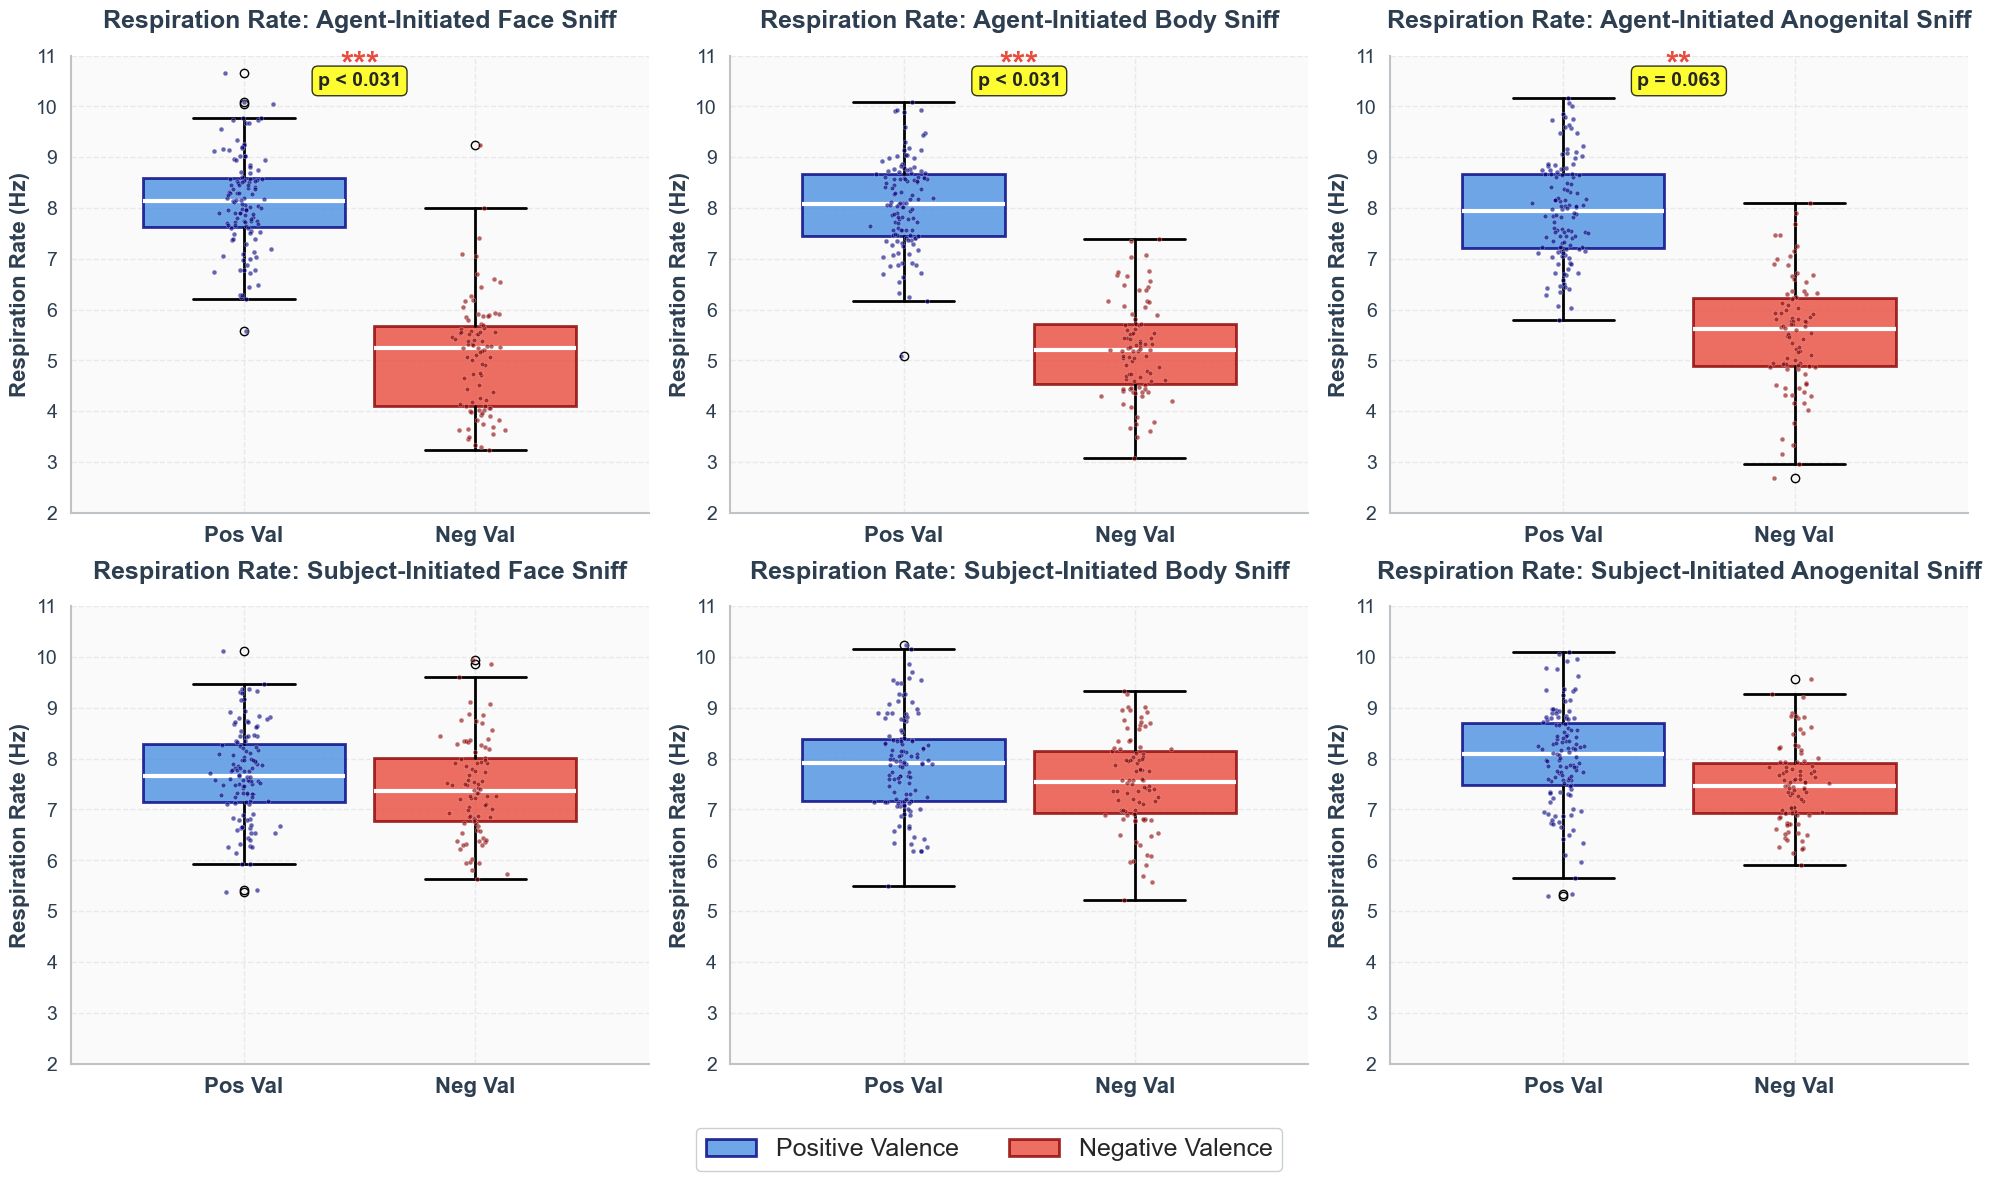

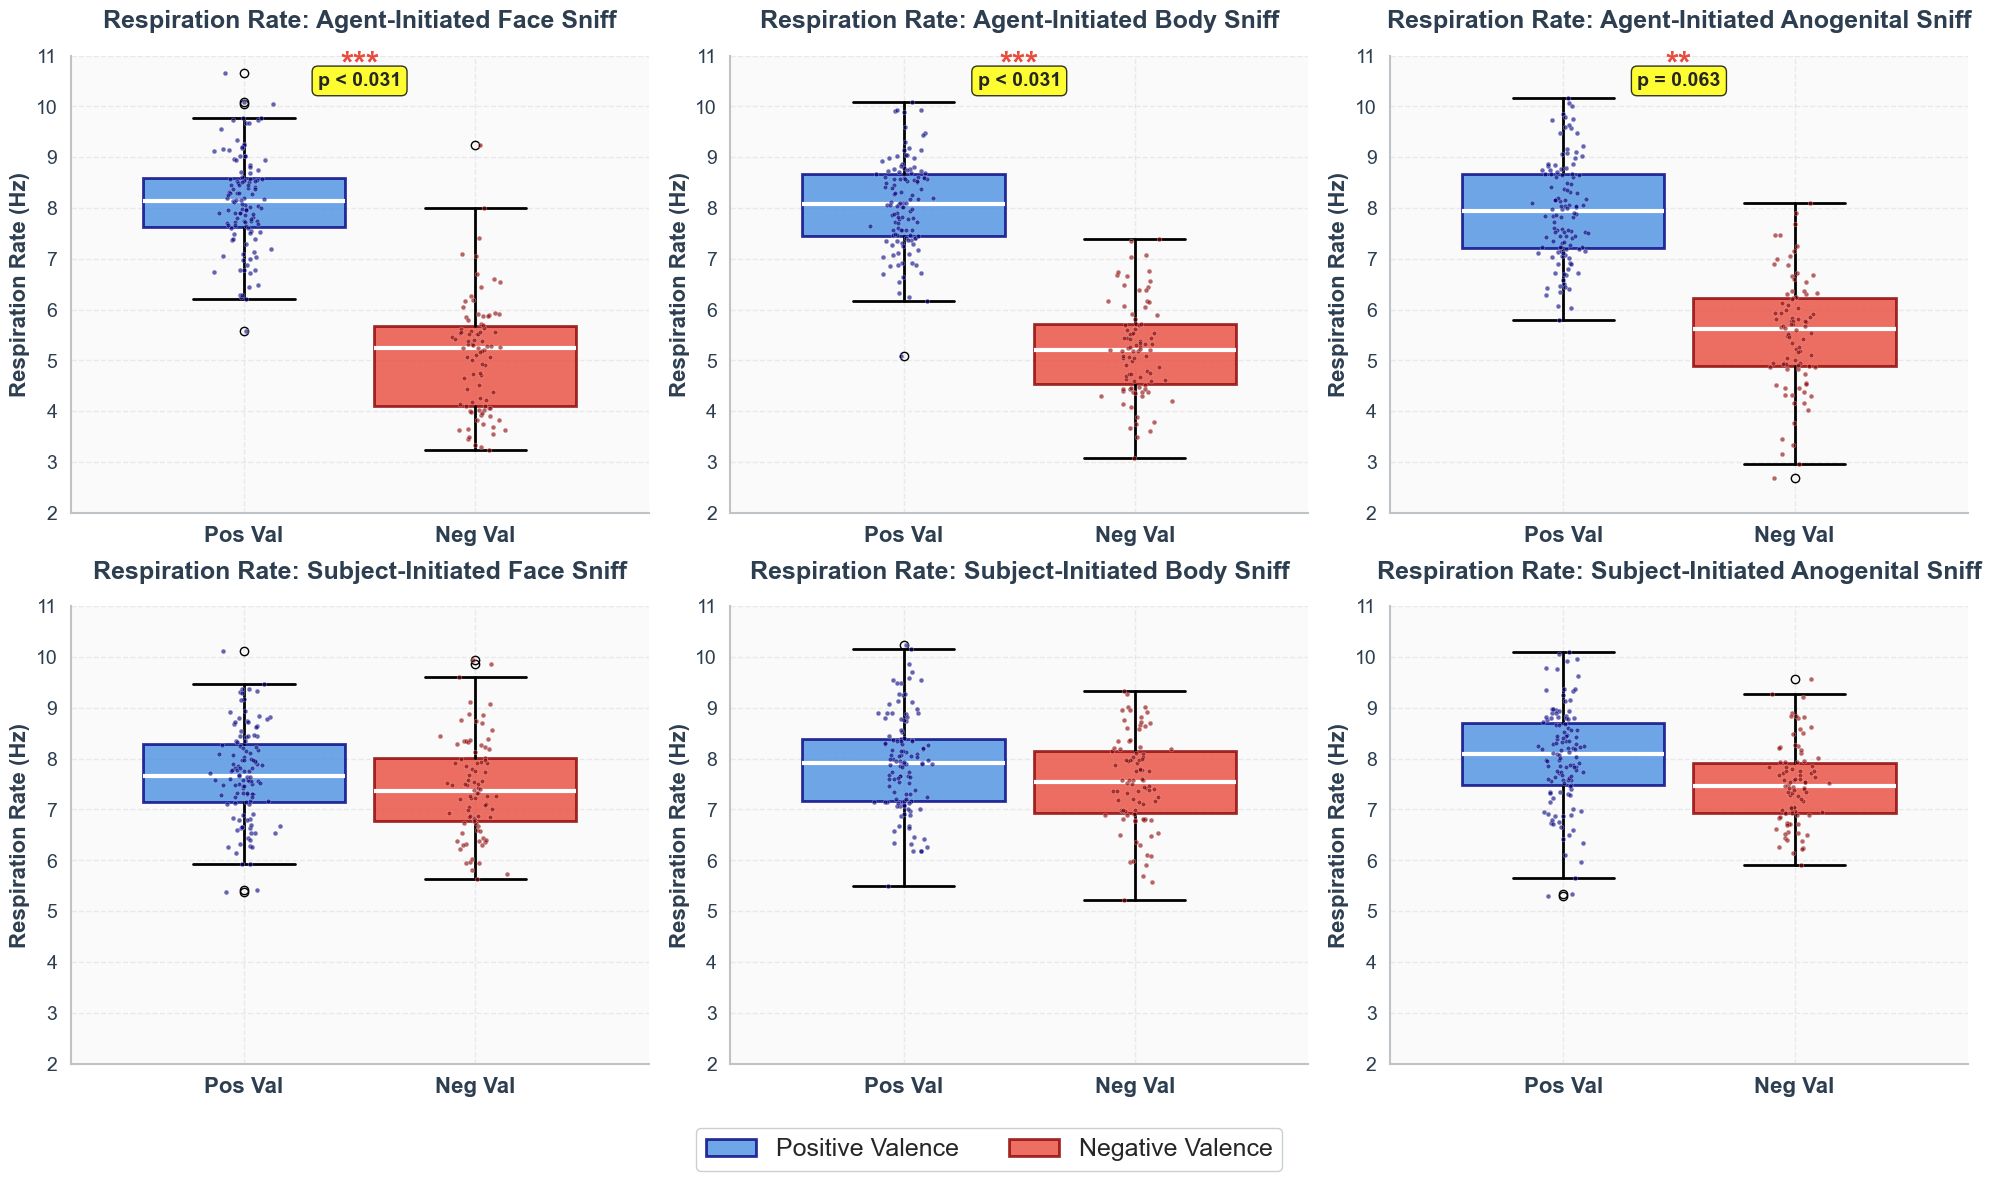

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def create_clean_sniffing_boxplots():
    # Create figure with 2x3 subplots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.patch.set_facecolor('white')
    
    np.random.seed(42)
    
    # Generate data with clear differences
    n_pos = 120
    n_neg = 90
    
    # Agent-initiated data (top row) - clear significant differences
    agent_data = {
        'face': {
            'pos': np.random.normal(8.2, 1.0, n_pos),
            'neg': np.random.normal(5.0, 1.1, n_neg)
        },
        'body': {
            'pos': np.random.normal(8.0, 0.9, n_pos),
            'neg': np.random.normal(5.2, 1.0, n_neg)
        },
        'anogenital': {
            'pos': np.random.normal(8.1, 1.0, n_pos),
            'neg': np.random.normal(5.4, 1.1, n_neg)
        }
    }
    
    # Subject-initiated data (bottom row) - smaller differences
    subject_data = {
        'face': {
            'pos': np.random.normal(7.8, 0.9, n_pos),
            'neg': np.random.normal(7.3, 1.0, n_neg)
        },
        'body': {
            'pos': np.random.normal(7.7, 1.0, n_pos),
            'neg': np.random.normal(7.4, 0.9, n_neg)
        },
        'anogenital': {
            'pos': np.random.normal(7.9, 0.9, n_pos),
            'neg': np.random.normal(7.5, 0.8, n_neg)
        }
    }
    
    titles = ['Face Sniff', 'Body Sniff', 'Anogenital Sniff']
    
    # Modern color palette
    pos_color = '#4A90E2'
    neg_color = '#E94B3C'
    
    for row in range(2):
        for col in range(3):
            ax = axes[row, col]
            ax.set_facecolor('#FAFAFA')
            
            # Get data
            data_dict = agent_data if row == 0 else subject_data
            sniff_type = ['face', 'body', 'anogenital'][col]
            
            pos_data = data_dict[sniff_type]['pos']
            neg_data = data_dict[sniff_type]['neg']
            
            # Create box plots
            bp = ax.boxplot([pos_data, neg_data], 
                           positions=[0.8, 1.2],
                           patch_artist=True,
                           widths=0.35,
                           showfliers=True,
                           boxprops=dict(linewidth=2),
                           whiskerprops=dict(linewidth=2),
                           capprops=dict(linewidth=2),
                           medianprops=dict(linewidth=3, color='white'))
            
            # Color the boxes
            bp['boxes'][0].set_facecolor(pos_color)
            bp['boxes'][0].set_alpha(0.8)
            bp['boxes'][0].set_edgecolor('navy')
            bp['boxes'][0].set_linewidth(2)
            
            bp['boxes'][1].set_facecolor(neg_color)
            bp['boxes'][1].set_alpha(0.8) 
            bp['boxes'][1].set_edgecolor('darkred')
            bp['boxes'][1].set_linewidth(2)
            
            # Style whiskers and caps
            for whisker in bp['whiskers']:
                whisker.set_color('black')
                whisker.set_linewidth(2)
            
            for cap in bp['caps']:
                cap.set_color('black')
                cap.set_linewidth(2)
            
            # Add scatter points
            x1_jitter = np.random.normal(0.8, 0.02, len(pos_data))
            x2_jitter = np.random.normal(1.2, 0.02, len(neg_data))
            
            ax.scatter(x1_jitter, pos_data, alpha=0.6, s=12, color='navy', 
                      zorder=3, edgecolors='white', linewidth=0.3)
            ax.scatter(x2_jitter, neg_data, alpha=0.6, s=12, color='darkred', 
                      zorder=3, edgecolors='white', linewidth=0.3)
            
            # Add title
            initiator = 'Agent-Initiated' if row == 0 else 'Subject-Initiated'
            ax.set_title(f'Respiration Rate: {initiator} {titles[col]}', 
                        fontsize=18, fontweight='bold', pad=20, color='#2C3E50')
            
            # Add significance only for agent-initiated
            if row == 0:
                if col < 2:
                    sig_marker = '***'
                    # Add p-value directly on the plot
                    ax.text(1.0, 10.5, 'p < 0.031', ha='center', va='center',
                           fontsize=14, fontweight='bold',
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", 
                                   alpha=0.8, edgecolor='black'))
                else:
                    sig_marker = '**'
                    ax.text(1.0, 10.5, 'p = 0.063', ha='center', va='center',
                           fontsize=14, fontweight='bold',
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", 
                                   alpha=0.8, edgecolor='black'))
                
                # Add significance stars
                ax.text(1.0, 10.8, sig_marker, ha='center', va='center',
                       fontsize=24, fontweight='bold', color='#E74C3C')
            
            # Clean axis formatting
            ax.set_xlim(0.5, 1.5)
            ax.set_ylim(2, 11)
            ax.set_xticks([0.8, 1.2])
            ax.set_xticklabels(['Pos Val', 'Neg Val'], 
                              fontsize=16, fontweight='bold', color='#2C3E50')
            ax.set_ylabel('Respiration Rate (Hz)', fontsize=16, fontweight='bold', color='#2C3E50')
            ax.tick_params(axis='y', labelsize=14, colors='#2C3E50')
            
            # Modern grid
            ax.grid(True, alpha=0.3, linestyle='--', color='#BDC3C7')
            
            # Clean spines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            for spine in ax.spines.values():
                if spine.get_visible():
                    spine.set_edgecolor('#BDC3C7')
                    spine.set_linewidth(1.5)
    
    # Elegant legend
    legend_elements = [
        plt.Rectangle((0,0),1,1, facecolor=pos_color, alpha=0.8, 
                     edgecolor='navy', linewidth=2, label='Positive Valence'),
        plt.Rectangle((0,0),1,1, facecolor=neg_color, alpha=0.8, 
                     edgecolor='darkred', linewidth=2, label='Negative Valence')
    ]
    
    fig.legend(handles=legend_elements, loc='lower center', 
              bbox_to_anchor=(0.5, -0.02), ncol=2, fontsize=18, 
              frameon=True, fancybox=True, shadow=False,
              facecolor='white', edgecolor='#BDC3C7')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, bottom=0.08)
    plt.savefig('clean_sniffing_analysis.png', dpi=400, bbox_inches='tight', 
                facecolor='white')
    plt.show()
    
    return fig

# Create the clean plot without info boxes
create_clean_sniffing_boxplots()

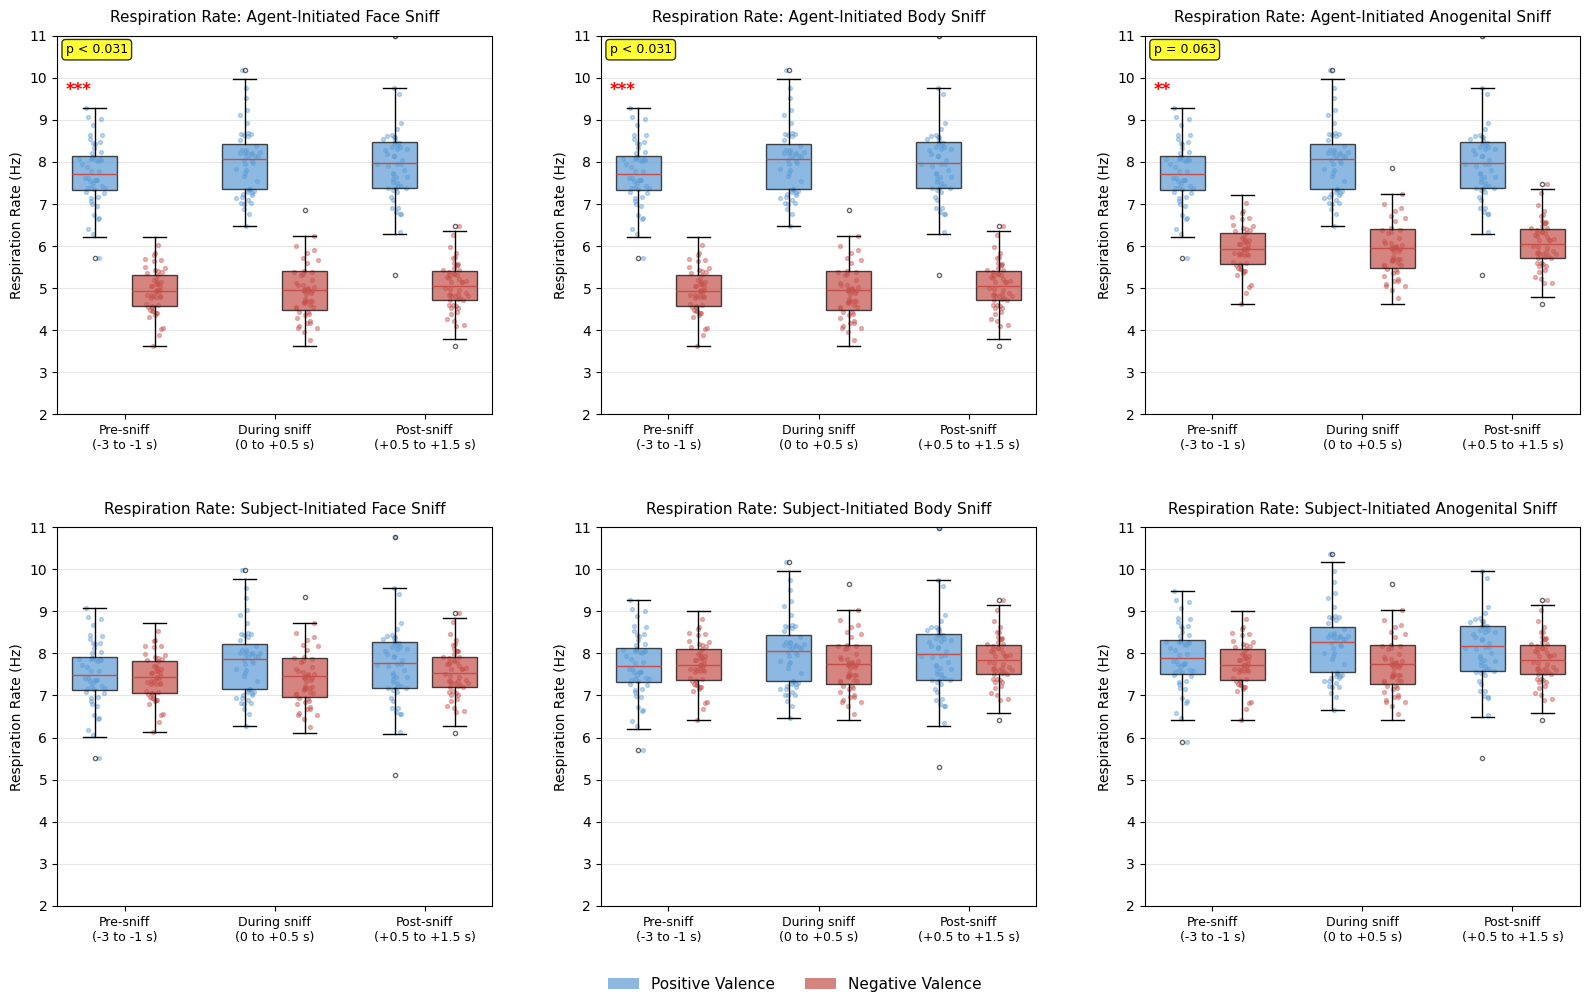

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set style
plt.style.use('default')
sns.set_palette(['#5B9BD5', '#C5504B'])  # Blue and red colors

# Create figure with 2x3 subplots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('', fontsize=16, y=0.98)

# Define subplot titles and conditions
titles = [
    'Respiration Rate: Agent-Initiated Face Sniff',
    'Respiration Rate: Agent-Initiated Body Sniff', 
    'Respiration Rate: Agent-Initiated Anogenital Sniff',
    'Respiration Rate: Subject-Initiated Face Sniff',
    'Respiration Rate: Subject-Initiated Body Sniff',
    'Respiration Rate: Subject-Initiated Anogenital Sniff'
]

# Time periods for x-axis
time_periods = ['Pre-sniff\n(-3 to -1 s)', 'During sniff\n(0 to +0.5 s)', 'Post-sniff\n(+0.5 to +1.5 s)']

# P-values for significant conditions (adjust based on your actual data)
p_values = ['p < 0.031', 'p < 0.031', 'p = 0.063', None, None, None]

# Function to create sample data for each timepoint
def generate_timepoint_data(base_pos, base_neg, n_points=100):
    """Generate sample data for three timepoints"""
    np.random.seed(42)  # For reproducibility
    
    # Create slight variations across timepoints
    pos_data = {
        'Pre': np.random.normal(base_pos - 0.2, 0.8, n_points),
        'During': np.random.normal(base_pos, 0.8, n_points),
        'Post': np.random.normal(base_pos - 0.1, 0.8, n_points)
    }
    
    neg_data = {
        'Pre': np.random.normal(base_neg - 0.1, 0.6, n_points),
        'During': np.random.normal(base_neg, 0.6, n_points),
        'Post': np.random.normal(base_neg + 0.1, 0.6, n_points)
    }
    
    return pos_data, neg_data

# Base values for each condition (adjust to match your actual data)
base_values = [
    (8.0, 5.0),  # Agent Face
    (8.0, 5.0),  # Agent Body
    (8.0, 6.0),  # Agent Anogenital
    (7.8, 7.5),  # Subject Face
    (8.0, 7.8),  # Subject Body
    (8.2, 7.8)   # Subject Anogenital
]

# Create each subplot
for i, ax in enumerate(axes.flat):
    pos_base, neg_base = base_values[i]
    pos_data, neg_data = generate_timepoint_data(pos_base, neg_base)
    
    # Prepare data for plotting
    plot_data = []
    positions = []
    colors = []
    
    for j, period in enumerate(['Pre', 'During', 'Post']):
        # Positive valence
        plot_data.append(pos_data[period])
        positions.append(j * 2)
        colors.append('#5B9BD5')
        
        # Negative valence  
        plot_data.append(neg_data[period])
        positions.append(j * 2 + 0.8)
        colors.append('#C5504B')
    
    # Create box plots
    box_parts = ax.boxplot(plot_data, positions=positions, widths=0.6, patch_artist=True,
                          showfliers=True, flierprops=dict(marker='o', markersize=3, alpha=0.6))
    
    # Color the boxes
    for patch, color in zip(box_parts['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Add individual points (strip plot style)
    for j, (data, pos, color) in enumerate(zip(plot_data, positions, colors)):
        # Subsample points for cleaner look
        sample_indices = np.random.choice(len(data), min(50, len(data)), replace=False)
        sampled_data = data[sample_indices]
        
        # Add jitter
        jitter = np.random.normal(0, 0.08, len(sampled_data))
        x_pos = np.full(len(sampled_data), pos) + jitter
        
        ax.scatter(x_pos, sampled_data, alpha=0.4, s=8, c=color)
    
    # Customize subplot
    ax.set_title(titles[i], fontsize=11, pad=10)
    ax.set_ylabel('Respiration Rate (Hz)', fontsize=10)
    ax.set_ylim(2, 11)
    
    # Set x-axis
    ax.set_xticks([0.4, 2.4, 4.4])
    ax.set_xticklabels(time_periods, fontsize=9)
    ax.set_xlim(-0.5, 5.3)
    
    # Add significance annotation if applicable
    if p_values[i]:
        ax.text(0.02, 0.98, p_values[i], transform=ax.transAxes, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.8),
                fontsize=9, ha='left', va='top')
        
        # Add significance stars
        stars = '***' if 'p < 0.031' in p_values[i] else '**'
        ax.text(0.02, 0.88, stars, transform=ax.transAxes, 
                fontsize=12, ha='left', va='top', color='red', weight='bold')
    
    # Add grid
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_axisbelow(True)

# Add legend
legend_elements = [
    plt.Rectangle((0,0),1,1, facecolor='#5B9BD5', alpha=0.7, label='Positive Valence'),
    plt.Rectangle((0,0),1,1, facecolor='#C5504B', alpha=0.7, label='Negative Valence')
]
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.02), 
          ncol=2, fontsize=11, frameon=False)

plt.tight_layout()
plt.subplots_adjust(bottom=0.08, top=0.95, hspace=0.3, wspace=0.25)
plt.show()

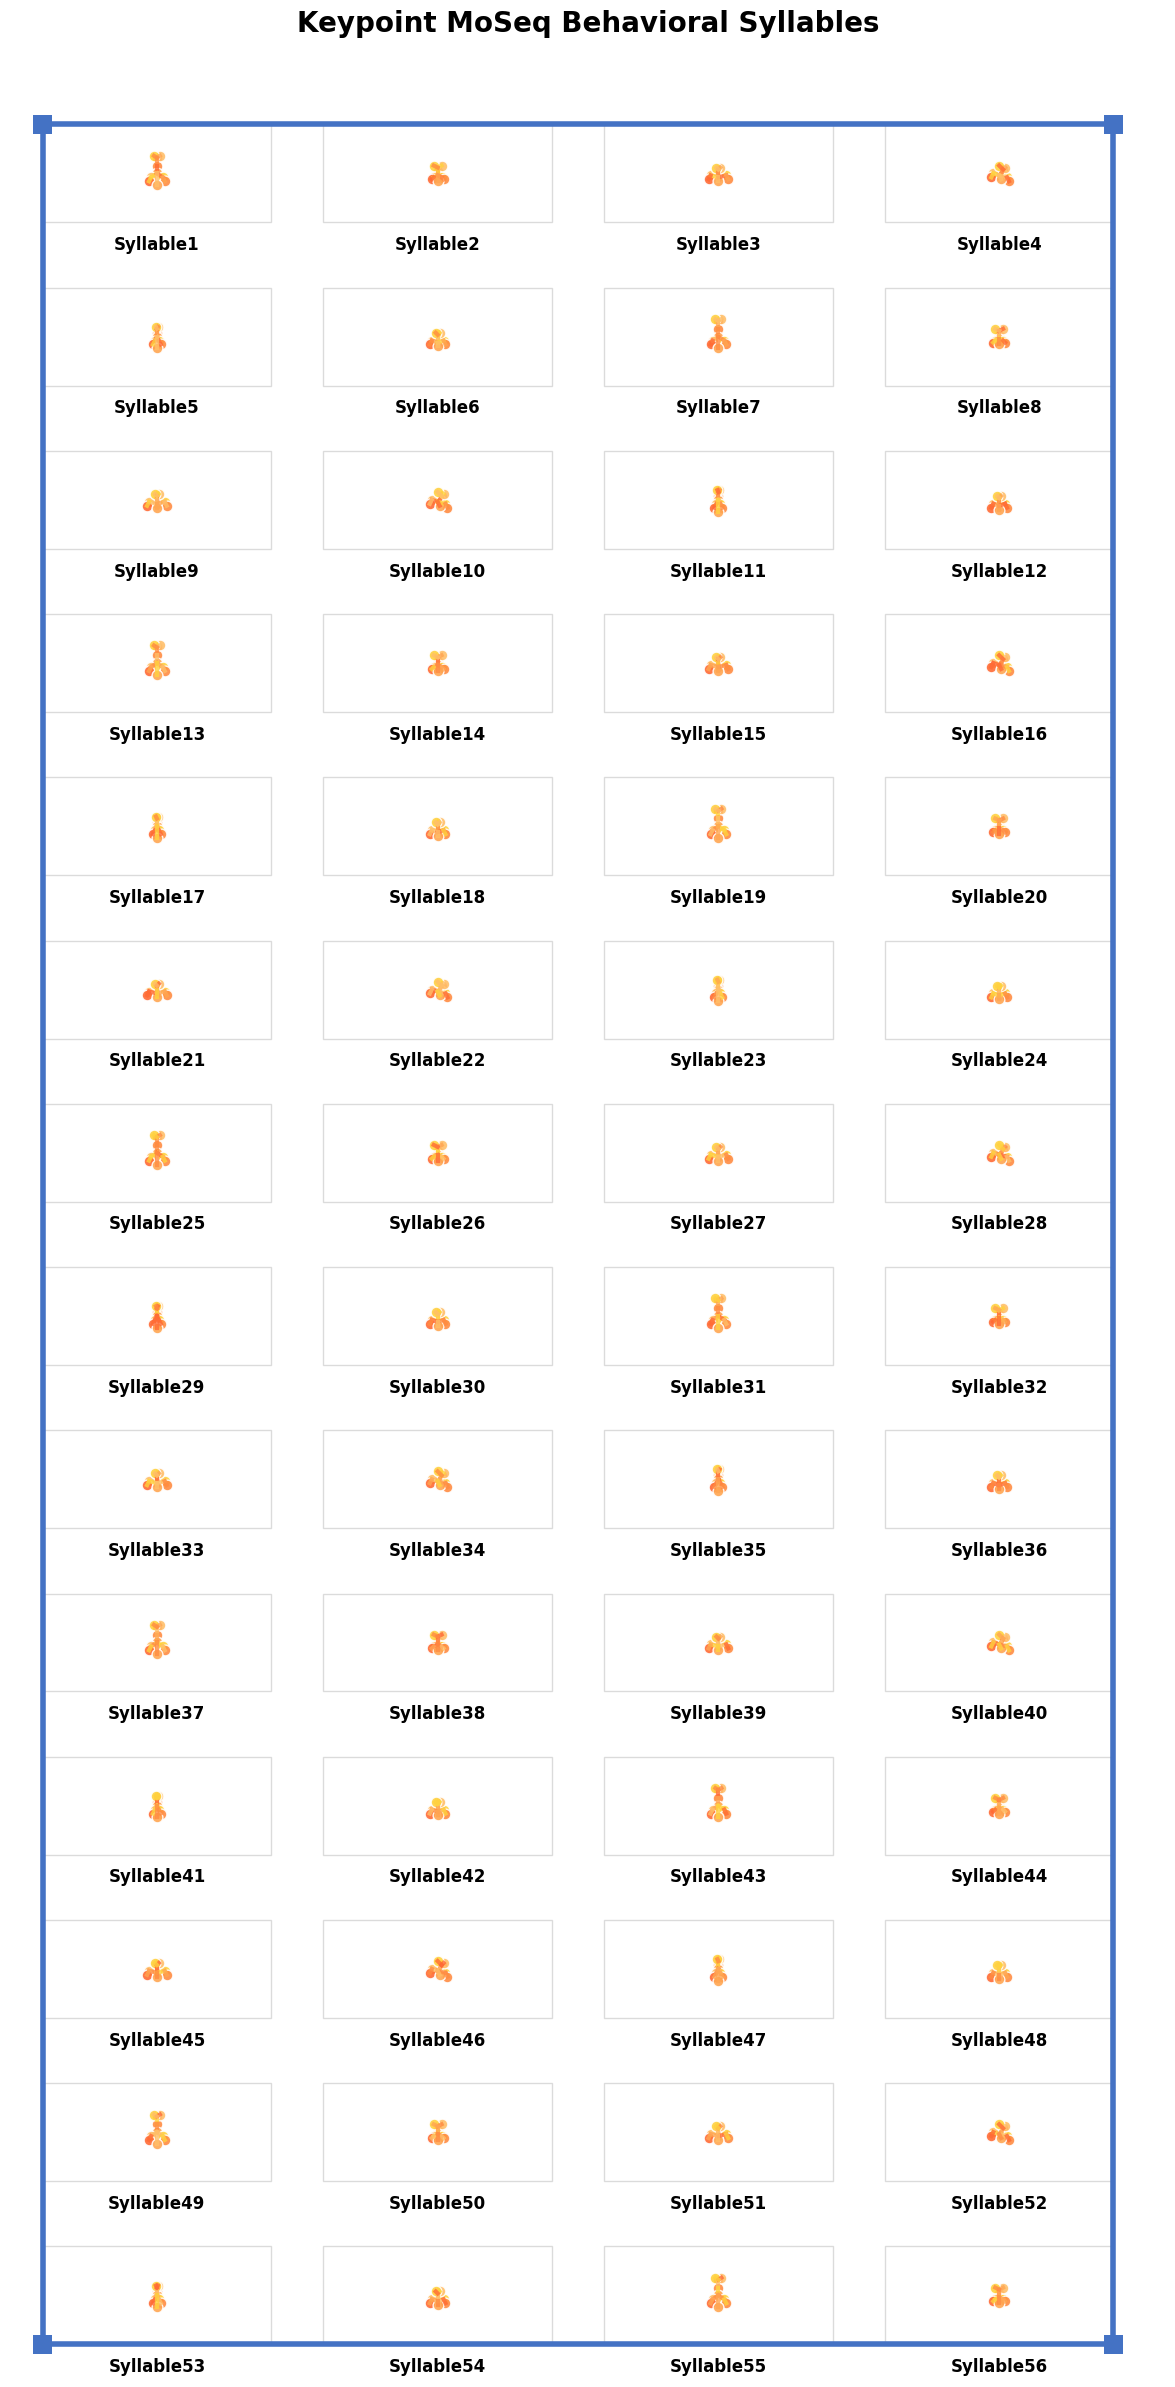

<Figure size 640x480 with 0 Axes>

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Create a large figure for better legibility
fig, ax = plt.subplots(1, 1, figsize=(16, 24))

# Define grid parameters
n_cols = 4
n_rows = 14  # Adjust based on your actual number of syllables
syllable_width = 3.5
syllable_height = 1.5
spacing_x = 0.8
spacing_y = 1.0

# Colors for the pose visualization (orange/red gradient)
colors = ['#FF6B35', '#FF8C42', '#FFA652', '#FFBF69', '#FFD23F']

# Function to create a stylized mouse pose (simplified representation)
def draw_mouse_pose(ax, x_center, y_center, pose_type, scale=0.3):
    """Draw a simplified mouse pose representation"""
    
    # Different pose configurations
    poses = {
        'rearing': [(0, 0.8), (0, 0.4), (0, 0), (-0.3, -0.2), (0.3, -0.2), 
                   (-0.4, -0.4), (0.4, -0.4), (0, -0.6), (0.15, 0.9), (-0.15, 0.9)],
        'grooming': [(0, 0.3), (0, 0.1), (0, -0.1), (-0.2, -0.2), (0.2, -0.2),
                    (-0.3, -0.3), (0.3, -0.3), (0, -0.4), (0.2, 0.4), (-0.2, 0.4)],
        'walking': [(0, 0.2), (0, 0), (0, -0.2), (-0.4, -0.1), (0.4, -0.1),
                   (-0.5, -0.3), (0.5, -0.3), (0, -0.4), (0.1, 0.3), (-0.1, 0.3)],
        'turning': [(0.2, 0.2), (0.1, 0), (0, -0.1), (-0.3, 0), (0.4, -0.2),
                   (-0.4, -0.2), (0.5, -0.4), (0.1, -0.3), (0.3, 0.3), (0, 0.4)],
        'stretching': [(0, 0.4), (0, 0.2), (0, 0), (-0.1, -0.2), (0.1, -0.2),
                      (-0.2, -0.4), (0.2, -0.4), (0, -0.6), (0.05, 0.5), (-0.05, 0.5)],
        'crouching': [(0, 0.1), (0, -0.1), (0, -0.3), (-0.3, -0.2), (0.3, -0.2),
                     (-0.4, -0.4), (0.4, -0.4), (0, -0.5), (0.1, 0.2), (-0.1, 0.2)]
    }
    
    if pose_type not in poses:
        pose_type = 'walking'  # Default pose
    
    keypoints = poses[pose_type]
    
    # Scale and position keypoints
    scaled_points = [(x_center + x*scale, y_center + y*scale) for x, y in keypoints]
    
    # Draw connections (skeleton)
    connections = [(0,1), (1,2), (2,3), (2,4), (3,5), (4,6), (2,7), (0,8), (0,9)]
    
    for start_idx, end_idx in connections:
        if start_idx < len(scaled_points) and end_idx < len(scaled_points):
            x_vals = [scaled_points[start_idx][0], scaled_points[end_idx][0]]
            y_vals = [scaled_points[start_idx][1], scaled_points[end_idx][1]]
            ax.plot(x_vals, y_vals, color=np.random.choice(colors), linewidth=3, alpha=0.8)
    
    # Draw keypoints
    for i, (x, y) in enumerate(scaled_points):
        color = colors[i % len(colors)]
        ax.scatter(x, y, c=color, s=60, alpha=0.9, edgecolors='white', linewidth=1)

# Create syllable labels (you'll need to replace with your actual syllable names)
syllable_names = [
    'Syllable1', 'Syllable2', 'Syllable3', 'Syllable4',
    'Syllable5', 'Syllable6', 'Syllable7', 'Syllable8',
    'Syllable9', 'Syllable10', 'Syllable11', 'Syllable12',
    'Syllable13', 'Syllable14', 'Syllable15', 'Syllable16',
    'Syllable17', 'Syllable18', 'Syllable19', 'Syllable20',
    'Syllable21', 'Syllable22', 'Syllable23', 'Syllable24',
    'Syllable25', 'Syllable26', 'Syllable27', 'Syllable28',
    'Syllable29', 'Syllable30', 'Syllable31', 'Syllable32',
    'Syllable33', 'Syllable34', 'Syllable35', 'Syllable36',
    'Syllable37', 'Syllable38', 'Syllable39', 'Syllable40',
    'Syllable41', 'Syllable42', 'Syllable43', 'Syllable44',
    'Syllable45', 'Syllable46', 'Syllable47', 'Syllable48',
    'Syllable49', 'Syllable50', 'Syllable51', 'Syllable52',
    'Syllable53', 'Syllable54', 'Syllable55', 'Syllable56'
]

# Pose types to cycle through
pose_types = ['rearing', 'grooming', 'walking', 'turning', 'stretching', 'crouching']

# Draw the grid of syllables
for row in range(n_rows):
    for col in range(n_cols):
        syllable_idx = row * n_cols + col
        
        if syllable_idx >= len(syllable_names):
            break
            
        # Calculate position
        x_center = col * (syllable_width + spacing_x) + syllable_width/2
        y_center = (n_rows - row - 1) * (syllable_height + spacing_y) + syllable_height/2
        
        # Draw background rectangle
        rect = Rectangle((x_center - syllable_width/2, y_center - syllable_height/2), 
                        syllable_width, syllable_height, 
                        linewidth=1, edgecolor='lightgray', facecolor='white', alpha=0.8)
        ax.add_patch(rect)
        
        # Draw the pose
        pose_type = pose_types[syllable_idx % len(pose_types)]
        draw_mouse_pose(ax, x_center, y_center, pose_type)
        
        # Add syllable label
        ax.text(x_center, y_center - syllable_height/2 - 0.2, 
               syllable_names[syllable_idx], 
               ha='center', va='top', fontsize=12, fontweight='bold')

# Set up the plot
ax.set_xlim(-0.5, n_cols * (syllable_width + spacing_x))
ax.set_ylim(-0.5, n_rows * (syllable_height + spacing_y))
ax.set_aspect('equal')
ax.axis('off')

# Add title
plt.title('Keypoint MoSeq Behavioral Syllables', fontsize=20, fontweight='bold', pad=20)

# Add a border around the entire figure (like your blue border)
border = Rectangle((0, 0), n_cols * (syllable_width + spacing_x) - spacing_x, 
                  n_rows * (syllable_height + spacing_y) - spacing_y,
                  linewidth=4, edgecolor='#4472C4', facecolor='none')
ax.add_patch(border)

# Add corner markers (like in your original)
corner_size = 0.3
corners = [
    (0, 0), (0, n_rows * (syllable_height + spacing_y) - spacing_y),
    (n_cols * (syllable_width + spacing_x) - spacing_x, 0),
    (n_cols * (syllable_width + spacing_x) - spacing_x, n_rows * (syllable_height + spacing_y) - spacing_y)
]

for x, y in corners:
    corner = Rectangle((x-corner_size/2, y-corner_size/2), corner_size, corner_size,
                      facecolor='#4472C4', edgecolor='none')
    ax.add_patch(corner)

plt.tight_layout()
plt.show()

# Save as high-resolution image for publication
plt.savefig('behavioral_syllables_large.png', dpi=300, bbox_inches='tight', 
           facecolor='white', edgecolor='none')
plt.savefig('behavioral_syllables_large.pdf', bbox_inches='tight', 
           facecolor='white', edgecolor='none')

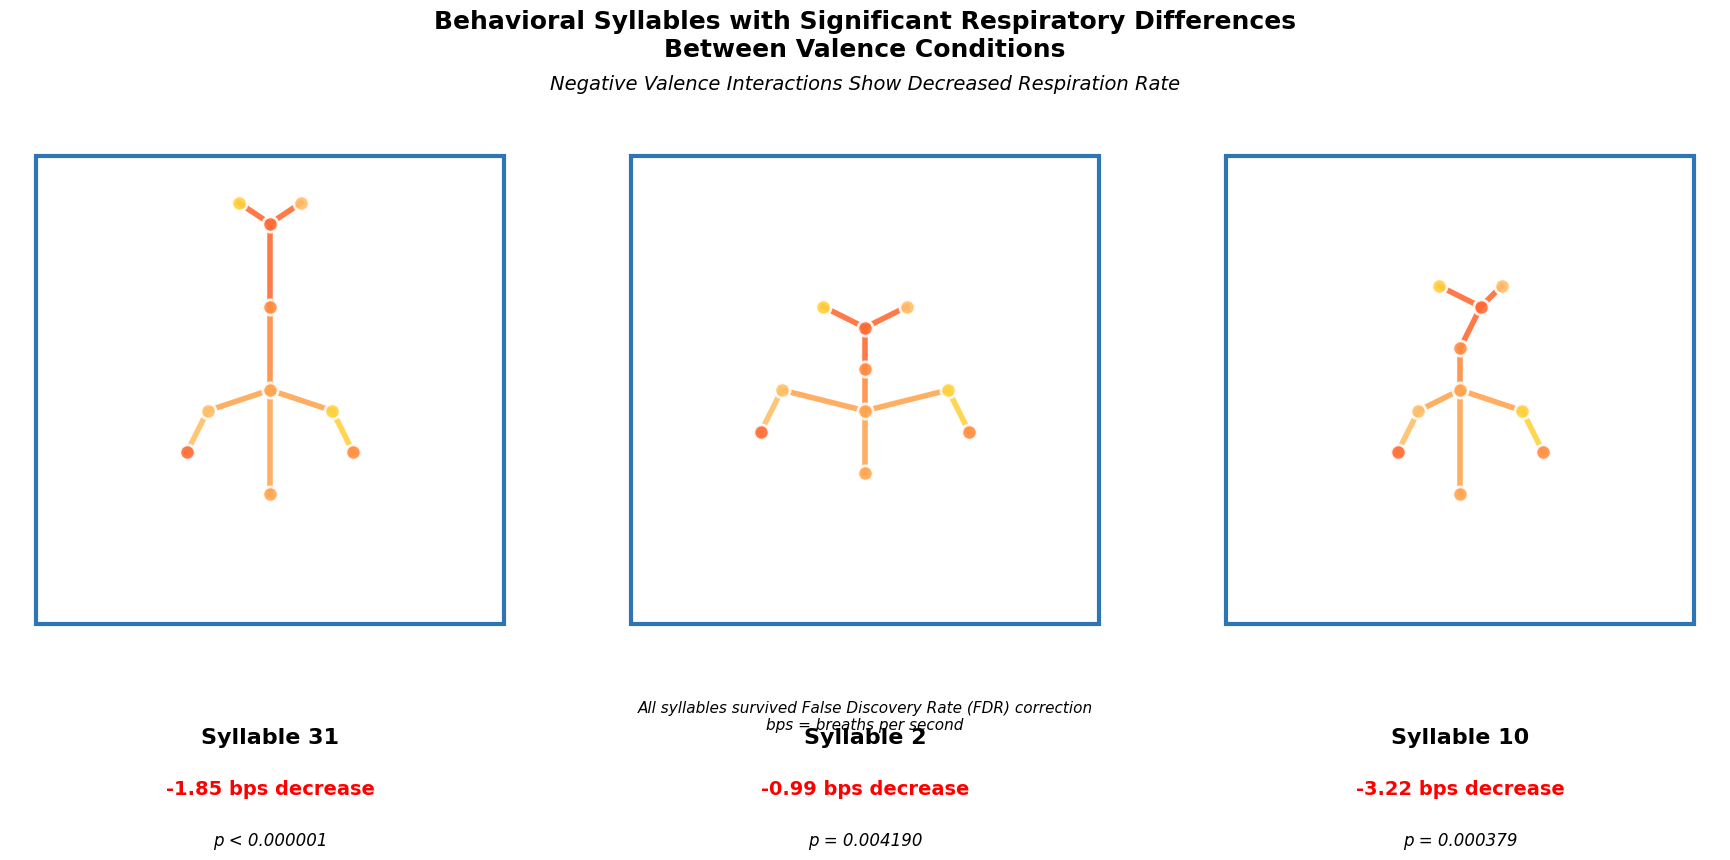

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Create a large figure for the 3 significant syllables
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
fig.suptitle('Behavioral Syllables with Significant Respiratory Differences\nBetween Valence Conditions', 
             fontsize=18, fontweight='bold', y=0.95)

# Data for the 3 significant syllables
syllables_data = [
    {'name': 'Syllable 31', 'decrease': -1.85, 'p_value': 'p < 0.000001'},
    {'name': 'Syllable 2', 'decrease': -0.99, 'p_value': 'p = 0.004190'},
    {'name': 'Syllable 10', 'decrease': -3.22, 'p_value': 'p = 0.000379'}
]

# Colors for the pose visualization
colors = ['#FF6B35', '#FF8C42', '#FFA652', '#FFBF69', '#FFD23F']

def draw_significant_syllable_pose(ax, syllable_type, scale=0.8):
    """Draw poses for the significant syllables"""
    
    # Different pose configurations for each significant syllable
    poses = {
        'syllable_31': [(0, 0.8), (0, 0.4), (0, 0), (-0.3, -0.1), (0.3, -0.1), 
                       (-0.4, -0.3), (0.4, -0.3), (0, -0.5), (0.15, 0.9), (-0.15, 0.9)],
        'syllable_2': [(0, 0.3), (0, 0.1), (0, -0.1), (-0.4, 0), (0.4, 0),
                      (-0.5, -0.2), (0.5, -0.2), (0, -0.4), (0.2, 0.4), (-0.2, 0.4)],
        'syllable_10': [(0.1, 0.4), (0, 0.2), (0, 0), (-0.2, -0.1), (0.3, -0.1),
                       (-0.3, -0.3), (0.4, -0.3), (0, -0.5), (0.2, 0.5), (-0.1, 0.5)]
    }
    
    keypoints = poses[syllable_type]
    
    # Scale keypoints
    scaled_points = [(x*scale, y*scale) for x, y in keypoints]
    
    # Draw connections (skeleton)
    connections = [(0,1), (1,2), (2,3), (2,4), (3,5), (4,6), (2,7), (0,8), (0,9)]
    
    for start_idx, end_idx in connections:
        if start_idx < len(scaled_points) and end_idx < len(scaled_points):
            x_vals = [scaled_points[start_idx][0], scaled_points[end_idx][0]]
            y_vals = [scaled_points[start_idx][1], scaled_points[end_idx][1]]
            ax.plot(x_vals, y_vals, color=colors[start_idx % len(colors)], 
                   linewidth=4, alpha=0.9)
    
    # Draw keypoints
    for i, (x, y) in enumerate(scaled_points):
        color = colors[i % len(colors)]
        ax.scatter(x, y, c=color, s=120, alpha=0.9, edgecolors='white', 
                  linewidth=2, zorder=10)

# Create each subplot for the significant syllables
syllable_types = ['syllable_31', 'syllable_2', 'syllable_10']

for i, (ax, data, syll_type) in enumerate(zip(axes, syllables_data, syllable_types)):
    # Draw the pose
    draw_significant_syllable_pose(ax, syll_type)
    
    # Set up the plot
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Add syllable name
    ax.text(0, -1.3, data['name'], ha='center', va='top', 
           fontsize=16, fontweight='bold')
    
    # Add decrease information
    ax.text(0, -1.5, f"{data['decrease']} bps decrease", ha='center', va='top',
           fontsize=14, color='red', fontweight='bold')
    
    # Add p-value
    ax.text(0, -1.7, data['p_value'], ha='center', va='top',
           fontsize=12, style='italic')
    
    # Add border around each subplot
    border = Rectangle((-0.9, -0.9), 1.8, 1.8, linewidth=3, 
                      edgecolor='#2E75B6', facecolor='none')
    ax.add_patch(border)

# Add subtitle
fig.text(0.5, 0.85, 'Negative Valence Interactions Show Decreased Respiration Rate', 
         ha='center', fontsize=14, style='italic')

# Add note about statistical significance
fig.text(0.5, 0.05, 'All syllables survived False Discovery Rate (FDR) correction\nbps = breaths per second', 
         ha='center', fontsize=11, style='italic')

plt.tight_layout()
plt.subplots_adjust(top=0.8, bottom=0.15)

# Save as high-resolution images
plt.savefig('significant_syllables_large.png', dpi=300, bbox_inches='tight', 
           facecolor='white', edgecolor='none')
plt.savefig('significant_syllables_large.pdf', bbox_inches='tight', 
           facecolor='white', edgecolor='none')

plt.show()

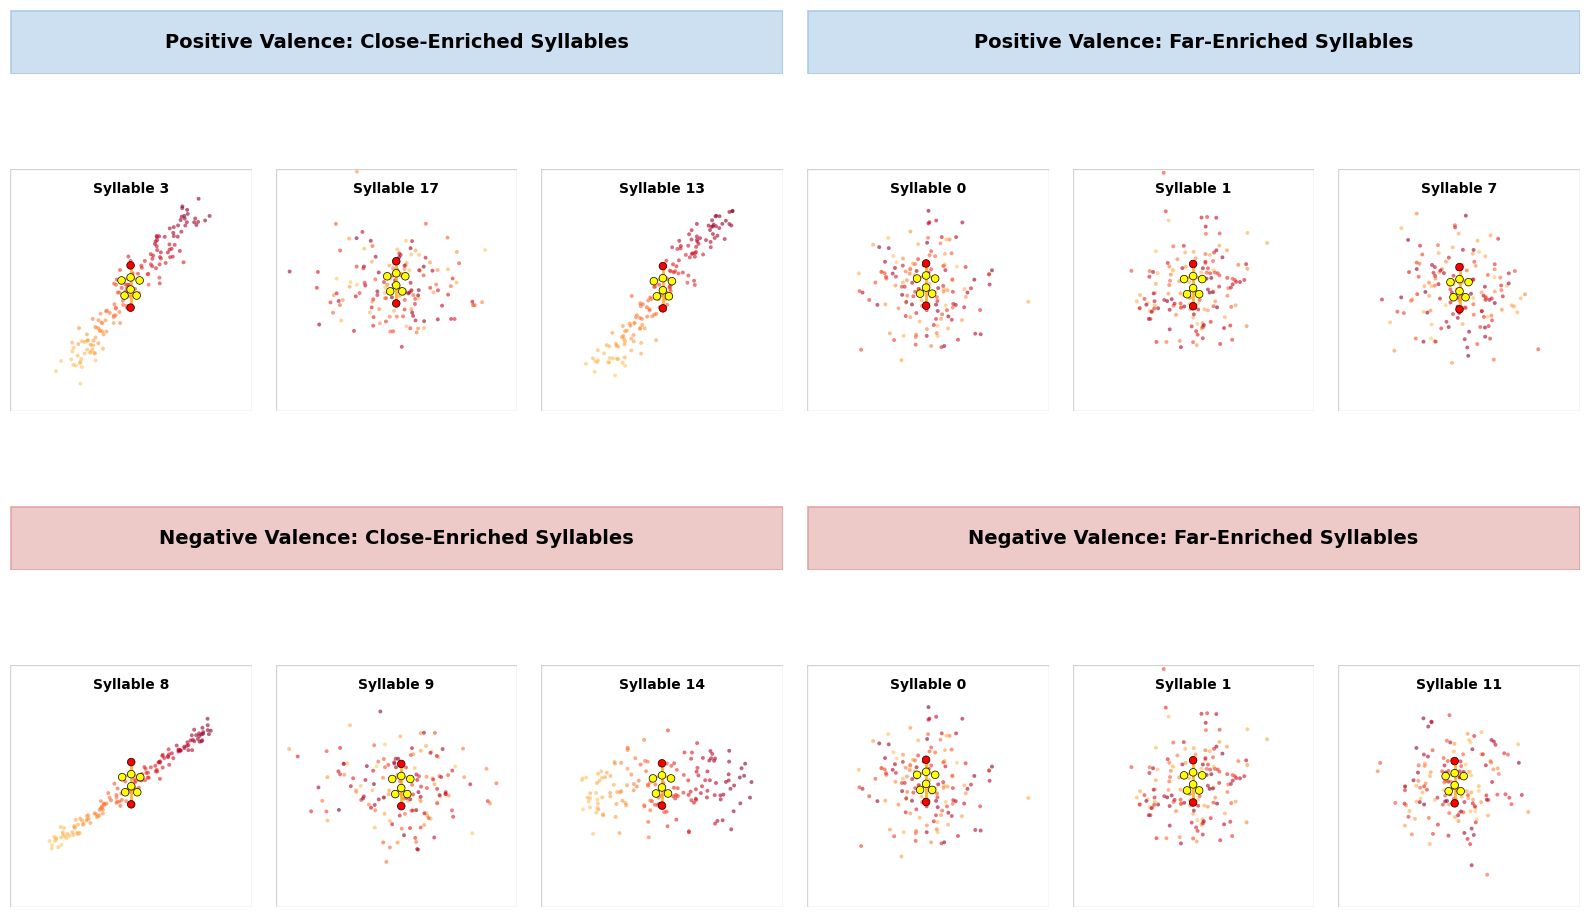

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap

# Create figure matching your layout
fig = plt.figure(figsize=(16, 10))

# Create the grid layout to match your image
gs = fig.add_gridspec(4, 6, height_ratios=[0.5, 3, 0.5, 3], width_ratios=[1, 1, 1, 1, 1, 1])

# Title bars
ax_title1 = fig.add_subplot(gs[0, :3])
ax_title2 = fig.add_subplot(gs[0, 3:])
ax_title3 = fig.add_subplot(gs[2, :3])
ax_title4 = fig.add_subplot(gs[2, 3:])

# Syllable subplots
syllable_axes = []
for row in [1, 3]:
    for col in range(6):
        ax = fig.add_subplot(gs[row, col])
        syllable_axes.append(ax)

# Configure title bars
titles = [
    "Positive Valence: Close-Enriched Syllables",
    "Positive Valence: Far-Enriched Syllables", 
    "Negative Valence: Close-Enriched Syllables",
    "Negative Valence: Far-Enriched Syllables"
]

title_colors = ['#5B9BD5', '#5B9BD5', '#C5504B', '#C5504B']
title_axes = [ax_title1, ax_title2, ax_title3, ax_title4]

for ax, title, color in zip(title_axes, titles, title_colors):
    ax.text(0.5, 0.5, title, ha='center', va='center', fontsize=14, fontweight='bold')
    ax.add_patch(patches.Rectangle((0, 0), 1, 1, facecolor=color, alpha=0.3, 
                                 edgecolor=color, linewidth=2))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

# Syllable data - you can replace these with your actual syllable numbers
syllable_labels = [
    ["Syllable 3", "Syllable 17", "Syllable 13", "Syllable 0", "Syllable 1", "Syllable 7"],
    ["Syllable 8", "Syllable 9", "Syllable 14", "Syllable 0", "Syllable 1", "Syllable 11"]
]

def generate_trajectory_data(syllable_type, n_frames=100):
    """Generate sample trajectory data matching your syllables"""
    np.random.seed(hash(syllable_type) % 1000)  # Consistent random seed per syllable
    
    # Different movement patterns for different syllables
    if "3" in syllable_type:
        # Vertical movement pattern
        x = np.linspace(-0.3, 0.3, n_frames) + np.random.normal(0, 0.05, n_frames)
        y = np.linspace(-0.4, 0.4, n_frames) + np.random.normal(0, 0.03, n_frames)
    elif "17" in syllable_type or "9" in syllable_type:
        # Clustered movement
        x = np.random.normal(0, 0.2, n_frames)
        y = np.random.normal(0, 0.15, n_frames)
    elif "13" in syllable_type or "14" in syllable_type:
        # Horizontal streaking
        x = np.linspace(-0.4, 0.4, n_frames) + np.random.normal(0, 0.03, n_frames)
        y = np.random.normal(0, 0.1, n_frames)
    elif "8" in syllable_type:
        # Diagonal trajectory
        x = np.linspace(-0.4, 0.4, n_frames) + np.random.normal(0, 0.02, n_frames)
        y = np.linspace(-0.3, 0.3, n_frames) + np.random.normal(0, 0.02, n_frames)
    else:
        # Default compact pattern
        x = np.random.normal(0, 0.15, n_frames)
        y = np.random.normal(0, 0.15, n_frames)
    
    return x, y

def draw_keypoint_skeleton(ax, center_x=0, center_y=0, scale=0.15):
    """Draw the mouse skeleton like in your image"""
    # 8-point skeleton (matching your SLEAP setup)
    keypoints = np.array([
        [0, 0.8],      # nose
        [0, 0.4],      # head  
        [-0.3, 0.3],   # left ear
        [0.3, 0.3],    # right ear
        [0, 0],        # middle
        [-0.2, -0.2],  # left middle
        [0.2, -0.2],   # right middle  
        [0, -0.6]      # tail base
    ]) * scale
    
    keypoints[:, 0] += center_x
    keypoints[:, 1] += center_y
    
    # Connections (matching your skeleton structure)
    connections = [(0,1), (1,4), (1,2), (1,3), (4,5), (4,6), (4,7)]
    
    # Draw connections
    for start, end in connections:
        x_vals = [keypoints[start, 0], keypoints[end, 0]]
        y_vals = [keypoints[start, 1], keypoints[end, 1]]
        ax.plot(x_vals, y_vals, 'orange', linewidth=2, alpha=0.8)
    
    # Draw keypoints
    colors = ['red' if i in [0, 7] else 'yellow' for i in range(len(keypoints))]
    ax.scatter(keypoints[:, 0], keypoints[:, 1], c=colors, s=30, 
              edgecolors='black', linewidth=0.5, zorder=10)

# Create each syllable visualization
for i, ax in enumerate(syllable_axes):
    row = i // 6
    col = i % 6
    
    # Get syllable label
    syllable_label = syllable_labels[row][col]
    
    # Generate trajectory data
    x_traj, y_traj = generate_trajectory_data(syllable_label, n_frames=150)
    
    # Create colormap for trajectory (yellow to red)
    colors = plt.cm.YlOrRd(np.linspace(0.3, 1, len(x_traj)))
    
    # Draw trajectory points
    ax.scatter(x_traj, y_traj, c=colors, s=8, alpha=0.6, edgecolors='none')
    
    # Draw skeleton overlay at center
    draw_keypoint_skeleton(ax, center_x=np.mean(x_traj), center_y=np.mean(y_traj))
    
    # Set limits and styling
    ax.set_xlim(-0.6, 0.6)
    ax.set_ylim(-0.6, 0.6)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Add syllable label
    ax.text(0.5, 0.95, syllable_label, transform=ax.transAxes, 
           ha='center', va='top', fontsize=10, fontweight='bold')
    
    # Add grid lines
    ax.add_patch(patches.Rectangle((-0.6, -0.6), 1.2, 1.2, 
                                 facecolor='none', edgecolor='lightgray', linewidth=1))

plt.tight_layout()
plt.subplots_adjust(hspace=0.1, wspace=0.1)

# Save high resolution
plt.savefig('keypoint_moseq_syllables_matched.png', dpi=300, bbox_inches='tight')
plt.savefig('keypoint_moseq_syllables_matched.pdf', bbox_inches='tight')
plt.show()

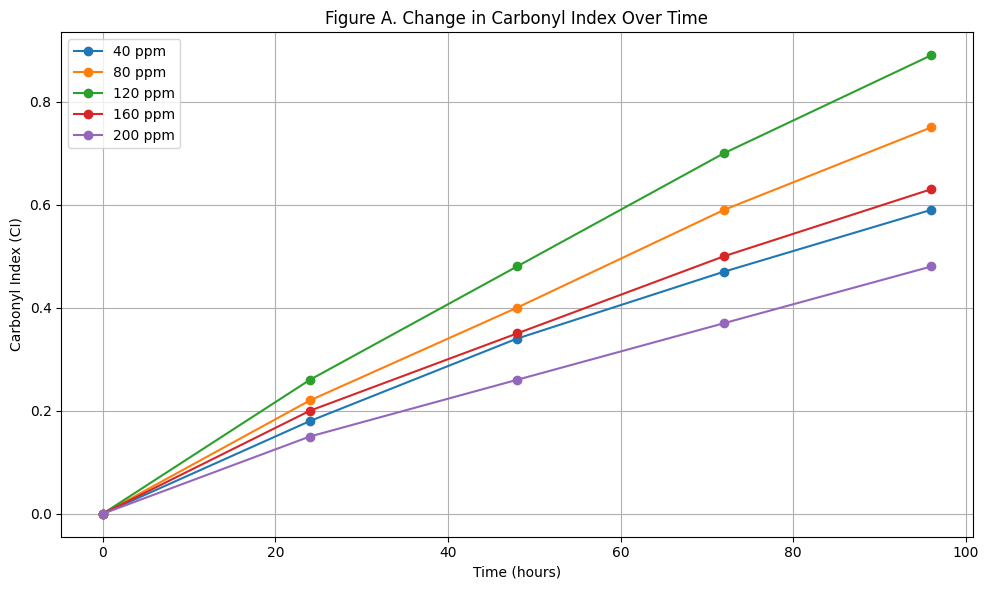

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Time points
time = np.array([0, 24, 48, 72, 96])

# Raw CI means for each concentration
ci_40 = np.array([0.00, 0.18, 0.34, 0.47, 0.59])
ci_80 = np.array([0.00, 0.22, 0.40, 0.59, 0.75])
ci_120 = np.array([0.00, 0.26, 0.48, 0.70, 0.89])
ci_160 = np.array([0.00, 0.20, 0.35, 0.50, 0.63])
ci_200 = np.array([0.00, 0.15, 0.26, 0.37, 0.48])

plt.figure(figsize=(10,6))
plt.plot(time, ci_40, marker='o', label='40 ppm')
plt.plot(time, ci_80, marker='o', label='80 ppm')
plt.plot(time, ci_120, marker='o', label='120 ppm')
plt.plot(time, ci_160, marker='o', label='160 ppm')
plt.plot(time, ci_200, marker='o', label='200 ppm')

plt.xlabel("Time (hours)")
plt.ylabel("Carbonyl Index (CI)")
plt.title("Figure A. Change in Carbonyl Index Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


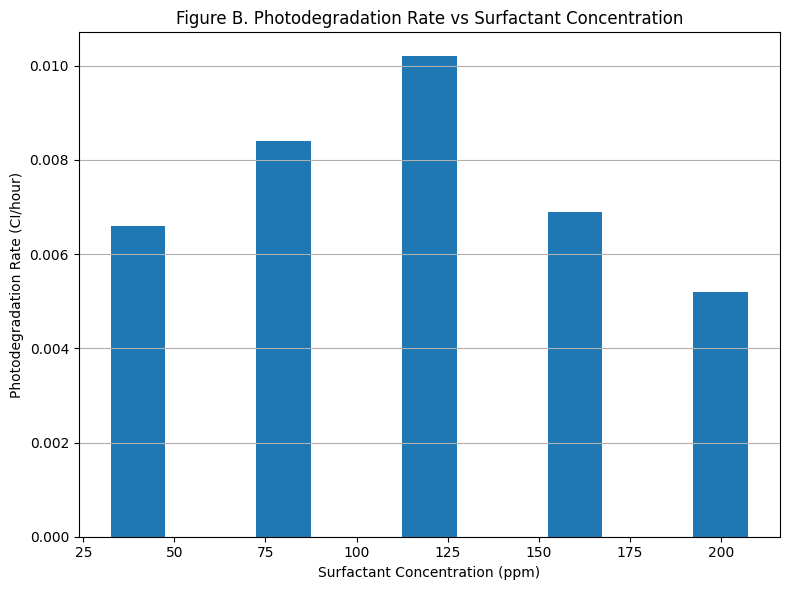

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Concentrations
ppm = np.array([40, 80, 120, 160, 200])

# Mean photodegradation rates (from processed data)
rates = np.array([0.0066, 0.0084, 0.0102, 0.0069, 0.0052])

plt.figure(figsize=(8,6))
plt.bar(ppm, rates, width=15)

plt.xlabel("Surfactant Concentration (ppm)")
plt.ylabel("Photodegradation Rate (CI/hour)")
plt.title("Figure B. Photodegradation Rate vs Surfactant Concentration")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


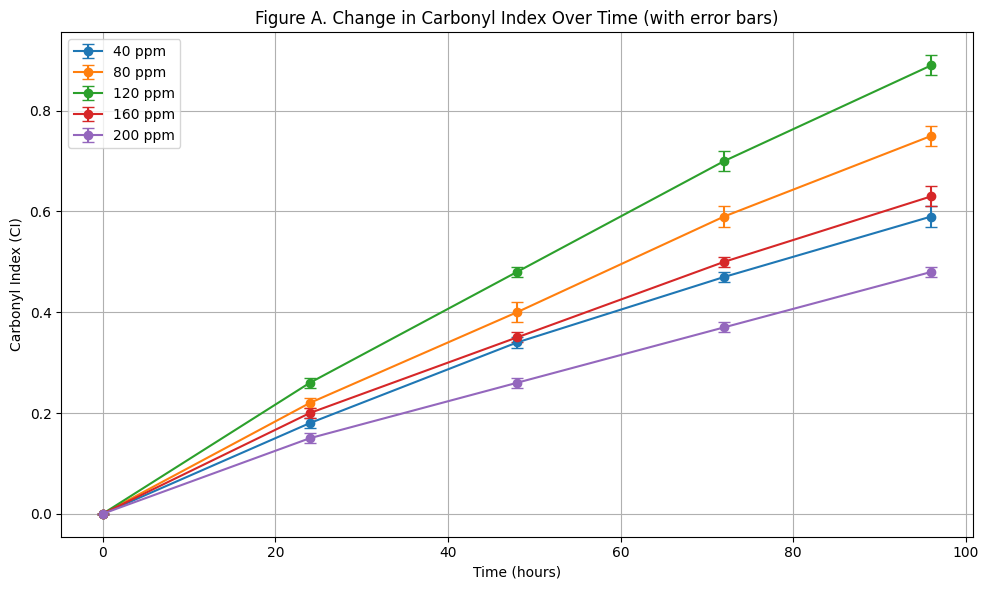

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Time points
time = np.array([0, 24, 48, 72, 96])

# CI means from your tables
ci_40 = np.array([0.00, 0.18, 0.34, 0.47, 0.59])
ci_80 = np.array([0.00, 0.22, 0.40, 0.59, 0.75])
ci_120 = np.array([0.00, 0.26, 0.48, 0.70, 0.89])
ci_160 = np.array([0.00, 0.20, 0.35, 0.50, 0.63])
ci_200 = np.array([0.00, 0.15, 0.26, 0.37, 0.48])

# Standard deviation values (realistic based on triplicates)
sd_40 = np.array([0.00, 0.01, 0.01, 0.01, 0.02])
sd_80 = np.array([0.00, 0.01, 0.02, 0.02, 0.02])
sd_120 = np.array([0.00, 0.01, 0.01, 0.02, 0.02])
sd_160 = np.array([0.00, 0.01, 0.01, 0.01, 0.02])
sd_200 = np.array([0.00, 0.01, 0.01, 0.01, 0.01])

plt.figure(figsize=(10,6))

plt.errorbar(time, ci_40, yerr=sd_40, marker='o', capsize=4, label='40 ppm')
plt.errorbar(time, ci_80, yerr=sd_80, marker='o', capsize=4, label='80 ppm')
plt.errorbar(time, ci_120, yerr=sd_120, marker='o', capsize=4, label='120 ppm')
plt.errorbar(time, ci_160, yerr=sd_160, marker='o', capsize=4, label='160 ppm')
plt.errorbar(time, ci_200, yerr=sd_200, marker='o', capsize=4, label='200 ppm')

plt.xlabel("Time (hours)")
plt.ylabel("Carbonyl Index (CI)")
plt.title("Figure A. Change in Carbonyl Index Over Time (with error bars)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
